# Glottochronology of Indo-Aryan(Indic) Languages

# Data collection and Cleaning

We beign our research by first collecting words of 18 Indic languages with their IPA translations from wikitionary website. To collect the data, web scraping with beautiful soup library is utilized. 

In [2]:
# importing all the necessary libraries  
from __future__ import division, print_function, unicode_literals
import json
from functools import partial
from lingpy.settings import rcParams
from lingpy.align.sca import Alignments
from lingpy.align._align.confidence import get_correspondences
from lingpy.compare.lexstat import LexStat
from lingpy import util
from lingpy.evaluate.acd import bcubes, diff
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib3
import re

The below code is used to collect data from Wikitionary webstie, which containes Swadesh list for Indic languages. In the Wiktionary website all the data is given in table format. Therefore, first, all the words from the table were extracted in a list. There were a few missing entries for the words in the ‘Kashmiri’ language, these missing entries were replaced by ‘None’. All of these words in the table have a hyperlink that redirects the page to another page that contains the IPA of that particular word. To collect the IPA, all such hyperlinks were found and appended to another list. A tuple of list is created for every concept which consists of 3 entries for every concept- Language, word, and the link to IPA.

In [3]:
http = urllib3.PoolManager()
urllib3.disable_warnings()
def word_lists_to_dict(headings, tables):
    ipa_links_found = []
    new_swadesh_list_rows = []
    # find all the entries in table in Wikitionary website
    # Every row containes different words, hence we are itertating to each row in the table
    for table in tables: 
        for row in table.find_all("tr")[1:]: 
            links_in_table = []
            word_in_row = []
            links_in_cell = []
            for cell in row.find_all("td")[1:]:
                if cell and cell.get_text():
                    txt1 = cell.get_text().split()[0]
                    #If row contains the below words the text is replaced by None 
                    if txt1 in ['[[#Konkani|]]', '[[#Kashmiri|]]', 'locative case'] or 'locative' in txt1:
                        word_in_row.append(None)
                    else:
                        word_in_row.append(txt1)
                    
                else:
                    word_in_row.append(None)
                    
                if cell.find('span', class_='swadesh-translit'):
                    
                    txt = cell.select_one('span', class_='swadesh-translit').get_text()
                    if txt not in ['[[#Konkani|]]', '[[#Kashmiri|]]', 'locative case'] and 'locative' not in txt:
                        links_in_table.append(cell.select_one('a').get('href'))
                    else:
                        links_in_table.append(None)
                  
                else:
                    links_in_table.append(None)
                                  
                        
            new_swadesh_list_rows.append(word_in_row)
            ipa_links_found.append(links_in_table)

    swadesh_list_dict = []
    for i, row in enumerate(new_swadesh_list_rows):
        row_link_all = list(zip(headings, row, ipa_links_found[i]))
        swadesh_list_dict.append(row_link_all)

    return swadesh_list_dict

In the code below we create a file to store IPA for each word we found above. For this, every word and the link in the tuple of list is iterated and IPA entry for each word is extracted with web scraping’s beautiful soup method from the page and stored in text file. For every entry in the row, the code checks if the entry is not a None value, it takes the hyperlink associated with the entry and scrapes the IPA for the entry. If the entry for the word is None, the IPA value is also written as None in the file.

In [5]:
#Function to create IPA file. This function checks every value extracted from the table, 
#if the value is None, the IPA entry is written as None and If the value of the word is not None, 
#the IPA link extracted from the above code is follwed and IPA value for that word is extracted from the webpage
def ipa_file(dict_of_rows, request_path):
    with open(r"C:\Users\SHALAKA\Desktop\input\ipa_tokens.txt", "w+", encoding="utf-8") as f:
        for row in dict_of_rows:
            for cell_list in row:
                ipa_text = None
                if cell_list[1] == None:
                    ipa_text = None     
                else:
                    if cell_list[2] is not None:

                        ipa_request = http.request('GET', request_path + cell_list[2])
                        ipa_request = ipa_request.data.decode('UTF-8')
                        ipa_query_soup = BeautifulSoup(ipa_request, "html.parser")
                        ipa_text = ipa_query_soup.find('span', {'class': 'IPA'})
                        if ipa_text:

                            ipa_text = ipa_text.get_text()
                        else:
                            ipa_text = None


                    else:
                        ipa_text = None
                    
                print([cell_list[0], cell_list[1], ipa_text])
                f.write(str(ipa_text)+"\n")

In the code below, we read IPA file created above and join the IPA entries with the Cognancy, Concept, Word, and dialect extracted from the above steps together in a list. This list is created for every word. Here to select the words, which can be treated as concepts, words from the Sanskrit language were chosen.

In [6]:
def ipa_file_read(file_name, swadesh_list_dict, headings):
    output_list_of_rows = []
    print(len(swadesh_list_dict[0]), len(headings))
    with open(file_name, "r", encoding="utf-8") as f:
        accumulator = 0
        for i, row in enumerate(swadesh_list_dict):
            #setting the concept as words from Sanskrit language. 
            concept = row[0][1]
            for j, heading in enumerate(headings):
                print(row[j], len(row), len(row[j]))
                token = f.readline().strip().strip('[]/')
                token = ''.join(re.split(r'\W+', token))
                #if the word is not None
                if row[j][1]  is str:
                    csv_row = [str(accumulator), concept, row[j][1].strip(','), token,  heading]
                    
                    output_list_of_rows.append(csv_row)
                #if the word is None
                else:
                    csv_row = [str(accumulator), concept, row[j][1], token,  heading]
                    print(csv_row)
                    output_list_of_rows.append(csv_row)
                    
            accumulator += 1
    return output_list_of_rows

In [127]:
def read_ipaEval_file(file_name, dict_swadesh_list, headings):
    output_list_of_rows = []
    print(len(dict_swadesh_list[0]), len(headings))
    with open(file_name, "r", encoding="utf-8") as f:
        accumulator = 0
        for i, row in enumerate(dict_swadesh_list):
            concept = row[0][1]
            for j, heading in enumerate(headings):
                print(row[j], len(row), len(row[j]))
                token = f.readline().strip().strip('[]/')
                token = ''.join(re.split(r'\W+', token))
                if row[j][1]  is str:
                    csv_row = [str(accumulator), concept, row[j][1].strip(','), token,  heading, row[j][3]]
                    output_list_of_rows.append(csv_row)
                else:
                    csv_row = [str(accumulator), concept, row[j][1], token,  heading, row[j][3]]
                    print(csv_row)
                    output_list_of_rows.append(csv_row)
                    
            accumulator += 1
    return output_list_of_rows

In the below code, we create a tsv file that contains all the entries obtained from the above code. The tsv file containes, 5 columns, word ID, conept, counterpart, IPA and Doculect. Throughout the research, we will use this file for analysis. 

In [7]:
def create_lingpy_file(rows_to_output):
    with open(r"C:\Users\SHALAKA\Desktop\input\Swadesh_list_final.tsv", "w", encoding="utf-8") as outfile:
        outfile.write("#\n")
        outfile.write("\t".join(['COGNACY', 'CONCEPT', 'COUNTERPART', 'IPA', 'DOCULECT']) + "\n\n\n")
        for row in rows_to_output:
            for i in range(len(row)):
                if row[i] == None:
                    row[i] = str(None)
            print(row)
            outfile.write("\t".join(row) +"\n")

The code below, iterates through Wikitionary Website, and finds the table of Indo-Aryan swadesh lists and extracts all the information from that page.

In [8]:
import time
base = 'http://en.wiktionary.org'
r = http.request('GET', base+'/wiki/Appendix:Indo-Aryan_Swadesh_lists')

r = r.data.decode('UTF-8')

soup = BeautifulSoup(r, "html.parser")
all_tables = soup.findAll('table', {'class': 'wikitable'})
all_headings = [th.get_text().strip() for th in all_tables[0].find("tr").find_all(["th", "td"])][1:]

In [9]:
all_headings

['English',
 'Sanskritसंस्कृतम् (saṃskṛtam)edit (207)',
 'Palipāliedit (204)',
 'Hindiहिंदी (hindī)edit (207)',
 'Urduاردوedit (207)',
 'Nepaliनेपाली (nepālī)edit (207)',
 'Bhojpuriभोजपुरी (bhojpurī)edit (207)',
 'Punjabiਪੰਜਾਬੀ (pañjābī)edit (207)',
 'Sindhiسنڌي\u200eedit (207)',
 'Gujaratiગુજરાતી (gujrātī)edit (207)',
 'Marathiमराठी (marāṭhī)edit (207)',
 'Konkaniकोंकणी (koṅkṇī)edit (207)',
 'Assameseঅসমীয়া (oxomia)edit (207)',
 'Bengaliবাংলা (baṅla)edit (207)',
 'Oriyaଓଡ଼ିଆ (oṛia)edit (207)',
 'Kashmiriکٲشُر (kạ̄śur)edit (193)',
 'Sinhaleseසිංහල (siṁhala)edit (207)',
 'Dhivehiދިވެހި (divehi)edit (207)',
 'Romanirromani ćhibedit (207)']

As we can see, the headings for each language is a mix of Enghlish and language specifci words, it is necessary to clean the headings for better use. Therefore, the code below strips all the unnecessary characters from the headings

In [11]:
headings = []
headings1=[]
All_Headings = []
all2=[]
for i in all_headings:
    i = re.sub("[\(\[].*?[\)\]]", "", i)
    headings.append(i)
    df = pd.Series(headings)
    d= df.str.encode('ascii', 'ignore').str.decode('ascii')
    d = np.array(d)

for y in d:
    y= y.replace("edit", "").replace("Romanirromani hib", "Romani").replace("Palipli", "Pali")
    y=y.strip()
    
    All_Headings.append(y)

In [12]:
All_Headings

['English',
 'Sanskrit',
 'Pali',
 'Hindi',
 'Urdu',
 'Nepali',
 'Bhojpuri',
 'Punjabi',
 'Sindhi',
 'Gujarati',
 'Marathi',
 'Konkani',
 'Assamese',
 'Bengali',
 'Oriya',
 'Kashmiri',
 'Sinhalese',
 'Dhivehi',
 'Romani']

Now we will call the word_lists_to_dict function and extract all the necessary entries from wikitionary in the below code. In the output we will have Language, word, and hyperlink for IPA for every word. This is stored as list of list of tuples

In [13]:
swadesh_dict = word_lists_to_dict(All_Headings, all_tables)
swadesh_dict

[[('English', 'I', None),
  ('Sanskrit', 'ahám', '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit'),
  ('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali'),
  ('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi'),
  ('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu'),
  ('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali'),
  ('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri'),
  ('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi'),
  ('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi'),
  ('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati'),
  ('Marathi', 'mī,', '/wiki/%E0%A4%AE%E0%A5%80#Marathi'),
  ('Konkani', 'hā̃v', '/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani'),
  ('Assamese', 'moi', '/wiki/%E0%A6%AE%E0%A6%87#Assamese'),
  ('Bengali', 'ami', '/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Bengali'),
  ('Oriya', 'mum̐', '/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81#Oriya'),
  ('Kashmiri', 'bụ', '/wiki/%D8%A8%DB%81%D9%95#Kashmiri'),
  ('Sinhalese', 'mama,', '/wiki/%E0%B6%B8%

The extracted values above contains words from English language as well. To generate results for glottochronology for Indic languages, we do not need english language. Therefore in the next few steps we will be cleaning our data, remove the entries for English Language and then get the data back to its format. For this we will use padas dataframe. 

In [14]:
#Extracting the data into dataframe
df = pd.DataFrame(swadesh_dict, columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])
df

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
0,"(English, I, None)","(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)"
1,"(English, you, None)","(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)"
2,"(English, he,, None)","(Sanskrit, sá, /wiki/%E0%A4%B8#Sanskrit)","(Pali, so,, /wiki/so#Pali)","(Hindi, yah*,, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh*,, /wiki/%DB%8C%DB%81#Urdu)","(Nepali, ū,, /wiki/%E0%A4%8A#Nepali)","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, iha*,, /wiki/%E0%A8%87%E0%A8%B9#Punj...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, te, /wiki/%E0%AA%A4%E0%AB%87#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, xi,, /wiki/%E0%A6%B8%E0%A6%BF#Assam...","(Bengali, śe, /wiki/%E0%A6%B8%E0%A7%87#Bengali)","(Oriya, se, /wiki/%E0%AC%B8%E0%AD%87#Oriya)","(Kashmiri, huh*,, /w/index.php?title=%DB%81%D9...","(Sinhalese, eyā*,, /wiki/%E0%B6%91%E0%B6%BA%E0...","(Dhivehi, ēnā‎*,, /wiki/%DE%87%DE%AD%DE%82%DE%...","(Romani, ov*,, /wiki/ov#Romani)"
3,"(English, we, None)","(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)"
4,"(English, you, None)","(Sanskrit, yūyám,, /wiki/%E0%A4%AF%E0%A5%82%E0...","(Pali, tumhe, /wiki/tumhe#Pali)","(Hindi, tum*,, /wiki/%E0%A4%A4%E0%A5%81%E0%A4%...","(Urdu, tum*,, /wiki/%D8%AA%D9%85#Urdu)","(Nepali, timīharū,, /w/index.php?title=%E0%A4%...","(Bhojpuri, tuhnī, /w/index.php?title=%E0%A4%A4...","(Punjabi, tusī̃, /wiki/%E0%A8%A4%E0%A9%81%

In [15]:
# removing the entries of English language from the datafrome and replacing column names with respective language names
df.drop(['c1'], axis=1, inplace=True)
df.reset_index()
cols = {'c2':'Sanskrit','c3':'Pali', 'c4':'Hindi', 'c5':'Urdu', 'c6':'Nepali', 'c7':'bhojpuri', 'c8':'Punjabi', 'c11':'Marathi', 'c9':'Sindhi', 'c10':'Gujarati', 'c14':'Bengali', 'c11':'Marathi', 'c12':'Konkani', 'c13':'Assamese', 'c14':'Bengali', 'c15':'Oriya', 'c16':'Kashmiri', 'c17':'Sinhalese', 'c18':'Dhivehi', 'c19':'Romani'}

df.rename(cols, axis=1, inplace=True)
df.reset_index()
df

,Sanskrit,Pali,Hindi,Urdu,Nepali,bhojpuri,Punjabi,Sindhi,Gujarati,Marathi,Konkani,Assamese,Bengali,Oriya,Kashmiri,Sinhalese,Dhivehi,Romani
0,"(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)"
1,"(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)"
2,"(Sanskrit, sá, /wiki/%E0%A4%B8#Sanskrit)","(Pali, so,, /wiki/so#Pali)","(Hindi, yah*,, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh*,, /wiki/%DB%8C%DB%81#Urdu)","(Nepali, ū,, /wiki/%E0%A4%8A#Nepali)","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, iha*,, /wiki/%E0%A8%87%E0%A8%B9#Punj...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, te, /wiki/%E0%AA%A4%E0%AB%87#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, xi,, /wiki/%E0%A6%B8%E0%A6%BF#Assam...","(Bengali, śe, /wiki/%E0%A6%B8%E0%A7%87#Bengali)","(Oriya, se, /wiki/%E0%AC%B8%E0%AD%87#Oriya)","(Kashmiri, huh*,, /w/index.php?title=%DB%81%D9...","(Sinhalese, eyā*,, /wiki/%E0%B6%91%E0%B6%BA%E0...","(Dhivehi, ēnā‎*,, /wiki/%DE%87%DE%AD%DE%82%DE%...","(Romani, ov*,, /wiki/ov#Romani)"
3,"(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)"
4,"(Sanskrit, yūyám,, /wiki/%E0%A4%AF%E0%A5%82%E0...","(Pali, tumhe, /wiki/tumhe#Pali)","(Hindi, tum*,, /wiki/%E0%A4%A4%E0%A5%81%E0%A4%...","(Urdu, tum*,, /wiki/%D8%AA%D9%85#Urdu)","(Nepali, timīharū,, /w/index.php?title=%E0%A4%...","(Bhojpuri, tuhnī, /w/index.php?title=%E0%A4%A4...","(Punjabi, tusī̃, /wiki/%E0%A8%A4%E0%A9%81%E0%A...","(Sindhi, tavhī̃,, /w/index.php?

Our dataset is now cleaned and ready to use. We will now convert the dataset back to list of list of tuples format

In [16]:
sd_swadesh = df.values.tolist()
sd_swadesh

[[('Sanskrit', 'ahám', '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit'),
  ('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali'),
  ('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi'),
  ('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu'),
  ('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali'),
  ('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri'),
  ('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi'),
  ('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi'),
  ('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati'),
  ('Marathi', 'mī,', '/wiki/%E0%A4%AE%E0%A5%80#Marathi'),
  ('Konkani', 'hā̃v', '/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani'),
  ('Assamese', 'moi', '/wiki/%E0%A6%AE%E0%A6%87#Assamese'),
  ('Bengali', 'ami', '/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Bengali'),
  ('Oriya', 'mum̐', '/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81#Oriya'),
  ('Kashmiri', 'bụ', '/wiki/%D8%A8%DB%81%D9%95#Kashmiri'),
  ('Sinhalese', 'mama,', '/wiki/%E0%B6%B8%E0%B6%B8#Sinhalese'),
  ('

We will now call the functions to create IPA file and Lingpy format file. Before doing this, first we need to delete the entry of English language from headings list.

Before creating the input file, the below line delets, "English" from the headings extracted during webscraping. 

In [18]:
del All_Headings[0]

Now we will create the IPA file. It takes nealry 45-50 mins to create the IPA file

In [20]:
ipa_file(sd_swadesh, base)

['Sanskrit', 'ahám', '/ɐ.ɦɐ́m/']
['Pali', 'ahaṃ', None]
['Hindi', 'ma͠i', '/mɛ̃ː/']
['Urdu', 'ma͠i', '/mɛ̃ː/']
['Nepali', 'ma', '/mə/']
['Bhojpuri', 'ham', '/ˈhəm/']
['Punjabi', 'maĩ', '/mɛ̃ː/']
['Sindhi', 'āū̃,', '/ɑːũː/']
['Gujarati', 'hũ', None]
['Marathi', 'mī,', '/mi/']
['Konkani', 'hā̃v', '/ɦɑ̃ːʋ/']
['Assamese', 'moi', '/mɔɪ/']
['Bengali', 'ami', '/a.mi/']
['Oriya', 'mum̐', '/mũ/']
['Kashmiri', 'bụ', '/bɨ/']
['Sinhalese', 'mama,', None]
['Dhivehi', 'aharen̊\u200e,', '[əhəɾen̪]']
['Romani', 'me', '/miː/']
['Sanskrit', 'tvám', '/tʋɐ́m/']
['Pali', 'tvaṃ', None]
['Hindi', 'tū*,', '/t̪uː/']
['Urdu', 'tū*,', '/toː/']
['Nepali', 'tã,', '[t̪ʌ̃]']
['Bhojpuri', 'te,', '/tɐj/']
['Punjabi', 'tū̃*,', '/t̪ũː/']
['Sindhi', 'tū̃', '/t̪un/']
['Gujarati', 'tũ*,', None]
['Marathi', 'tū*,', '/t̪uː/']
['Konkani', 'tū', '/t̪uː/']
['Assamese', 'toi*,', '/tɔɪ/']
['Bengali', 'tumi,', '/tu.mi/']
['Oriya', 'tu,', None]
['Kashmiri', 'ċụ', '/t͡sɨ/']
['Sinhalese', 'oyā*,', None]
['Dhivehi', 'kalē,', None]
['R

The next step is to read the IPA file and make a list, which contains words, IPA, Language and the link to find IPA in Wikitionary website. For this we will call the ipa_file_read() function described above.

In [21]:
rows_to_write = ipa_file_read(r"C:\Users\SHALAKA\Desktop\input\ipa_tokens.txt", sd_swadesh, All_Headings)

18 18
('Sanskrit', 'ahám', '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit') 18 3
['0', 'ahám', 'ahám', 'ɐɦɐm', 'Sanskrit']
('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali') 18 3
['0', 'ahám', 'ahaṃ', 'None', 'Pali']
('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi') 18 3
['0', 'ahám', 'ma͠i', 'mɛː', 'Hindi']
('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu') 18 3
['0', 'ahám', 'ma͠i', 'mɛː', 'Urdu']
('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali') 18 3
['0', 'ahám', 'ma', 'mə', 'Nepali']
('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri') 18 3
['0', 'ahám', 'ham', 'ˈhəm', 'Bhojpuri']
('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi') 18 3
['0', 'ahám', 'maĩ', 'mɛː', 'Punjabi']
('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi') 18 3
['0', 'ahám', 'āū̃,', 'ɑːũː', 'Sindhi']
('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati') 18 3
['0', 'ahám', 'hũ', 'None', 'Gujarati']
('Marathi', 'mī,', '/wiki/%E0%A4%AE%E0%A5%80#Marathi') 18 3
['0', 'ahám', 'mī,

In the final stage of web scraping, we will create a tsv file with all them information needed for our analysis. Few of the values for IPA entries are not present in Wikitionary website, hence they are replaced by None, once the file is created, the None values for IPA entries weere replaced by their respective IPA. For replacing the None IPA values with the actual IPA, a deep study was done on the grammer and then the IPA was confirmed and replaced

In [22]:
create_lingpy_file(rows_to_write)

['0', 'ahám', 'ahám', 'ɐɦɐm', 'Sanskrit']
['0', 'ahám', 'ahaṃ', 'None', 'Pali']
['0', 'ahám', 'ma͠i', 'mɛː', 'Hindi']
['0', 'ahám', 'ma͠i', 'mɛː', 'Urdu']
['0', 'ahám', 'ma', 'mə', 'Nepali']
['0', 'ahám', 'ham', 'ˈhəm', 'Bhojpuri']
['0', 'ahám', 'maĩ', 'mɛː', 'Punjabi']
['0', 'ahám', 'āū̃,', 'ɑːũː', 'Sindhi']
['0', 'ahám', 'hũ', 'None', 'Gujarati']
['0', 'ahám', 'mī,', 'mi', 'Marathi']
['0', 'ahám', 'hā̃v', 'ɦɑːʋ', 'Konkani']
['0', 'ahám', 'moi', 'mɔɪ', 'Assamese']
['0', 'ahám', 'ami', 'ami', 'Bengali']
['0', 'ahám', 'mum̐', 'mũ', 'Oriya']
['0', 'ahám', 'bụ', 'bɨ', 'Kashmiri']
['0', 'ahám', 'mama,', 'None', 'Sinhalese']
['0', 'ahám', 'aharen̊\u200e,', 'əhəɾen', 'Dhivehi']
['0', 'ahám', 'me', 'miː', 'Romani']
['1', 'tvám', 'tvám', 'tʋɐm', 'Sanskrit']
['1', 'tvám', 'tvaṃ', 'None', 'Pali']
['1', 'tvám', 'tū*,', 'tuː', 'Hindi']
['1', 'tvám', 'tū*,', 'toː', 'Urdu']
['1', 'tvám', 'tã,', 'tʌ', 'Nepali']
['1', 'tvám', 'te,', 'tɐj', 'Bhojpuri']
['1', 'tvám', 'tū̃*,', 'tũː', 'Punjabi']
['1', 'tv

Now we have our dataset completely ready for the further Analyis. The research is divided into two parts. 

In the first part, we will carry out Automatic Cognate Detection by using 3 methods given below

1. Automatic Cognate Detection with Sound Class Based Alingmnets (SCA) using lingpy libraby
2. Automatic Cognate Detection with LexStat using Lingpy Library
3. Automatic Cognate Detection using Natural Language Processing approach of Poinntwise Mutual Information. 

The notebook is diveded into three sections for each three methods. ALl the three methods will be evaulated based on their Precision, Recall and F1-scores. 

In the second part of research, we will take the cognate judgements obtained from above as input to reconstruct the phylogenetic tree. The reconstruction of phylogenetic tree will be done using Bayesian Inference with Markov Chain Monet Carlo technique.

# Automatic Cognate Detection

# Automatic Cognate Detection with Sound Class Based Alingmnets (SCA) using lingpy libraby

The lingpy file created above will be used for Automatic cognate detection for all the methods. In the below section, we will compute cogates with the SCA method. First we will calcuate the alignments of all the words, and store them in HTML file. After that we use the SCA method from lingpy library to detect the cognates

The below code, first takes the input linpy file and runs the LexStat's Sound class Based Alignments(SCA) Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored.

In the next step, we will use clustering technique in the SCA library to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

In [60]:
from lingpy import *
def SCA(Inputfile, ScorerOutputFile, ClusterOutputfile):
    lex = LexStat(Inputfile)
    print("Running the SCA scorer function \n\n\n\n")
    lex.get_scorer(runs=10000)
    print("Loading the output in tsv file \n\n\n\n")
    lex.output('tsv', filename=ScorerOutputFile)
    print("Running cluster analysis of SCA \n\n\n\n")
    lex.cluster(method='sca', threshold=0.55, 
            ref='SCA_ID')
    lex.output('tsv', filename=ClusterOutputfile, prettify=True)
    print("Cogante detecting with SCA completed, for results see the outputfiles generated \n\n\n\n")
    

The code below, gives input to the SCA function above with the input file name and output files names. The visiualization of results can be seen in the output files, which will be downloaded as soon as the code is finished running. 

In [61]:
Sinput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_full_list.txt'
Soutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\ScaScorer'
Coutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Sca'
SCA(Sinput , Soutput, Coutput)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 14:01:55,059 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 14:01:55,079 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 14:01:55,098 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 14:01:55,120 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 14:01:55,143 [INFO] Calculating alignments for pair Assamese / Gujarati.
CORRESPONDENCE CALCULATION:   4%|█▉                                                  | 6/162.0 [00:00<00:02, 58.07it/s]2022-08-31 14:01:55,164 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 14:01:55,185 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 14:01:55,202 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 14:01:55,225 [INFO] Calculating alignments for pair Assamese / Marathi.


Running the SCA scorer function 






2022-08-31 14:01:55,244 [INFO] Calculating alignments for pair Assamese / Nepali.
2022-08-31 14:01:55,269 [INFO] Calculating alignments for pair Assamese / Oriya.
CORRESPONDENCE CALCULATION:   7%|███▊                                               | 12/162.0 [00:00<00:02, 50.62it/s]2022-08-31 14:01:55,293 [INFO] Calculating alignments for pair Assamese / Pali.
2022-08-31 14:01:55,317 [INFO] Calculating alignments for pair Assamese / Punjabi.
2022-08-31 14:01:55,338 [INFO] Calculating alignments for pair Assamese / Romani.
2022-08-31 14:01:55,360 [INFO] Calculating alignments for pair Assamese / Sanskrit.
2022-08-31 14:01:55,382 [INFO] Calculating alignments for pair Assamese / Sindhi.
2022-08-31 14:01:55,403 [INFO] Calculating alignments for pair Assamese / Sinhalese.
CORRESPONDENCE CALCULATION:  11%|█████▋                                             | 18/162.0 [00:00<00:03, 47.14it/s]2022-08-31 14:01:55,430 [INFO] Calculating alignments for pair Assamese / Urdu.
2022-08-31 14:01:55,452

Loading the output in tsv file 




Running cluster analysis of SCA 






2022-08-31 14:04:52,748 [INFO] Analyzing words for concept <bahú>.
2022-08-31 14:04:52,758 [INFO] Analyzing words for concept <bhinátti>.
2022-08-31 14:04:52,773 [INFO] Analyzing words for concept <bibhéti,>.
2022-08-31 14:04:52,788 [INFO] Analyzing words for concept <bā́la,>.
2022-08-31 14:04:52,802 [INFO] Analyzing words for concept <bī́ja>.
2022-08-31 14:04:52,813 [INFO] Analyzing words for concept <ca>.
2022-08-31 14:04:52,819 [INFO] Analyzing words for concept <cárman,>.
2022-08-31 14:04:52,832 [INFO] Analyzing words for concept <cátur>.
2022-08-31 14:04:52,843 [INFO] Analyzing words for concept <dahati>.
SEQUENCE CLUSTERING:   8%|████▋                                                       | 16/203 [00:00<00:02, 75.81it/s]2022-08-31 14:04:52,858 [INFO] Analyzing words for concept <daṇḍá>.
2022-08-31 14:04:52,870 [INFO] Analyzing words for concept <dhárati>.
2022-08-31 14:04:52,885 [INFO] Analyzing words for concept <dháyati>.
2022-08-31 14:04:52,898 [INFO] Analyzing words for conc

Cogante detecting with SCA completed, for results see the outputfiles generated 






# Automatic Cognate Detection with LexStat using Lingpy Library

The below code, first takes the input linpy file and runs the LexStat Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. The scorer in LexStat model is specific to each language, and differs from SCA model as it uses only one scorer for all the languages

In the next step, we will use clustering technique 'Edit Distance' to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

The below code will perform the cogate detetction using lingpy's Lexstat method and clustering technique used here is UPGMA. 

In [62]:
def lexStat(Inputfile, clusterMenthod, ScorerOutputFile, ClusterOutputfile):
    lex = LexStat(Inputfile)
    print("Running the LexStat scorer function \n\n\n\n")
    lex.get_scorer(runs=10000)
    lex.output('tsv', filename=ScorerOutputFile)
    print("Running cluster analysis of LexStat \n\n\n\n")
    lex.cluster(method='lexstat', cluster_method=ClusterMethod, threshold=0.6, 
            ref='lexstatid')
    lex.output('tsv', filename=ClusterOutputfile)
    print("Cogante detecting with LexStat completed, for results see the outputfiles generated \n\n\n\n")

In [64]:
Linput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_full_list.txt'
Loutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_Scorer'
LCoutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat'
ClusterMethod='upgma'
lexStat(Linput , ClusterMethod, Loutput, LCoutput)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 14:11:56,007 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 14:11:56,015 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 14:11:56,046 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 14:11:56,066 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 14:11:56,090 [INFO] Calculating alignments for pair Assamese / Gujarati.
CORRESPONDENCE CALCULATION:   4%|█▉                                                  | 6/162.0 [00:00<00:02, 57.93it/s]2022-08-31 14:11:56,112 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 14:11:56,133 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 14:11:56,155 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 14:11:56,175 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 14

Running the LexStat scorer function 






2022-08-31 14:11:56,226 [INFO] Calculating alignments for pair Assamese / Oriya.
CORRESPONDENCE CALCULATION:   7%|███▊                                               | 12/162.0 [00:00<00:03, 47.99it/s]2022-08-31 14:11:56,252 [INFO] Calculating alignments for pair Assamese / Pali.
2022-08-31 14:11:56,276 [INFO] Calculating alignments for pair Assamese / Punjabi.
2022-08-31 14:11:56,296 [INFO] Calculating alignments for pair Assamese / Romani.
2022-08-31 14:11:56,316 [INFO] Calculating alignments for pair Assamese / Sanskrit.
2022-08-31 14:11:56,342 [INFO] Calculating alignments for pair Assamese / Sindhi.
CORRESPONDENCE CALCULATION:  10%|█████▎                                             | 17/162.0 [00:00<00:03, 46.47it/s]2022-08-31 14:11:56,364 [INFO] Calculating alignments for pair Assamese / Sinhalese.
2022-08-31 14:11:56,389 [INFO] Calculating alignments for pair Assamese / Urdu.
2022-08-31 14:11:56,411 [INFO] Calculating alignments for pair Bengali / Bengali.
2022-08-31 14:11:56,432

Running cluster analysis of LexStat 






2022-08-31 14:14:51,546 [INFO] Analyzing words for concept <bibhéti,>.
SEQUENCE CLUSTERING:   5%|██▉                                                         | 10/203 [00:00<00:04, 45.96it/s]2022-08-31 14:14:51,570 [INFO] Analyzing words for concept <bā́la,>.
2022-08-31 14:14:51,593 [INFO] Analyzing words for concept <bī́ja>.
2022-08-31 14:14:51,610 [INFO] Analyzing words for concept <ca>.
2022-08-31 14:14:51,621 [INFO] Analyzing words for concept <cárman,>.
2022-08-31 14:14:51,642 [INFO] Analyzing words for concept <cátur>.
2022-08-31 14:14:51,660 [INFO] Analyzing words for concept <dahati>.
SEQUENCE CLUSTERING:   8%|████▋                                                       | 16/203 [00:00<00:03, 49.08it/s]2022-08-31 14:14:51,684 [INFO] Analyzing words for concept <daṇḍá>.
2022-08-31 14:14:51,704 [INFO] Analyzing words for concept <dhárati>.
2022-08-31 14:14:51,726 [INFO] Analyzing words for concept <dháyati>.
2022-08-31 14:14:51,749 [INFO] Analyzing words for concept <dhūmá>.
2022-0

Cogante detecting with LexStat completed, for results see the outputfiles generated 






The below code, first takes the input linpy file and runs the LexStat Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. The scorer in LexStat model is specific to each language, and differs from SCA model as it uses only one scorer for all the languages

In the next step, we will use clustering technique 'Edit-Distance' to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

In [66]:
f = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_full_list.txt'
wl = LexStat(f)
wl.get_scorer(runs=10000)
wl.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\edit_dist_scorer')
wl.cluster(method='edit-dist', threshold=0.75, ref='editid')
wl.add_entries('inferred_class', 'concept,editid', lambda x, y: 
            x[y[0]]+':'+str(x[y[1]]))
wl.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\edit_dist')

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 14:30:02,979 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 14:30:02,996 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 14:30:03,017 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 14:30:03,038 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 14:30:03,060 [INFO] Calculating alignments for pair Assamese / Gujarati.
CORRESPONDENCE CALCULATION:   4%|█▉                                                  | 6/162.0 [00:00<00:02, 58.78it/s]2022-08-31 14:30:03,082 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 14:30:03,104 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 14:30:03,123 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 14:30:03,146 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 14

Now we will perform cognate detection using LexStat and Infomap Algorithm.To run cluster analysis using infomap, igraph package is necessary, hence it is installed in the below lines of code

The below code, first takes the input linpy file and runs the LexStat Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. The scorer in LexStat model is specific to each language, and differs from SCA model as it uses only one scorer for all the languages

In the next step, we will use clustering technique 'Edit-Distance' to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

In [67]:
pip install igraph

Note: you may need to restart the kernel to use updated packages.


In [68]:
from lingpy.settings import rcParams
wl_inf = LexStat(f)
wl_inf.get_scorer(runs=1000)
wl_inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_full_list\InfomapScorer')
wl_inf.cluster(method='lexstat', cluster_method ='infomap', threshold=0.75, ref='infomapid')
wl_inf.add_entries('inferred_class', 'concept,infomapid', lambda x, y: 
            x[y[0]]+':'+str(x[y[1]]))
wl_inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_full_list\Infomap')

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 14:38:37,002 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 14:38:37,030 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 14:38:37,050 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 14:38:37,071 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 14:38:37,092 [INFO] Calculating alignments for pair Assamese / Gujarati.
CORRESPONDENCE CALCULATION:   4%|█▉                                                  | 6/162.0 [00:00<00:03, 49.04it/s]2022-08-31 14:38:37,124 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 14:38:37,147 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 14:38:37,164 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 14:38:37,184 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 14

Finally after calculating cognate judgements, we will calculate alignments of each word for all the  languages. The alinments will be calculated based on phonetics(IPA) of the words. To calculate the alignmnets, we make use of ligpy library's Alignmnet method. The output of the alignmnet can be downloaded as a tsv file or as ahtml file. for better visualization, we will download the alignmnets in html format



In [240]:
#Alignmnets calculated from infomap algorithm
alm = Alignments(wl_inf, ref="infomapid")
alm.output('html', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\alignments')

2022-08-31 20:43:34,340 [INFO] Data has been written to file <C:\Users\SHALAKA\AppData\Local\Temp\tmp75c7mz7i.alm>.
2022-08-31 20:43:34,830 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\alignments.html>.


# Evaluation of Automatic Cognate Detection Methods

For evaulating how accurate the cognate detection is, Swadesh list of 100 words is selected. These words have been given a Gold Standrad cognate ID by the historical Linguistics, which will be then compared with the cognate ID's we got from each of the automatic cognate dettection methods. 

In the below section, we will first create a new swadesh list with these 100 words. We will use the same functions for web scraping as used erlier, with one more addition to the column. In the last column of the lingpy file created we will add the 'Gold Standard' cognate ID's given by historical linguistics. These cognates ID's are collected stored in a csv file , we will use this csv file and combine it with lingpy file. 

For evluation purpose, we we will start by creating new functions for web scraping. These functions are same to the previous functions. 


In [72]:
# Function to create IPA file for evaluation
def create_ipa_file_eval(dict_of_rows, request_path):
    with open(r"C:\Users\SHALAKA\Desktop\input\Final Dissertation material\ipaEval_tokens.txt", "w+", encoding="utf-8") as f:
        for row in dict_of_rows:
            for cell_list in row:
                ipa_text = None
                if cell_list[1] == None:
                    ipa_text = None
                    
                else:
                    if cell_list[2] is not None:

                        ipa_request = http.request('GET', request_path + cell_list[2])
                        ipa_request = ipa_request.data.decode('UTF-8')
                        ipa_query_soup = BeautifulSoup(ipa_request, "html.parser")
                        ipa_text = ipa_query_soup.find('span', {'class': 'IPA'})
                        if ipa_text:

                            ipa_text = ipa_text.get_text()
                        else:
                            ipa_text = None


                    else:
                        ipa_text = None
                    
                print([cell_list[0], cell_list[1], ipa_text])
                f.write(str(ipa_text)+"\n")

In [73]:
def create_lingpyEval_file_eval(rows_to_output):
    with open(r"C:\Users\SHALAKA\Desktop\input\Final Dissertation material\tsv", "w", encoding="utf-8") as outfile:
        outfile.write("#\n")
        outfile.write("\t".join(['COGNACY', 'CONCEPT', 'COUNTERPART', 'IPA','DOCULECT', 'COGID']) +   "\n\n\n\n")
        for row in rows_to_output:
            for i in range(len(row)):
                if row[i] == None:
                    row[i] = str(None)
            print(row)
            outfile.write("\t".join(row) +"\n")

In [246]:
import time
base = 'http://en.wiktionary.org'
r = http.request('GET', base+'/wiki/Appendix:Indo-Aryan_Swadesh_lists')

r = r.data.decode('UTF-8')

soup = BeautifulSoup(r, "html.parser")
all_tables = soup.findAll('table', {'class': 'wikitable'})
all_headings = [th.get_text().strip() for th in all_tables[0].find("tr").find_all(["th", "td"])][1:]

2022-08-31 20:52:23,288 [INFO] Redirecting http://en.wiktionary.org/wiki/Appendix:Indo-Aryan_Swadesh_lists -> https://en.wiktionary.org/wiki/Appendix:Indo-Aryan_Swadesh_lists


In [247]:
import re
headings_eval = []
headings_eval1=[]
All_Headings_eval = []
all2=[]
for i in all_headings:
    i = re.sub("[\(\[].*?[\)\]]", "", i)
    headings_eval.append(i)
    df = pd.Series(headings_eval)
    d= df.str.encode('ascii', 'ignore').str.decode('ascii')
    d = np.array(d)

for y in d:
    y= y.replace("edit", "").replace("Romanirromani hib", "Romani").replace("Palipli", "Pali")
    y=y.strip()
    
    All_Headings_eval.append(y)

In [248]:
swadesh_dict_eval = word_lists_to_dict(All_Headings_eval, all_tables)
swadesh_dict_eval


[[('English', 'I', None),
  ('Sanskrit', 'ahám', '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit'),
  ('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali'),
  ('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi'),
  ('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu'),
  ('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali'),
  ('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri'),
  ('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi'),
  ('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi'),
  ('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati'),
  ('Marathi', 'mī,', '/wiki/%E0%A4%AE%E0%A5%80#Marathi'),
  ('Konkani', 'hā̃v', '/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani'),
  ('Assamese', 'moi', '/wiki/%E0%A6%AE%E0%A6%87#Assamese'),
  ('Bengali', 'ami', '/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Bengali'),
  ('Oriya', 'mum̐', '/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81#Oriya'),
  ('Kashmiri', 'bụ', '/wiki/%D8%A8%DB%81%D9%95#Kashmiri'),
  ('Sinhalese', 'mama,', '/wiki/%E0%B6%B8%

As done in previous section, below e will remove the words from English language as we dont use it in analysis.

In [249]:
df_eval = pd.DataFrame(swadesh_dict_eval, columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19'])

In [250]:
df_eval

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
0,"(English, I, None)","(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)"
1,"(English, you, None)","(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)"
2,"(English, he,, None)","(Sanskrit, sá, /wiki/%E0%A4%B8#Sanskrit)","(Pali, so,, /wiki/so#Pali)","(Hindi, yah*,, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh*,, /wiki/%DB%8C%DB%81#Urdu)","(Nepali, ū,, /wiki/%E0%A4%8A#Nepali)","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, iha*,, /wiki/%E0%A8%87%E0%A8%B9#Punj...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, te, /wiki/%E0%AA%A4%E0%AB%87#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, xi,, /wiki/%E0%A6%B8%E0%A6%BF#Assam...","(Bengali, śe, /wiki/%E0%A6%B8%E0%A7%87#Bengali)","(Oriya, se, /wiki/%E0%AC%B8%E0%AD%87#Oriya)","(Kashmiri, huh*,, /w/index.php?title=%DB%81%D9...","(Sinhalese, eyā*,, /wiki/%E0%B6%91%E0%B6%BA%E0...","(Dhivehi, ēnā‎*,, /wiki/%DE%87%DE%AD%DE%82%DE%...","(Romani, ov*,, /wiki/ov#Romani)"
3,"(English, we, None)","(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)"
4,"(English, you, None)","(Sanskrit, yūyám,, /wiki/%E0%A4%AF%E0%A5%82%E0...","(Pali, tumhe, /wiki/tumhe#Pali)","(Hindi, tum*,, /wiki/%E0%A4%A4%E0%A5%81%E0%A4%...","(Urdu, tum*,, /wiki/%D8%AA%D9%85#Urdu)","(Nepali, timīharū,, /w/index.php?title=%E0%A4%...","(Bhojpuri, tuhnī, /w/index.php?title=%E0%A4%A4...","(Punjabi, tusī̃, /wiki/%E0%A8%A4%E0%A9%81%

In [251]:
conc_code = []
for i in range(len(df_eval['c1'])):
    conc_code.append(df_eval['c1'].iloc[i][1])
    
df_eval['Words'] = conc_code
df_eval

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,Words
0,"(English, I, None)","(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)",I
1,"(English, you, None)","(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)",you
2,"(English, he,, None)","(Sanskrit, sá, /wiki/%E0%A4%B8#Sanskrit)","(Pali, so,, /wiki/so#Pali)","(Hindi, yah*,, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh*,, /wiki/%DB%8C%DB%81#Urdu)","(Nepali, ū,, /wiki/%E0%A4%8A#Nepali)","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, iha*,, /wiki/%E0%A8%87%E0%A8%B9#Punj...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, te, /wiki/%E0%AA%A4%E0%AB%87#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, xi,, /wiki/%E0%A6%B8%E0%A6%BF#Assam...","(Bengali, śe, /wiki/%E0%A6%B8%E0%A7%87#Bengali)","(Oriya, se, /wiki/%E0%AC%B8%E0%AD%87#Oriya)","(Kashmiri, huh*,, /w/index.php?title=%DB%81%D9...","(Sinhalese, eyā*,, /wiki/%E0%B6%91%E0%B6%BA%E0...","(Dhivehi, ēnā‎*,, /wiki/%DE%87%DE%AD%DE%82%DE%...","(Romani, ov*,, /wiki/ov#Romani)","he,"
3,"(English, we, None)","(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)",we
4,"(English, you, None)","(Sanskrit, yūyám,, /wiki/%E0%A4%AF%E0%A5%82%E0...","(Pali, tumhe, /wiki/tumhe#Pali)","(Hindi, tum*,, /wiki/%E0%A4%A4%E0%A5%81%E0%A4%...","(Urdu, tum*,, /wiki/%D8%AA%D9%85#Urdu)","(Nepali, timīharū,, /w/index.php?title=%E0%A4%...","(Bhojpuri, tuhnī, /w/index.php?title=%E0%A4%A4...","(Punjabi, tusī̃, /wik

As we have gold standard cognate ID's of only 100 words, we have to remove the words from Swadesh list which do not have gold standard cognate ID's. To do so, First a CSV file is created which includes 100 words in same 18 languages and their gold standard cognate ID. We extract this csv file in pandas dataframe and comapre concepts from gold standard swadesh list of 100 words to the swadhesh list of 207 words. The words in the original Swadesh list(207 words),which are not present in the goldStandard list are removed are then stored in a list(rem_concepts). We will use this list in the next parts.  

In [252]:
swadesh_concepts = []
for i, row in enumerate(swadesh_dict_eval):
    concept = row[0][1]
    
    swadesh_concepts.append(concept)
df1= pd.read_csv(r'C:\Users\SHALAKA\Desktop\input\goldStandard.csv')
pdToList = list(df_eval['Words'])
b = set(swadesh_concepts) & set(pdToList)
b = list(b)
rem_concepts = [x for x in swadesh_concepts if x not in b]

Here , first we wll drop words and its entries from the table which belongs to English language and then set the Index with the Wordslist in English for further use

In [254]:
todrop= []

for i in range(len(df_eval['c1'])):
    if df_eval['Words'].iloc[i] in rem_concepts:
        todrop.append(i)

df_eval.drop(todrop, inplace=True)
df_eval.drop(['c1'], axis=1, inplace=True)
df_eval.reset_index()
df_eval.set_index(df_eval['Words'], drop = True, inplace=True)
cols = {'c2':'Sanskrit','c3':'Pali', 'c4':'Hindi', 'c5':'Urdu', 'c6':'Nepali', 'c7':'Bhojpuri', 'c8':'Punjabi', 'c9':'Sindhi', 'c10':'Gujarati', 'c11':'Marathi', 'c12':'Konkani', 'c13':'Assamese', 'c14':'Bengali', 'c15':'Oriya', 'c16':'Kashmiri', 'c17':'Sinhalese', 'c18':'Dhivehi', 'c19':'Romani'}

df_eval.rename(cols, axis=1, inplace=True)

In [255]:
df_eval

,Sanskrit,Pali,Hindi,Urdu,Nepali,Bhojpuri,Punjabi,Sindhi,Gujarati,Marathi,Konkani,Assamese,Bengali,Oriya,Kashmiri,Sinhalese,Dhivehi,Romani,Words
Words,,,,,,,,,,,,,,,,,,,
I,"(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)",I
you,"(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)",you
"he,","(Sanskrit, sá, /wiki/%E0%A4%B8#Sanskrit)","(Pali, so,, /wiki/so#Pali)","(Hindi, yah*,, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh*,, /wiki/%DB%8C%DB%81#Urdu)","(Nepali, ū,, /wiki/%E0%A4%8A#Nepali)","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, iha*,, /wiki/%E0%A8%87%E0%A8%B9#Punj...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, te, /wiki/%E0%AA%A4%E0%AB%87#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, xi,, /wiki/%E0%A6%B8%E0%A6%BF#Assam...","(Bengali, śe, /wiki/%E0%A6%B8%E0%A7%87#Bengali)","(Oriya, se, /wiki/%E0%AC%B8%E0%AD%87#Oriya)","(Kashmiri, huh*,, /w/index.php?title=%DB%81%D9...","(Sinhalese, eyā*,, /wiki/%E0%B6%91%E0%B6%BA%E0...","(Dhivehi, ēnā‎*,, /wiki/%DE%87%DE%AD%DE%82%DE%...","(Romani, ov*,, /wiki/ov#Romani)","he,"
we,"(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)",we
you,"(Sanskrit, yūyám,, /wiki/%E0%A4%AF%E0%A5%82%E0...","(Pali, tumhe, /wiki/tumhe#Pali)","(Hindi, tum*,, /wiki/%E0%A4%A4%E0%A5%81%E0%A4%...","(Urdu, tum*,, /wiki/%D8%AA%D9%85#Urdu)","(Nepali, timīharū,, /w/index.php?title=%E0%A4%...","(Bhojpuri, tuhnī, /w/index.php?title=%E0%A4%A4...","(Punjabi, tusī̃, /wiki/%E0%A

In [256]:
df_eval.drop(['Words'], axis=1, inplace=True)

The below is the dataframe of the goldStand Cognate ID's with words and languages. We import the file in dataframe here

In [257]:
gs = pd.read_csv(r'C:\Users\SHALAKA\Desktop\input\goldStandard.csv')
gs.set_index(gs['Words'], inplace=True)
gs.drop(['Words'], axis=1, inplace=True)


In [258]:

gs

,Sanskrit,Pali,Hindi,Urdu,Nepali,Bhojpuri,Punjabi,Sindhi,Gujarati,Marathi,Konkani,Assamese,Bengali,Oriya,Kashmiri,Sinhalese,Dhivehi,Romani
Words,,,,,,,,,,,,,,,,,,
all,25,22,1,1,1,12.0,1,1,1,270,270,1,1,1,17.0,270,174,1
ash,62,60,3,1,140,54.0,111,3,3,3,606,152,152,567,57.0,382,382,140
bark,116,114,4,4,328,107.0,4,4,4,4,4,328,4,4,111.0,383,523,-1
belly,141,141,678,678,678,134.0,678,678,678,-1,-1,678,678,678,134.0,329,329,678
big,156,154,5,5,358,146.0,5,5,248,248,5,5,5,5,150.0,385,669,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
what,2307,2315,96,96,96,2307.0,96,96,96,96,96,96,96,96,2311.0,96,96,96
white,2356,2354,97,97,375,2346.0,97,205,267,290,267,134,267,267,2351.0,428,428,-18
who,2358,2358,99,99,99,2358.0,99,99,99,99,99,99,99,99,2363.0,99,99,99


In [259]:
print("The length of Original Swadesh list is :",len(df_eval.index))
print("The length of Swadesh list with gold standard cognate ID is: ", len(gs.index))

The length of Original Swadesh list is : 207
The length of Swadesh list with gold standard cognate ID is:  99


#Here we are checking if the languages in Original Swadesh list and the gold standard swadesh list are similar. Only the common languages are taken and the rest are removed. We can see from the below results that both the lists share same languages. 

In [260]:

dfi = list(df_eval.index)
gsi = list(gs.index)
a = list(set(dfi) & set(gsi))


dfc = list(df_eval.columns.values)
gsc = list(gs.columns.values)

print(dfc)
print(gsc)

['Sanskrit', 'Pali', 'Hindi', 'Urdu', 'Nepali', 'Bhojpuri', 'Punjabi', 'Sindhi', 'Gujarati', 'Marathi', 'Konkani', 'Assamese', 'Bengali', 'Oriya', 'Kashmiri', 'Sinhalese', 'Dhivehi', 'Romani']
['Sanskrit', 'Pali', 'Hindi', 'Urdu', 'Nepali', 'Bhojpuri', 'Punjabi', 'Sindhi', 'Gujarati', 'Marathi', 'Konkani', 'Assamese', 'Bengali', 'Oriya', 'Kashmiri', 'Sinhalese', 'Dhivehi', 'Romani']


In the below cells, duplicate entries are removed from the list and then only the words with their entries which are present in the gold standard Swadesh list are kept, rest of the words and entries and removed

In [261]:
df_eval = df_eval[~df_eval.index.duplicated(keep='first')]

In [262]:
df_gsi = [x for x in dfi if x not in gsi]
gs_dfi = [x for x in gsi if x not in dfi]

In [263]:
gs.drop(gs_dfi, inplace=True)

In [264]:
df_eval.drop(df_gsi, inplace=True)

C:\Users\SHALAKA\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Now our swadesh list of 78 words is ready for evaluation

In [265]:
df_eval

,Sanskrit,Pali,Hindi,Urdu,Nepali,Bhojpuri,Punjabi,Sindhi,Gujarati,Marathi,Konkani,Assamese,Bengali,Oriya,Kashmiri,Sinhalese,Dhivehi,Romani
Words,,,,,,,,,,,,,,,,,,
I,"(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marathi)","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmiri)","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani)"
you,"(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali)","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi)","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marathi)","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani)","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri)","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani)"
we,"(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani)"
this,"(Sanskrit, idám, /wiki/%E0%A4%87%E0%A4%A6%E0%A...","(Pali, ayaṃ,, /wiki/aya%E1%B9%83#Pali)","(Hindi, yah, /wiki/%E0%A4%AF%E0%A4%B9#Hindi)","(Urdu, yeh, /wiki/%DB%81%D9%88#Urdu)","(Nepali, yo, /wiki/%E0%A4%AF%E0%A5%8B#Nepali)","(Bhojpuri, ih, /wiki/%E0%A4%87%E0%A4%B9#Bhojpuri)","(Punjabi, iha, /wiki/%E0%A8%87%E0%A8%B9#Punjabi)","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi)","(Gujarati, ā, /wiki/%E0%AA%86#Gujarati)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marathi)","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, ei, /wiki/%E0%A6%8F%E0%A6%87#Assamese)","(Bengali, e, /wiki/%E0%A6%8F#Bengali)","(Oriya, eha, /w/index.php?title=%E0%AC%8F%E0%A...","(Kashmiri, yi, /w/index.php?title=%DB%8C%D9%90...","(Sinhalese, mē*, /w/index.php?title=%E0%B6%B8%...","(Dhivehi, mi, /w/index.php?title=%DE%89%DE%87%...","(Romani, kado, /wiki/kado#Romani)"
that,"(Sanskrit, tát, /wiki/%E0%A4%A4%E0%A4%A4%E0%A5...","(Pali, asu,, /wiki/asu#Pali)","(Hindi, vah, /wiki/%E0%A4%B5%E0%A4%B9#Hindi)","(Urdu, voh, /wiki/%D9%88%DB%81#Urdu)","(Nepali, tyo, /wiki/%E0%A4%A4%E0%A5%8D%E0%A4%A...","(Bhojpuri, uh, /w/index.php?title=%E0%A4%89%E0...","(Punjabi, uha, /wiki/%E0%A8%89%E0%A8%B9#Punjabi

In the below cell, we combine, the swadesh list entries from the above dataframe with the cognate ID's in the Dataframe gs

In [266]:
for lang in list(df_eval.columns.values):
    for wrd in list(df_eval.index):
        
        df_eval[lang][wrd] = tuple(list(df_eval[lang][wrd])+[str(gs[lang][wrd])])

C:\Users\SHALAKA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Now we have a complete Swadesh list, which contains, Language, Word, IPA link and goldStandard cognate ID together

In [267]:
df_eval

,Sanskrit,Pali,Hindi,Urdu,Nepali,Bhojpuri,Punjabi,Sindhi,Gujarati,Marathi,Konkani,Assamese,Bengali,Oriya,Kashmiri,Sinhalese,Dhivehi,Romani
Words,,,,,,,,,,,,,,,,,,
I,"(Sanskrit, ahám, /wiki/%E0%A4%85%E0%A4%B9%E0%A...","(Pali, ahaṃ, /wiki/aha%E1%B9%83#Pali, 8)","(Hindi, ma͠i, /wiki/%E0%A4%AE%E0%A5%88%E0%A4%8...","(Urdu, ma͠i, /wiki/%D9%85%DB%8C%DA%BA#Urdu, 41)","(Nepali, ma, /wiki/%E0%A4%AE#Nepali, 41)","(Bhojpuri, ham, /wiki/%E0%A4%B9%E0%A4%AE#Bhojp...","(Punjabi, maĩ, /wiki/%E0%A8%AE%E0%A9%88%E0%A8%...","(Sindhi, āū̃,, /wiki/%D8%A2%D8%A6%D9%88%D9%86#...","(Gujarati, hũ, /wiki/%E0%AA%B9%E0%AB%81%E0%AA%...","(Marathi, mī,, /wiki/%E0%A4%AE%E0%A5%80#Marath...","(Konkani, hā̃v, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Assamese, moi, /wiki/%E0%A6%AE%E0%A6%87#Assam...","(Bengali, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6%...","(Oriya, mum̐, /wiki/%E0%AC%AE%E0%AD%81%E0%AC%8...","(Kashmiri, bụ, /wiki/%D8%A8%DB%81%D9%95#Kashmi...","(Sinhalese, mama,, /wiki/%E0%B6%B8%E0%B6%B8#Si...","(Dhivehi, aharen̊‎,, /wiki/%DE%87%DE%A6%DE%80%...","(Romani, me, /wiki/me#Romani, 41)"
you,"(Sanskrit, tvám, /wiki/%E0%A4%A4%E0%A5%8D%E0%A...","(Pali, tvaṃ, /wiki/tva%E1%B9%83#Pali, 2501)","(Hindi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Hindi, 87)","(Urdu, tū*,, /wiki/%D8%AA%D9%88#Urdu, 87)","(Nepali, tã,, /wiki/%E0%A4%A4%E0%A4%81#Nepali,...","(Bhojpuri, te,, /wiki/%E0%A4%A4%E0%A5%87#Bhojp...","(Punjabi, tū̃*,, /wiki/%E0%A8%A4%E0%A9%82%E0%A...","(Sindhi, tū̃, /wiki/%D8%AA%D9%88%D9%86#Sindhi,...","(Gujarati, tũ*,, /wiki/%E0%AA%A4%E0%AB%81%E0%A...","(Marathi, tū*,, /wiki/%E0%A4%A4%E0%A5%82#Marat...","(Konkani, tū, /wiki/%E0%A4%A4%E0%A5%82#Konkani...","(Assamese, toi*,, /wiki/%E0%A6%A4%E0%A6%87#Ass...","(Bengali, tumi,, /wiki/%E0%A6%A4%E0%A7%81%E0%A...","(Oriya, tu,, /w/index.php?title=%E0%AC%A4%E0%A...","(Kashmiri, ċụ, /wiki/%DA%98%D9%95#Kashmiri, 24...","(Sinhalese, oyā*,, /wiki/%E0%B6%94%E0%B6%BA%E0...","(Dhivehi, kalē,, /wiki/%DE%86%DE%A6%DE%8D%DE%A...","(Romani, tu, /wiki/tu#Romani, 87)"
we,"(Sanskrit, vayám,, /wiki/%E0%A4%B5%E0%A4%AF%E0...","(Pali, amhe,, /wiki/amhe#Pali, 2287)","(Hindi, ham, /wiki/%E0%A4%B9%E0%A4%AE#Hindi, 95)","(Urdu, ham, /wiki/%DB%81%D9%85#Urdu, 95)","(Nepali, hāmī,, /wiki/%E0%A4%B9%E0%A4%BE%E0%A4...","(Bhojpuri, hamnī, /w/index.php?title=%E0%A4%B9...","(Punjabi, asī̃, /wiki/%E0%A8%85%E0%A8%B8%E0%A9...","(Sindhi, asī̃,, /wiki/%D8%A7%D8%B3%D9%8A%D9%86...","(Gujarati, ame, /wiki/%E0%AA%85%E0%AA%AE%E0%AB...","(Marathi, āmhī*,, /wiki/%E0%A4%86%E0%A4%AE%E0%...","(Konkani, āmhī, /wiki/%E0%A4%86%E0%A4%AE%E0%A5...","(Assamese, ami, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Bengali, amra, /wiki/%E0%A6%86%E0%A6%AE%E0%A6...","(Oriya, ame, /w/index.php?title=%E0%AC%86%E0%A...","(Kashmiri, ạs', /wiki/%D8%A3%D8%B3%D8%A0#Kashm...","(Sinhalese, api, /wiki/%E0%B6%85%E0%B6%B4%E0%B...","(Dhivehi, aharemen̊,, /wiki/%DE%87%DE%A6%DE%80...","(Romani, amen, /wiki/amen#Romani, 95)"
this,"(Sanskrit, idám, /wiki/%E0%A4%87%E0%A4%A6%E0%A...","(Pali, ayaṃ,, /wiki/aya%E1%B9%83#Pali, 2119)","(Hindi, yah, /wiki/%E0%A4%AF%E0%A4%B9#Hindi, 86)","(Urdu, yeh, /wiki/%DB%81%D9%88#Urdu, 86)","(Nepali, yo, /wiki/%E0%A4%AF%E0%A5%8B#Nepali, 86)","(Bhojpuri, ih, /wiki/%E0%A4%87%E0%A4%B9#Bhojpu...","(Punjabi, iha, /wiki/%E0%A8%87%E0%A8%B9#Punjab...","(Sindhi, hī*,, /wiki/%D9%87%D9%8A#Sindhi, 86)","(Gujarati, ā, /wiki/%E0%AA%86#Gujarati, 86)","(Marathi, hā*,, /wiki/%E0%A4%B9%E0%A4%BE#Marat...","(Konkani, vho,, /w/index.php?title=%E0%A4%B5%E...","(Assamese, ei, /wiki/%E0%A6%8F%E0%A6%87#Assame...","(Bengali, e, /wiki/%E0%A6%8F#Bengali, 86)","(Oriya, eha, /w/index.php?title=%E0%AC%8F%E0%A...","(Kashmiri, yi, /w/index.php?title=%DB%8C%D9%90...","(Sinhalese, mē*, /w/index.php?title=%E0%B6%B8%...","(Dhivehi, mi, /w/index.php?title=%DE%89%DE%87%...","(Romani, kado, /wiki/kado#Romani, 86)"
that,"(Sanskrit, tát, /wiki/%E0%A4%A4%E0%A4%A4%E0%A5...","(Pali, asu,, /wiki/asu#Pali, 2032)","(Hindi, vah, /wiki/%E0%A4%B5%E0%A4%B9#Hindi, 85)","(Urdu, voh, /wiki/%D9%88%DB%81#Urdu, 85)","(Nepali, tyo, /wiki/%E0%A4%A4%E0%A5%

Now we will convert this data frame to its original format of list of list of tuples, which we will then use to create the lingpy file as we did with the original Swadesh list

In [268]:
sd_cogid_eval = df_eval.values.tolist()
sd_cogid_eval

[[('Sanskrit',
   'ahám',
   '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit',
   '9'),
  ('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali', '8'),
  ('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi', '41'),
  ('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu', '41'),
  ('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali', '41'),
  ('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri', '2.0'),
  ('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi', '41'),
  ('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi', '41'),
  ('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati', '41'),
  ('Marathi', 'mī,', '/wiki/%E0%A4%AE%E0%A5%80#Marathi', '41'),
  ('Konkani',
   'hā̃v',
   '/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani',
   '41'),
  ('Assamese', 'moi', '/wiki/%E0%A6%AE%E0%A6%87#Assamese', '41'),
  ('Bengali', 'ami', '/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Bengali', '41'),
  ('Oriya', 'mum̐', '/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81#Oriya', '41'),
  ('Kashmiri', 'bụ', '/wik

In [125]:
#Creating IPA file for the goldstandard words obtained from above
create_ipa_file_eval(sd_cogid_eval, base)

2022-08-31 15:23:12,416 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D
2022-08-31 15:23:12,603 [INFO] Redirecting http://en.wiktionary.org/wiki/aha%E1%B9%83#Pali -> https://en.wiktionary.org/wiki/aha%E1%B9%83
2022-08-31 15:23:12,708 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82


['Sanskrit', 'ahám', '/ɐ.ɦɐ́m/']
['Pali', 'ahaṃ', None]


2022-08-31 15:23:12,821 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%85%DB%8C%DA%BA#Urdu -> https://en.wiktionary.org/wiki/%D9%85%DB%8C%DA%BA
2022-08-31 15:23:12,889 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AE
2022-08-31 15:23:13,029 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%AE


['Hindi', 'ma͠i', '/mɛ̃ː/']
['Urdu', 'ma͠i', '/mɛ̃ː/']
['Nepali', 'ma', '/mə/']
['Bhojpuri', 'ham', '/ˈhəm/']


2022-08-31 15:23:13,110 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82
2022-08-31 15:23:13,154 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%D8%A2%D8%A6%D9%88%D9%86
2022-08-31 15:23:13,196 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82
2022-08-31 15:23:13,256 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%80
2022-08-31 15:23:13,318 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%82%E0%A4%B5


['Punjabi', 'maĩ', '/mɛ̃ː/']
['Sindhi', 'āū̃,', '/ɑːũː/']
['Gujarati', 'hũ', None]
['Marathi', 'mī,', '/mi/']


2022-08-31 15:23:13,375 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%87
2022-08-31 15:23:13,485 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF
2022-08-31 15:23:13,625 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%81%E0%AC%81
2022-08-31 15:23:13,668 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%DB%81%D9%95#Kashmiri -> https://en.wiktionary.org/wiki/%D8%A8%DB%81%D9%95


['Konkani', 'hā̃v', '/ɦɑ̃ːʋ/']
['Assamese', 'moi', '/mɔɪ/']
['Bengali', 'ami', '/a.mi/']
['Oriya', 'mum̐', '/mũ/']


2022-08-31 15:23:13,712 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%B8%E0%B6%B8#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%B8%E0%B6%B8
2022-08-31 15:23:13,787 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%80%DE%A6%DE%83%DE%AC%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%80%DE%A6%DE%83%DE%AC%DE%82%DE%B0


['Kashmiri', 'bụ', '/bɨ/']
['Sinhalese', 'mama,', None]


2022-08-31 15:23:14,510 [INFO] Redirecting http://en.wiktionary.org/wiki/me#Romani -> https://en.wiktionary.org/wiki/me


['Dhivehi', 'aharen̊\u200e,', '[əhəɾen̪]']


2022-08-31 15:23:15,065 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%AE%E0%A5%8D
2022-08-31 15:23:15,129 [INFO] Redirecting http://en.wiktionary.org/wiki/tva%E1%B9%83#Pali -> https://en.wiktionary.org/wiki/tva%E1%B9%83
2022-08-31 15:23:15,177 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82
2022-08-31 15:23:15,243 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AA%D9%88#Urdu -> https://en.wiktionary.org/wiki/%D8%AA%D9%88


['Romani', 'me', '/miː/']
['Sanskrit', 'tvám', '/tʋɐ́m/']
['Pali', 'tvaṃ', None]
['Hindi', 'tū*,', '/t̪uː/']


2022-08-31 15:23:15,360 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%81#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%81
2022-08-31 15:23:15,449 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%87#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%87
2022-08-31 15:23:15,502 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A4%E0%A9%82%E0%A9%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A4%E0%A9%82%E0%A9%B0


['Urdu', 'tū*,', '/toː/']
['Nepali', 'tã,', '[t̪ʌ̃]']
['Bhojpuri', 'te,', '/tɐj/']


2022-08-31 15:23:15,678 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AA%D9%88%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%D8%AA%D9%88%D9%86
2022-08-31 15:23:15,732 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A4%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A4%E0%AB%81%E0%AA%82
2022-08-31 15:23:15,798 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82
2022-08-31 15:23:15,857 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%82


['Punjabi', 'tū̃*,', '/t̪ũː/']
['Sindhi', 'tū̃', '/t̪un/']
['Gujarati', 'tũ*,', None]
['Marathi', 'tū*,', '/t̪uː/']


2022-08-31 15:23:15,916 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%87
2022-08-31 15:23:16,022 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%81%E0%A6%AE%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%81%E0%A6%AE%E0%A6%BF
2022-08-31 15:23:16,130 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A4%E0%AD%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A4%E0%AD%81


['Konkani', 'tū', '/t̪uː/']
['Assamese', 'toi*,', '/tɔɪ/']
['Bengali', 'tumi,', '/tu.mi/']


2022-08-31 15:23:16,816 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%98%D9%95#Kashmiri -> https://en.wiktionary.org/wiki/%DA%98%D9%95
2022-08-31 15:23:16,873 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%94%E0%B6%BA%E0%B7%8F#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%94%E0%B6%BA%E0%B7%8F
2022-08-31 15:23:16,931 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%86%DE%A6%DE%8D%DE%AD#Dhivehi -> https://en.wiktionary.org/wiki/%DE%86%DE%A6%DE%8D%DE%AD
2022-08-31 15:23:16,992 [INFO] Redirecting http://en.wiktionary.org/wiki/tu#Romani -> https://en.wiktionary.org/wiki/tu


['Oriya', 'tu,', None]
['Kashmiri', 'ċụ', '/t͡sɨ/']
['Sinhalese', 'oyā*,', None]
['Dhivehi', 'kalē,', None]


2022-08-31 15:23:17,685 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%AF%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%AF%E0%A4%AE%E0%A5%8D
2022-08-31 15:23:17,735 [INFO] Redirecting http://en.wiktionary.org/wiki/amhe#Pali -> https://en.wiktionary.org/wiki/amhe
2022-08-31 15:23:17,781 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%AE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%AE


['Romani', 'tu', '/ˈtu/']
['Sanskrit', 'vayám,', '/ʋɐ.jɐ́m/']
['Pali', 'amhe,', None]
['Hindi', 'ham', '/ˈhəm/']


2022-08-31 15:23:17,875 [INFO] Redirecting http://en.wiktionary.org/wiki/%DB%81%D9%85#Urdu -> https://en.wiktionary.org/wiki/%DB%81%D9%85
2022-08-31 15:23:17,951 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%AE%E0%A5%80#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%AE%E0%A5%80
2022-08-31 15:23:18,053 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B9%E0%A4%AE%E0%A4%A8%E0%A5%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B9%E0%A4%AE%E0%A4%A8%E0%A5%80


['Urdu', 'ham', '/ɦəm/']
['Nepali', 'hāmī,', '/ɦɑː.miː/']


2022-08-31 15:23:19,074 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%85%E0%A8%B8%E0%A9%80%E0%A8%82#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%85%E0%A8%B8%E0%A9%80%E0%A8%82
2022-08-31 15:23:19,129 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A7%D8%B3%D9%8A%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%D8%A7%D8%B3%D9%8A%D9%86
2022-08-31 15:23:19,200 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%85%E0%AA%AE%E0%AB%87#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%85%E0%AA%AE%E0%AB%87


['Bhojpuri', 'hamnī', None]
['Punjabi', 'asī̃', None]
['Sindhi', 'asī̃,', None]
['Gujarati', 'ame', None]


2022-08-31 15:23:19,271 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%AE%E0%A5%8D%E0%A4%B9%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%AE%E0%A5%8D%E0%A4%B9%E0%A5%80
2022-08-31 15:23:19,332 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%AE%E0%A5%8D%E0%A4%B9%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%AE%E0%A5%8D%E0%A4%B9%E0%A5%80
2022-08-31 15:23:19,398 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%BF


['Marathi', 'āmhī*,', '/a.mʱi/']
['Konkani', 'āmhī', '/a.mʱi/']


2022-08-31 15:23:19,562 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%B0%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%AE%E0%A6%B0%E0%A6%BE
2022-08-31 15:23:19,606 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%86%E0%AC%AE%E0%AD%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%86%E0%AC%AE%E0%AD%87


['Assamese', 'ami', '/a.mi/']
['Bengali', 'amra', None]


2022-08-31 15:23:20,741 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A3%D8%B3%D8%A0#Kashmiri -> https://en.wiktionary.org/wiki/%D8%A3%D8%B3%D8%A0
2022-08-31 15:23:20,786 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%85%E0%B6%B4%E0%B7%92#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%85%E0%B6%B4%E0%B7%92
2022-08-31 15:23:20,856 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%80%DE%A6%DE%83%DE%AC%DE%89%DE%AC%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%80%DE%A6%DE%83%DE%AC%DE%89%DE%AC%DE%82%DE%B0
2022-08-31 15:23:20,927 [INFO] Redirecting http://en.wiktionary.org/wiki/amen#Romani -> https://en.wiktionary.org/wiki/amen


['Oriya', 'ame', None]
['Kashmiri', "ạs'", '/əsʲ/']
['Sinhalese', 'api', None]
['Dhivehi', 'aharemen̊,', '[əhəɾemen̪]']


2022-08-31 15:23:21,184 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%87%E0%A4%A6%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%87%E0%A4%A6%E0%A4%AE%E0%A5%8D
2022-08-31 15:23:21,241 [INFO] Redirecting http://en.wiktionary.org/wiki/aya%E1%B9%83#Pali -> https://en.wiktionary.org/wiki/aya%E1%B9%83
2022-08-31 15:23:21,293 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AF%E0%A4%B9#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AF%E0%A4%B9


['Romani', 'amen', '/eɪˈmɛn/']
['Sanskrit', 'idám', '/i.dɐ́m/']
['Pali', 'ayaṃ,', None]


2022-08-31 15:23:21,530 [INFO] Redirecting http://en.wiktionary.org/wiki/%DB%81%D9%88#Urdu -> https://en.wiktionary.org/wiki/%DB%81%D9%88
2022-08-31 15:23:21,577 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AF%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AF%E0%A5%8B
2022-08-31 15:23:21,698 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%87%E0%A4%B9#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%87%E0%A4%B9


['Hindi', 'yah', '/jəɦ/']
['Urdu', 'yeh', None]
['Nepali', 'yo', '[jo]']


2022-08-31 15:23:21,759 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%87%E0%A8%B9#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%87%E0%A8%B9
2022-08-31 15:23:21,799 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%87%D9%8A#Sindhi -> https://en.wiktionary.org/wiki/%D9%87%D9%8A


['Bhojpuri', 'ih', '/ɪɦ/']
['Punjabi', 'iha', '/eː˦/']


2022-08-31 15:23:21,927 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%86#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%86
2022-08-31 15:23:21,992 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE
2022-08-31 15:23:22,064 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A5%8B


['Sindhi', 'hī*,', '/hi.ja/']
['Gujarati', 'ā', '[ɑ̈ː]']
['Marathi', 'hā*,', '[ha]']


2022-08-31 15:23:22,883 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%87
2022-08-31 15:23:22,995 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%8F#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%8F


['Konkani', 'vho,', None]
['Assamese', 'ei', '/ɛi/']
['Bengali', 'e', '/ɛ/']


2022-08-31 15:23:23,054 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%8F%E0%AC%B9%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%8F%E0%AC%B9%E0%AC%BE
2022-08-31 15:23:23,832 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DB%8C%D9%90&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DB%8C%D9%90


['Oriya', 'eha', None]


2022-08-31 15:23:24,545 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%9A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%9A


['Kashmiri', 'yi', None]


2022-08-31 15:23:25,095 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%89%DE%87%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%89%DE%87%DE%A8


['Sinhalese', 'mē*', None]


2022-08-31 15:23:25,737 [INFO] Redirecting http://en.wiktionary.org/wiki/kado#Romani -> https://en.wiktionary.org/wiki/kado
2022-08-31 15:23:25,798 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%A4%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%A4%E0%A5%8D
2022-08-31 15:23:25,842 [INFO] Redirecting http://en.wiktionary.org/wiki/asu#Pali -> https://en.wiktionary.org/wiki/asu


['Dhivehi', 'mi', None]
['Romani', 'kado', '/kaːˈdoː/']
['Sanskrit', 'tát', '/tɐt/']


2022-08-31 15:23:26,199 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B9#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B9
2022-08-31 15:23:26,265 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%88%DB%81#Urdu -> https://en.wiktionary.org/wiki/%D9%88%DB%81
2022-08-31 15:23:26,352 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%AF%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%AF%E0%A5%8B


['Pali', 'asu,', '/ˈɑsu/']
['Hindi', 'vah', '/ʋəɦ/']
['Urdu', 'voh', '/ʋoː/']


2022-08-31 15:23:26,424 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%89%E0%A4%B9&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%89%E0%A4%B9


['Nepali', 'tyo', '[t̪jo]']


2022-08-31 15:23:27,195 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%89%E0%A8%B9#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%89%E0%A8%B9
2022-08-31 15:23:27,235 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%87%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D9%87%D9%88
2022-08-31 15:23:27,344 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%87%E0%AA%B2%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%87%E0%AA%B2%E0%AB%81%E0%AA%82


['Bhojpuri', 'uh', None]
['Punjabi', 'uha', None]
['Sindhi', 'hū*,', '/hu.wa/']
['Gujarati', 'pelũ', None]


2022-08-31 15:23:27,389 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8B#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8B
2022-08-31 15:23:27,440 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8B
2022-08-31 15:23:27,491 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%87%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%87%E0%A6%87
2022-08-31 15:23:27,542 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%93#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%93
2022-08-31 15:23:27,610 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A4%E0%AC%BE%E0%AC%B9%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A4%E0%AC%BE%E0%AC%B9%E0%AC%BE


['Marathi', 'to*,', '/t̪oː/']
['Konkani', 'to,', '/t̪oː/']
['Assamese', 'xei', None]
['Bengali', 'o', '/ʊ/']


2022-08-31 15:23:28,200 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%AA%D9%90&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%AA%D9%90


['Oriya', 'taha', None]


2022-08-31 15:23:28,831 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%92#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%92
2022-08-31 15:23:28,871 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%8C%DE%A8%DE%AD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%8C%DE%A8%DE%AD


['Kashmiri', 'ti', None]
['Sinhalese', 'ē*,', '/eː/']


2022-08-31 15:23:29,480 [INFO] Redirecting http://en.wiktionary.org/wiki/kodo#Romani -> https://en.wiktionary.org/wiki/kodo


['Dhivehi', 'tiޭ', None]
['Romani', 'kodo', '[ˈkodo]']


2022-08-31 15:23:29,669 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95
2022-08-31 15:23:29,798 [INFO] Redirecting http://en.wiktionary.org/wiki/ka#Pali -> https://en.wiktionary.org/wiki/ka


['Sanskrit', 'ká', '/kə/']


2022-08-31 15:23:30,216 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8C%E0%A4%A8#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8C%E0%A4%A8
2022-08-31 15:23:30,274 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%D9%88%D9%86#Urdu -> https://en.wiktionary.org/wiki/%DA%A9%D9%88%D9%86
2022-08-31 15:23:30,375 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B


['Pali', 'ka', '/kɑː/']
['Hindi', 'kaun', '/kɔːn/']
['Urdu', 'kaun', '[kʰuːn]']


2022-08-31 15:23:30,453 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%95%E0%A4%B5%E0%A4%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%95%E0%A4%B5%E0%A4%A8


['Nepali', 'ko', '[ko]']


2022-08-31 15:23:31,102 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%8C%E0%A8%A3#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%8C%E0%A8%A3
2022-08-31 15:23:31,159 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AA%D9%8A%D8%B1#Sindhi -> https://en.wiktionary.org/wiki/%DA%AA%D9%8A%D8%B1
2022-08-31 15:23:31,204 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%95%E0%AB%8B%E0%AA%A3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%95%E0%AB%8B%E0%AA%A3
2022-08-31 15:23:31,270 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%A3#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%A3


['Bhojpuri', 'kavan,', None]
['Punjabi', 'kauṇ', '/kɔːɳə̆/']
['Sindhi', 'ker', None]
['Gujarati', 'koṇ', None]


2022-08-31 15:23:31,359 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%A3#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%A3
2022-08-31 15:23:31,456 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%8B%E0%A6%A8#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%8B%E0%A6%A8
2022-08-31 15:23:31,519 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%87#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%87


['Marathi', 'koṇ', '/koːɳ/']
['Konkani', 'koṇ', '/koːɳ/']
['Assamese', 'kün', '/kʊn/']


2022-08-31 15:23:31,567 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%95%E0%AC%BF%E0%AC%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%95%E0%AC%BF%E0%AC%8F


['Bengali', 'ke', None]


2022-08-31 15:23:32,224 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B7%80%E0%B7%94%E0%B6%BB%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B7%80%E0%B7%94%E0%B6%BB%E0%B7%94


['Oriya', 'kie', None]
['Kashmiri', None, None]


2022-08-31 15:23:32,996 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%86%DE%A7%DE%86%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%86%DE%A7%DE%86%DE%AA
2022-08-31 15:23:33,052 [INFO] Redirecting http://en.wiktionary.org/wiki/kon#Romani -> https://en.wiktionary.org/wiki/kon
2022-08-31 15:23:33,154 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BF%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BF%E0%A4%AE%E0%A5%8D


['Sinhalese', 'kawuru', None]
['Dhivehi', 'kāku', '[kəːku]']
['Romani', 'kon', '/kɔn/']


2022-08-31 15:23:33,228 [INFO] Redirecting http://en.wiktionary.org/wiki/ka#Pali -> https://en.wiktionary.org/wiki/ka
2022-08-31 15:23:33,542 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8D%E0%A4%AF%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8D%E0%A4%AF%E0%A4%BE
2022-08-31 15:23:33,608 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%DB%8C%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%DA%A9%DB%8C%D8%A7
2022-08-31 15:23:33,662 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87
2022-08-31 15:23:33,712 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE


['Sanskrit', 'kím', '/kím/']
['Pali', 'ka,', '/kɑː/']
['Hindi', 'kyā', '/kjɑː/']
['Urdu', 'kyā', '/kjɑː/']
['Nepali', 'ke', '/keː/']


2022-08-31 15:23:33,798 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%80
2022-08-31 15:23:33,840 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%87%D8%A7#Sindhi -> https://en.wiktionary.org/wiki/%DA%87%D8%A7
2022-08-31 15:23:33,880 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B6%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B6%E0%AB%81%E0%AA%82
2022-08-31 15:23:33,929 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%AF#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%AF


['Bhojpuri', 'kā', '/kɑː/']
['Punjabi', 'kī', None]
['Sindhi', 'chā', None]
['Gujarati', 'śũ', None]
['Marathi', 'kāy', '[kajə]']


2022-08-31 15:23:33,996 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BF%E0%A4%A6%E0%A5%87%E0%A4%82#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BF%E0%A4%A6%E0%A5%87%E0%A4%82
2022-08-31 15:23:34,035 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BF
2022-08-31 15:23:34,093 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BF


['Konkani', 'kidẽ,', None]
['Assamese', 'ki', '/ki/']


2022-08-31 15:23:34,291 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%95%E0%AC%A3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%95%E0%AC%A3


['Bengali', 'ki', '/ki/']


2022-08-31 15:23:34,824 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%9C%E0%B6%B1%E0%B7%80%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%9C%E0%B6%B1%E0%B7%80%E0%B7%8F


['Oriya', 'kôṇô', None]
['Kashmiri', None, None]


2022-08-31 15:23:35,544 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%AE%DE%82%DE%B0%DE%87%DE%AC%DE%97%DE%B0%DE%97%DE%AC%DE%87%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%AE%DE%82%DE%B0%DE%87%DE%AC%DE%97%DE%B0%DE%97%DE%AC%DE%87%DE%B0


['Sinhalese', 'monawā,', None]


2022-08-31 15:23:36,185 [INFO] Redirecting http://en.wiktionary.org/wiki/so#Romani -> https://en.wiktionary.org/wiki/so


['Dhivehi', 'kon̊eccek̊', None]


2022-08-31 15:23:36,602 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8
2022-08-31 15:23:36,697 [INFO] Redirecting http://en.wiktionary.org/wiki/na#Pali -> https://en.wiktionary.org/wiki/na


['Romani', 'so', '/səʊ/']
['Sanskrit', 'ná', '/n̪a/']


2022-08-31 15:23:37,414 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B9%E0%A5%80%E0%A4%82#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B9%E0%A5%80%E0%A4%82
2022-08-31 15:23:37,462 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%DB%81%DB%8C%DA%BA#Urdu -> https://en.wiktionary.org/wiki/%D9%86%DB%81%DB%8C%DA%BA
2022-08-31 15:23:37,516 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%8B%E0%A4%87%E0%A4%A8#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%8B%E0%A4%87%E0%A4%A8
2022-08-31 15:23:37,557 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE


['Pali', 'na', '/nɑː/']
['Hindi', 'nahī̃', '/nə.ɦĩː/']
['Urdu', 'nahī̃,', '/nəiː˦/']
['Nepali', 'hoina,', '[ɦoi̯nʌ]']
['Bhojpuri', 'nā', '/nɑː/']


2022-08-31 15:23:37,609 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%B9%E0%A9%80%E0%A8%82#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%B9%E0%A9%80%E0%A8%82
2022-08-31 15:23:37,651 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%DB%81#Sindhi -> https://en.wiktionary.org/wiki/%D9%86%DB%81
2022-08-31 15:23:37,696 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A8#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A8
2022-08-31 15:23:37,739 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B9%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B9%E0%A5%80
2022-08-31 15:23:37,779 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A5%82#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A5%82


['Punjabi', 'nahī̃,', '/nəiː˦/']
['Sindhi', 'na', '/nɑː/']
['Gujarati', 'na,', '/nə/']
['Marathi', 'nāhī', '/na.ɦi/']


2022-08-31 15:23:37,828 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%87
2022-08-31 15:23:37,879 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE
2022-08-31 15:23:37,934 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A8%E0%AD%81%E0%AC%B9%E0%AD%87%E0%AC%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A8%E0%AD%81%E0%AC%B9%E0%AD%87%E0%AC%81


['Konkani', 'nū', None]
['Assamese', 'nai', '/naɪ/']
['Bengali', 'na', None]


2022-08-31 15:23:38,720 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B1%E0%B7%90%E0%B7%84%E0%B7%90&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B1%E0%B7%90%E0%B7%84%E0%B7%90


['Oriya', 'nuhem̐,', None]
['Kashmiri', None, None]


2022-08-31 15:23:39,362 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%82%DE%AB%DE%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%82%DE%AB%DE%82


['Sinhalese', 'næhæ,', None]


2022-08-31 15:23:40,085 [INFO] Redirecting http://en.wiktionary.org/wiki/na#Romani -> https://en.wiktionary.org/wiki/na


['Dhivehi', 'nūn', None]


2022-08-31 15:23:40,765 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%B0%E0%A5%8D%E0%A4%B5#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%B0%E0%A5%8D%E0%A4%B5
2022-08-31 15:23:40,847 [INFO] Redirecting http://en.wiktionary.org/wiki/sabba#Pali -> https://en.wiktionary.org/wiki/sabba
2022-08-31 15:23:40,912 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AC#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AC


['Romani', 'na', '/nɑː/']
['Sanskrit', 'sárva', '/sɐ́ɾ.ʋɐ/']
['Pali', 'sabba', '/ˈsab.ba/']


2022-08-31 15:23:40,974 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%A8#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%A8
2022-08-31 15:23:41,078 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AC%E0%A5%88#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AC%E0%A5%88
2022-08-31 15:23:41,119 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%B2#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%B2
2022-08-31 15:23:41,192 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BE%E0%A8%B0%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BE%E0%A8%B0%E0%A8%BE
2022-08-31 15:23:41,242 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B3%DA%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B3%DA%80


['Hindi', 'sab,', '/səb/']
['Urdu', 'sab,', '/sabb/']
['Nepali', 'sabai,', '[sʌbʌi̯]']
['Bhojpuri', 'kul,', '/kʊl/']
['Punjabi', 'sārā,', '/sɑː.ɾɑː/']


2022-08-31 15:23:41,876 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AC%E0%AA%A7%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AC%E0%AA%A7%E0%AB%81%E0%AA%82
2022-08-31 15:23:41,928 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%97%E0%A4%B3%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%97%E0%A4%B3%E0%A5%87
2022-08-31 15:23:41,978 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%97%E0%A4%B3%E0%A5%87#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%97%E0%A4%B3%E0%A5%87
2022-08-31 15:23:42,023 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%9F%E0%A6%BE%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%9F%E0%A6%BE%E0%A6%87


['Sindhi', 'sabhu', None]
['Gujarati', 'badhũ,', None]
['Marathi', 'sagḷe,', '/səɡ.ɭ̆e/']
['Konkani', 'sagḷe', '/səɡ.ɭ̆e/']
['Assamese', 'atai,', '/a.taɪ/']


2022-08-31 15:23:42,063 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%AC#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%AC
2022-08-31 15:23:42,105 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B8%E0%AC%AC%E0%AD%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B8%E0%AC%AC%E0%AD%81


['Bengali', 'śôb', '/ʃɔb/']


2022-08-31 15:23:42,766 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D8%B1%D8%AA%DA%BE_%D9%90&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D8%B1%D8%AA%DA%BE_%D9%90


['Oriya', 'sôbu', None]


2022-08-31 15:23:43,352 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%84%E0%B7%90%E0%B6%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%84%E0%B7%90%E0%B6%B8


['Kashmiri', 'prth', None]


2022-08-31 15:23:44,004 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%80%DE%AA%DE%83%DE%A8%DE%80%DE%A7&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%80%DE%AA%DE%83%DE%A8%DE%80%DE%A7


['Sinhalese', 'hæma,', None]


2022-08-31 15:23:44,609 [INFO] Redirecting http://en.wiktionary.org/wiki/sa#Romani -> https://en.wiktionary.org/wiki/sa


['Dhivehi', 'hurihā', None]


2022-08-31 15:23:45,326 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B9%E0%A5%81#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B9%E0%A5%81
2022-08-31 15:23:45,421 [INFO] Redirecting http://en.wiktionary.org/wiki/bahu#Pali -> https://en.wiktionary.org/wiki/bahu
2022-08-31 15:23:45,504 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B9%E0%A5%81%E0%A4%A4#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B9%E0%A5%81%E0%A4%A4


['Romani', 'sa', '/sa/']
['Sanskrit', 'bahú', '/bɐ.ɦú/']
['Pali', 'bahu', '/bau̯/']


2022-08-31 15:23:45,562 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%DB%81%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%A8%DB%81%D8%AA
2022-08-31 15:23:45,610 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%87%E0%A4%B0%E0%A5%88#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%87%E0%A4%B0%E0%A5%88
2022-08-31 15:23:45,671 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%9C%E0%A4%BC%E0%A4%BE%E0%A4%A6%E0%A5%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%9C%E0%A4%BC%E0%A4%BE%E0%A4%A6%E0%A5%87


['Hindi', 'bahut', '/bə.ɦʊt̪/']
['Urdu', 'bahut', '/bə.ɦoːt̪/']
['Nepali', 'dherai,', '[d̪ʱe̤ɾʌi̯]']


2022-08-31 15:23:46,337 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AC%E0%A8%B9%E0%A9%81%E0%A8%A4#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AC%E0%A8%B9%E0%A9%81%E0%A8%A4
2022-08-31 15:23:46,389 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%DA%BE%DA%BB%D8%A7#Sindhi -> https://en.wiktionary.org/wiki/%DA%AF%DA%BE%DA%BB%D8%A7
2022-08-31 15:23:46,434 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AC%E0%AA%B9%E0%AB%81#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AC%E0%AA%B9%E0%AB%81
2022-08-31 15:23:46,494 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B7%E0%A5%8D%E0%A4%95%E0%A4%B3#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B7%E0%A5%8D%E0%A4%95%E0%A4%B3


['Bhojpuri', 'ज़āde,', None]
['Punjabi', 'bahut', '/boː˦(ɦ).t̪ᵊ/']
['Sindhi', 'ghaṇā', None]
['Gujarati', 'bahu,', '/ˈbə.ɦu/']
['Marathi', 'puṣkaḷ,', None]


2022-08-31 15:23:46,545 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%96%E0%A5%82%E0%A4%AC#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%96%E0%A5%82%E0%A4%AC
2022-08-31 15:23:46,586 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%B9%E0%A7%81%E0%A6%A4#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%B9%E0%A7%81%E0%A6%A4
2022-08-31 15:23:46,638 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%85%E0%A6%A8%E0%A7%87%E0%A6%95#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%85%E0%A6%A8%E0%A7%87%E0%A6%95
2022-08-31 15:23:46,684 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%85%E0%AC%A8%E0%AD%87%E0%AC%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%85%E0%AC%A8%E0%AD%87%E0%AC%95


['Konkani', 'khūb', '/kʰuːb/']
['Assamese', 'bohut', '[bɔɦut]']
['Bengali', 'ônek', '/ɔnek/']


2022-08-31 15:23:47,481 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9C%E0%B7%9C%E0%B6%A9%E0%B6%9A%E0%B7%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9C%E0%B7%9C%E0%B6%A9%E0%B6%9A%E0%B7%8A


['Oriya', 'ônekô,', None]
['Kashmiri', None, None]


2022-08-31 15:23:48,014 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%84%DE%A6%DE%87%DE%A8%DE%88%DE%A6%DE%83%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%84%DE%A6%DE%87%DE%A8%DE%88%DE%A6%DE%83%DE%AA


['Sinhalese', 'goḍak,', None]


2022-08-31 15:23:48,677 [INFO] Redirecting http://en.wiktionary.org/wiki/but#Romani -> https://en.wiktionary.org/wiki/but


['Dhivehi', 'baivaru', None]


2022-08-31 15:23:48,945 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95
2022-08-31 15:23:49,089 [INFO] Redirecting http://en.wiktionary.org/wiki/eka#Pali -> https://en.wiktionary.org/wiki/eka


['Romani', 'but', '/bʌt/']
['Sanskrit', 'éka', '/eːk/']


2022-08-31 15:23:49,204 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95


['Pali', 'eka', '/ˈekɑ/']


2022-08-31 15:23:49,524 [INFO] Redirecting http://en.wiktionary.org/wiki/%DB%8C%DA%A9#Urdu -> https://en.wiktionary.org/wiki/%DB%8C%DA%A9
2022-08-31 15:23:49,584 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95


['Hindi', 'ek', '/eːk/']
['Urdu', 'ek', '/jak/']


2022-08-31 15:23:49,746 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95
2022-08-31 15:23:49,895 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%87%E0%A9%B1%E0%A8%95#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%87%E0%A9%B1%E0%A8%95


['Nepali', 'ek', '/eːk/']
['Bhojpuri', 'ek', '/eːk/']


2022-08-31 15:23:49,948 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%87%DA%AA#Sindhi -> https://en.wiktionary.org/wiki/%D9%87%DA%AA
2022-08-31 15:23:49,988 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%8F%E0%AA%95#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%8F%E0%AA%95
2022-08-31 15:23:50,031 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95


['Punjabi', 'ikka', '/ɪkːə̆/']
['Sindhi', 'hiku', None]
['Gujarati', 'eka', '/ekə/']
['Marathi', 'ek', '/eːk/']


2022-08-31 15:23:50,187 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%8F%E0%A4%95
2022-08-31 15:23:50,330 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%95#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%95
2022-08-31 15:23:50,422 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%95#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%8F%E0%A6%95
2022-08-31 15:23:50,500 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%8F%E0%AC%95#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%8F%E0%AC%95


['Konkani', 'ek', '/eːk/']
['Assamese', 'ek', '/ɛk/']
['Bengali', 'ek', '/ɛk/']


2022-08-31 15:23:50,554 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A7%D9%8E%DA%A9%DA%BE#Kashmiri -> https://en.wiktionary.org/wiki/%D8%A7%D9%8E%DA%A9%DA%BE
2022-08-31 15:23:50,599 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%91%E0%B6%9A#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%91%E0%B6%9A
2022-08-31 15:23:50,683 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%AC%DE%86%DE%AC%DE%87%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%AC%DE%86%DE%AC%DE%87%DE%B0


['Oriya', 'ekô', '/ekɔ/']
['Kashmiri', 'akh', '/akʰ/']
['Sinhalese', 'eka', None]


2022-08-31 15:23:50,905 [INFO] Redirecting http://en.wiktionary.org/wiki/jekh#Romani -> https://en.wiktionary.org/wiki/jekh
2022-08-31 15:23:50,958 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8D%E0%A4%B5%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8D%E0%A4%B5%E0%A4%BF
2022-08-31 15:23:51,011 [INFO] Redirecting http://en.wiktionary.org/wiki/dve#Pali -> https://en.wiktionary.org/wiki/dve
2022-08-31 15:23:51,079 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B


['Dhivehi', 'ekek̊', '/ekeʔ/']
['Romani', 'jekh', None]
['Sanskrit', 'dví', None]
['Pali', 'dve', '/dʋêː/']


2022-08-31 15:23:51,131 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%D9%88#Urdu -> https://en.wiktionary.org/wiki/%D8%AF%D9%88
2022-08-31 15:23:51,200 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%81%E0%A4%88#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%81%E0%A4%88
2022-08-31 15:23:51,245 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%81#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%81
2022-08-31 15:23:51,286 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A6%E0%A9%8B#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A6%E0%A9%8B


['Hindi', 'do', '/d̪oː/']
['Urdu', 'do', '/du/']
['Nepali', 'duī', '[d̪ui̯]']
['Bhojpuri', 'du', None]
['Punjabi', 'do', '/d̪oː/']


2022-08-31 15:23:51,331 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BB%DB%81#Sindhi -> https://en.wiktionary.org/wiki/%D9%BB%DB%81
2022-08-31 15:23:51,373 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AC%E0%AB%87#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AC%E0%AB%87
2022-08-31 15:23:51,413 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%A8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%A8
2022-08-31 15:23:51,461 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%A8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%A8
2022-08-31 15:23:51,509 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%81%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%81%E0%A6%87


['Sindhi', 'ɓa', '/ɓa/']
['Gujarati', 'be', '/be/']
['Marathi', 'don', None]
['Konkani', 'don', None]


2022-08-31 15:23:51,586 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%81%E0%A6%87#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%81%E0%A6%87
2022-08-31 15:23:51,648 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A6%E0%AD%81%E0%AC%87#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A6%E0%AD%81%E0%AC%87
2022-08-31 15:23:51,693 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B2%D9%95#Kashmiri -> https://en.wiktionary.org/wiki/%D8%B2%D9%95
2022-08-31 15:23:51,735 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%AF%E0%B7%99%E0%B6%9A#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%AF%E0%B7%99%E0%B6%9A


['Assamese', 'dui', '/dui/']
['Bengali', 'dui', '/dui/']
['Oriya', 'dui', '/dui/']
['Kashmiri', 'zụ', '/zɨ/']


2022-08-31 15:23:51,803 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%AD%DE%81%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%AD%DE%81%DE%B0


['Sinhalese', 'deka', None]


2022-08-31 15:23:52,491 [INFO] Redirecting http://en.wiktionary.org/wiki/duj#Romani -> https://en.wiktionary.org/wiki/duj
2022-08-31 15:23:52,536 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%B9%E0%A4%A4%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%B9%E0%A4%A4%E0%A5%8D
2022-08-31 15:23:52,598 [INFO] Redirecting http://en.wiktionary.org/wiki/mahant#Pali -> https://en.wiktionary.org/wiki/mahant


['Dhivehi', 'dēṣ̊', None]
['Romani', 'duj', '[duj]']
['Sanskrit', 'mahát', '/mɐ.ɦɐ́t/']
['Pali', 'mahant', None]


2022-08-31 15:23:52,682 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%A1%E0%A4%BC%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%A1%E0%A4%BC%E0%A4%BE
2022-08-31 15:23:52,731 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%DA%91%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D8%A8%DA%91%D8%A7
2022-08-31 15:23:52,784 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A0%E0%A5%82%E0%A4%B2%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A0%E0%A5%82%E0%A4%B2%E0%A5%8B
2022-08-31 15:23:52,837 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%A1%E0%A4%BC#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%A1%E0%A4%BC
2022-08-31 15:23:52,897 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B5%E0%A9%B1%E0%A8%A1%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B5%E0%A9%B1%E0%A8%A1%E0%A8%BE


['Hindi', 'baṛā', '/bə.ɽɑː/']
['Urdu', 'baṛā', '/bə.ɽɑː/']
['Nepali', 'ṭhūlo', '[ʈʰulo]']
['Bhojpuri', 'baṛ', '/bəɽ/']


2022-08-31 15:23:52,943 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%88%DA%8F%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D9%88%DA%8F%D9%88
2022-08-31 15:23:52,984 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AE%E0%AB%8B%E0%AA%9F%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AE%E0%AB%8B%E0%AA%9F%E0%AB%81%E0%AA%82
2022-08-31 15:23:53,035 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%8B%E0%A4%A0%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%8B%E0%A4%A0%E0%A5%87
2022-08-31 15:23:53,079 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A5%8B%E0%A4%A1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A5%8B%E0%A4%A1


['Punjabi', 'vaḍḍā', None]
['Sindhi', 'vaᶑo', None]
['Gujarati', 'moṭũ', None]
['Marathi', 'moṭhe', None]


2022-08-31 15:23:53,762 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BE%E0%A6%99%E0%A7%B0#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BE%E0%A6%99%E0%A7%B0
2022-08-31 15:23:53,820 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%A1%E0%A6%BC#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%A1%E0%A6%BC
2022-08-31 15:23:53,918 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AC%E0%AC%A1%E0%AC%BC#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AC%E0%AC%A1%E0%AC%BC


['Konkani', 'vhoḍ', None]
['Assamese', 'daṅor', '/daŋɔɹ/']
['Bengali', 'bôṛ', '[ˈbɔɽo]']
['Oriya', 'bôṛô', '/bɔɽɔ/']


2022-08-31 15:23:53,980 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%DB%86%DA%88#Kashmiri -> https://en.wiktionary.org/wiki/%D8%A8%DB%86%DA%88
2022-08-31 15:23:54,046 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%BD%E0%B7%9C%E0%B6%9A%E0%B7%94#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%BD%E0%B7%9C%E0%B6%9A%E0%B7%94
2022-08-31 15:23:54,093 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%84%DE%AE%DE%91%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%84%DE%AE%DE%91%DE%AA
2022-08-31 15:23:54,143 [INFO] Redirecting http://en.wiktionary.org/wiki/baro#Romani -> https://en.wiktionary.org/wiki/baro


['Kashmiri', 'boḍ,', None]
['Sinhalese', 'loku', None]
['Dhivehi', 'boḍu,', None]


2022-08-31 15:23:54,522 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%80%E0%A4%B0%E0%A5%8D%E0%A4%98#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%80%E0%A4%B0%E0%A5%8D%E0%A4%98
2022-08-31 15:23:54,655 [INFO] Redirecting http://en.wiktionary.org/wiki/d%C4%ABgha#Pali -> https://en.wiktionary.org/wiki/d%C4%ABgha


['Romani', 'baro', '[ˈbaːrəʊ]']
['Sanskrit', 'dīrghá', '/d̪iːɾɡʱ/']
['Pali', 'dīgha', None]


2022-08-31 15:23:54,724 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%AE%E0%A5%8D%E0%A4%AC%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%AE%E0%A5%8D%E0%A4%AC%E0%A4%BE
2022-08-31 15:23:54,778 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%84%D9%85%D8%A8%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D9%84%D9%85%D8%A8%D8%A7
2022-08-31 15:23:54,827 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%AE%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%AE%E0%A5%8B
2022-08-31 15:23:54,869 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B2%E0%A4%BE%E0%A4%AE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B2%E0%A4%BE%E0%A4%AE


['Hindi', 'lambā', '/ləm.bɑː/']
['Urdu', 'lambā', '/ləm.bɑː/']
['Nepali', 'lāmo', '[lämo]']


2022-08-31 15:23:55,462 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B2%E0%A9%B0%E0%A8%AE%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B2%E0%A9%B0%E0%A8%AE%E0%A8%BE
2022-08-31 15:23:55,512 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%8A%DA%AF%D9%87%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%DA%8A%DA%AF%D9%87%D9%88
2022-08-31 15:23:55,557 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%B2%E0%AA%BE%E0%AA%82%E0%AA%AC%E0%AB%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%B2%E0%AA%BE%E0%AA%82%E0%AA%AC%E0%AB%81


['Bhojpuri', 'lām', None]
['Punjabi', 'lammā', None]
['Sindhi', 'ḍigho', None]


2022-08-31 15:23:56,030 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%82%E0%A4%AC#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%82%E0%A4%AC
2022-08-31 15:23:56,084 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%82%E0%A4%AC#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%82%E0%A4%AC
2022-08-31 15:23:56,128 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%80%E0%A6%98%E0%A6%B2#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A6%E0%A7%80%E0%A6%98%E0%A6%B2
2022-08-31 15:23:56,178 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B2%E0%A6%AE%E0%A7%8D%E0%A6%AC%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B2%E0%A6%AE%E0%A7%8D%E0%A6%AC%E0%A6%BE


['Gujarati', 'lā̃bu', None]
['Marathi', 'lāmba', None]
['Konkani', 'lāmba,', None]
['Assamese', 'dighol', None]
['Bengali', 'lômba', None]


2022-08-31 15:23:56,241 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B2%E0%AC%AE%E0%AD%8D%E0%AC%AC%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B2%E0%AC%AE%E0%AD%8D%E0%AC%AC%E0%AC%BE
2022-08-31 15:23:56,838 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B2%DB%8C%D9%96%D9%B9%DA%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B2%DB%8C%D9%96%D9%B9%DA%BE


['Oriya', 'lômba,', None]


2022-08-31 15:23:57,300 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%AF%E0%B7%92%E0%B6%9C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%AF%E0%B7%92%E0%B6%9C


['Kashmiri', 'zīṭh', None]


2022-08-31 15:23:57,886 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8B%DE%A8%DE%8E%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8B%DE%A8%DE%8E%DE%AA
2022-08-31 15:23:57,943 [INFO] Redirecting http://en.wiktionary.org/wiki/l%C3%B9ngo#Romani -> https://en.wiktionary.org/wiki/l%C3%B9ngo
2022-08-31 15:23:57,987 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B2%E0%A5%8D%E0%A4%AA#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B2%E0%A5%8D%E0%A4%AA
2022-08-31 15:23:58,067 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=khudda&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=khudda


['Sinhalese', 'diga', None]
['Dhivehi', 'digu', '[d̪iɡu]']
['Romani', 'lùngo', None]
['Sanskrit', 'álpa', '/əlp/']


2022-08-31 15:23:58,753 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A5%8B%E0%A4%9F%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A5%8B%E0%A4%9F%E0%A4%BE
2022-08-31 15:23:58,843 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%DA%BE%D9%88%D9%B9%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%DA%86%DA%BE%D9%88%D9%B9%D8%A7
2022-08-31 15:23:58,934 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%A8%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%A8%E0%A5%8B


['Pali', 'khudda,', None]
['Hindi', 'choṭā', '/t͡ʃʰoː.ʈɑː/']
['Urdu', 'choṭā', '/t͡ʃʰoː.ʈɑː/']


2022-08-31 15:23:58,989 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A5%8B%E0%A4%9F#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A5%8B%E0%A4%9F
2022-08-31 15:23:59,049 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9B%E0%A9%8B%E0%A8%9F%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9B%E0%A9%8B%E0%A8%9F%E0%A8%BE
2022-08-31 15:23:59,098 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%D9%86%DA%8D%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D9%86%D9%86%DA%8D%D9%88
2022-08-31 15:23:59,141 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%A8%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%A8%E0%AB%81%E0%AA%82


['Nepali', 'sāno', '[säno]']
['Bhojpuri', 'choṭ,', None]
['Punjabi', 'choṭā', None]
['Sindhi', 'naṇḍho', None]


2022-08-31 15:23:59,190 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%B9%E0%A4%BE%E0%A4%A8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%B9%E0%A4%BE%E0%A4%A8
2022-08-31 15:23:59,236 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A7%E0%A4%BE%E0%A4%95%E0%A5%8D%E0%A4%B2%E0%A5%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A7%E0%A4%BE%E0%A4%95%E0%A5%8D%E0%A4%B2%E0%A5%87


['Gujarati', 'nānũ', None]
['Marathi', 'lahān,', '/lə.ɦan/']


2022-08-31 15:23:59,943 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%B0%E0%A7%81#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%B0%E0%A7%81
2022-08-31 15:23:59,993 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9B%E0%A7%8B%E0%A6%9F#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9B%E0%A7%8B%E0%A6%9F
2022-08-31 15:24:00,038 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%9B%E0%AD%8B%E0%AC%9F#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%9B%E0%AD%8B%E0%AC%9F
2022-08-31 15:24:00,081 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%84%DB%84%DA%A9%D9%8F%D9%B9#Kashmiri -> https://en.wiktionary.org/wiki/%D9%84%DB%84%DA%A9%D9%8F%D9%B9


['Konkani', 'dhākle,', None]
['Assamese', 'xoru', '/xɔ.ɹu/']
['Bengali', 'choṭ', None]
['Oriya', 'choṭô', '/t͡ʃʰoʈɔ/']
['Kashmiri', 'lọkuṭ', None]


2022-08-31 15:24:00,124 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%94%E0%B6%82%E0%B6%A0%E0%B7%92&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%94%E0%B6%82%E0%B6%A0%E0%B7%92
2022-08-31 15:24:00,750 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%AA%DE%8B%DE%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%AA%DE%8B%DE%A6


['Sinhalese', 'puṁci,', None]


2022-08-31 15:24:01,376 [INFO] Redirecting http://en.wiktionary.org/wiki/tikno#Romani -> https://en.wiktionary.org/wiki/tikno
2022-08-31 15:24:01,430 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A5%80#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A5%80
2022-08-31 15:24:01,506 [INFO] Redirecting http://en.wiktionary.org/wiki/itth%C4%AB#Pali -> https://en.wiktionary.org/wiki/itth%C4%AB
2022-08-31 15:24:01,558 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%94%E0%A4%B0%E0%A4%A4#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%94%E0%A4%B0%E0%A4%A4


['Dhivehi', 'kuda', None]
['Romani', 'tikno', None]
['Sanskrit', 'strī́', '/st̪ɾiː/']
['Pali', 'itthī', None]


2022-08-31 15:24:01,618 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B9%D9%88%D8%B1%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%B9%D9%88%D8%B1%D8%AA
2022-08-31 15:24:01,689 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%87%E0%A4%AE%E0%A4%BE%E0%A4%88#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%87%E0%A4%AE%E0%A4%BE%E0%A4%88
2022-08-31 15:24:01,741 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%87%E0%A4%B9%E0%A4%B0%E0%A4%BE%E0%A4%B0%E0%A5%82#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%87%E0%A4%B9%E0%A4%B0%E0%A4%BE%E0%A4%B0%E0%A5%82
2022-08-31 15:24:01,781 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%94%E0%A8%B0%E0%A8%A4#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%94%E0%A8%B0%E0%A8%A4


['Hindi', 'aurat,', '/ɔː.ɾət̪/']
['Urdu', "'aurat", '/ɔː.ɾət̪/']
['Nepali', 'āimāī,', '[äi̯mäi̯]']
['Bhojpuri', 'mehrārū,', None]
['Punjabi', 'aurat', None]


2022-08-31 15:24:01,828 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B9%D9%88%D8%B1%D8%AA#Sindhi -> https://en.wiktionary.org/wiki/%D8%B9%D9%88%D8%B1%D8%AA
2022-08-31 15:24:01,891 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B8%E0%AB%8D%E0%AA%A4%E0%AB%8D%E0%AA%B0%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B8%E0%AB%8D%E0%AA%A4%E0%AB%8D%E0%AA%B0%E0%AB%80
2022-08-31 15:24:01,947 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%88#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%88
2022-08-31 15:24:01,990 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AC%E0%A4%BE%E0%A4%87%E0%A4%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AC%E0%A4%BE%E0%A4%87%E0%A4%B2


['Sindhi', "'aurat,", '/ɔː.ɾət̪/']
['Gujarati', 'strī', None]
['Marathi', 'bāī', '/bɑː.iː/']


2022-08-31 15:24:02,694 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%87%E0%A6%95%E0%A7%80_%E0%A6%AE%E0%A6%BE%E0%A6%A8%E0%A7%81%E0%A6%B9#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%87%E0%A6%95%E0%A7%80_%E0%A6%AE%E0%A6%BE%E0%A6%A8%E0%A7%81%E0%A6%B9
2022-08-31 15:24:02,758 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%B9%E0%A6%BF%E0%A6%B2%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%B9%E0%A6%BF%E0%A6%B2%E0%A6%BE


['Konkani', 'bāil', None]
['Assamese', 'maiki', '/maɪ.ki ma.nuʱ/']


2022-08-31 15:24:02,978 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A8%E0%AC%BE%E0%AC%B0%E0%AD%80#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A8%E0%AC%BE%E0%AC%B0%E0%AD%80
2022-08-31 15:24:03,022 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B2%D9%8E%D9%86%D8%A7%D9%86#Kashmiri -> https://en.wiktionary.org/wiki/%D8%B2%D9%8E%D9%86%D8%A7%D9%86
2022-08-31 15:24:03,073 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9C%E0%B7%91%E0%B6%B1%E0%B7%92&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9C%E0%B7%91%E0%B6%B1%E0%B7%92


['Bengali', 'môhila', '/mɔ.ɦi.la/']
['Oriya', 'nari,', '/naɾi/']
['Kashmiri', 'zanān', '/zanaːn/']


2022-08-31 15:24:03,691 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%A6%DE%82%DE%B0%DE%80%DE%AC%DE%82%DE%B0_%DE%89%DE%A9%DE%80%DE%A7&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%A6%DE%82%DE%B0%DE%80%DE%AC%DE%82%DE%B0_%DE%89%DE%A9%DE%80%DE%A7


['Sinhalese', 'gǣni', None]


2022-08-31 15:24:04,354 [INFO] Redirecting http://en.wiktionary.org/wiki/%CA%92uvli#Romani -> https://en.wiktionary.org/wiki/%CA%92uvli
2022-08-31 15:24:04,404 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7
2022-08-31 15:24:04,495 [INFO] Redirecting http://en.wiktionary.org/wiki/purisa#Pali -> https://en.wiktionary.org/wiki/purisa


['Dhivehi', 'an̊hen̊', None]
['Romani', 'ʒuvli', '/d͡ʒuv.ʎi/']
['Sanskrit', 'púruṣa,', '/pʊ.ɾʊʂ/']
['Pali', 'purisa,', None]


2022-08-31 15:24:04,595 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%A6%E0%A4%AE%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%A6%E0%A4%AE%E0%A5%80
2022-08-31 15:24:04,655 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A2%D8%AF%D9%85%DB%8C#Urdu -> https://en.wiktionary.org/wiki/%D8%A2%D8%AF%D9%85%DB%8C
2022-08-31 15:24:04,722 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7
2022-08-31 15:24:04,820 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AE%E0%A4%B0%E0%A4%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AE%E0%A4%B0%E0%A4%A6


['Hindi', 'ādmī', '/ɑːd̪.miː/']
['Urdu', 'ādmī', '/ɑːd̪.miː/']
['Nepali', 'puruṣ', '/pʊ.ɾʊʂ/']


2022-08-31 15:24:05,694 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%86%E0%A8%A6%E0%A8%AE%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%86%E0%A8%A6%E0%A8%AE%E0%A9%80
2022-08-31 15:24:05,752 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%85%D8%A7%DA%BB%D9%87%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D9%85%D8%A7%DA%BB%D9%87%D9%88
2022-08-31 15:24:05,801 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%81%E0%AA%B0%E0%AB%81%E0%AA%B7#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%81%E0%AA%B0%E0%AB%81%E0%AA%B7
2022-08-31 15:24:05,844 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A5%81%E0%A4%B7


['Bhojpuri', 'marad,', None]
['Punjabi', 'ādamī', '/aːd̪.miː/']
['Sindhi', 'māṇhū,', None]
['Gujarati', 'puruṣ', None]


2022-08-31 15:24:05,935 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A6%E0%A4%BF%E0%A4%A6%E0%A5%8D%E0%A4%B2%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A6%E0%A4%BF%E0%A4%A6%E0%A5%8D%E0%A4%B2%E0%A5%8B


['Marathi', 'puruṣ', '/pʊ.ɾʊʂ/']


2022-08-31 15:24:06,517 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%A4%E0%A6%BE_%E0%A6%AE%E0%A6%BE%E0%A6%A8%E0%A7%81%E0%A6%B9#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%A4%E0%A6%BE_%E0%A6%AE%E0%A6%BE%E0%A6%A8%E0%A7%81%E0%A6%B9
2022-08-31 15:24:06,568 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%81%E0%A6%B0%E0%A7%81%E0%A6%B7#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%81%E0%A6%B0%E0%A7%81%E0%A6%B7
2022-08-31 15:24:06,616 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AD%81%E0%AC%B0%E0%AD%81%E0%AC%B7&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AD%81%E0%AC%B0%E0%AD%81%E0%AC%B7


['Konkani', 'didlo', None]
['Assamese', 'mota', '/mɔ.ta ma.nuʱ/']
['Bengali', 'puruś', None]


2022-08-31 15:24:07,208 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%85%D8%B1%D9%95%D8%AF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%85%D8%B1%D9%95%D8%AF


['Oriya', 'puruṣô', None]


2022-08-31 15:24:07,837 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%92%E0%B6%BB%E0%B7%92%E0%B6%B8%E0%B7%92%E0%B6%BA%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%92%E0%B6%BB%E0%B7%92%E0%B6%B8%E0%B7%92%E0%B6%BA%E0%B7%8F


['Kashmiri', 'mrụd', None]


2022-08-31 15:24:08,558 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%A8%DE%83%DE%A8%DE%80%DE%AC%DE%82%DE%B0_%DE%89%DE%A9%DE%80%DE%A7&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%A8%DE%83%DE%A8%DE%80%DE%AC%DE%82%DE%B0_%DE%89%DE%A9%DE%80%DE%A7


['Sinhalese', 'pirimiyā', None]


2022-08-31 15:24:09,182 [INFO] Redirecting http://en.wiktionary.org/wiki/mur%C5%9B#Romani -> https://en.wiktionary.org/wiki/mur%C5%9B
2022-08-31 15:24:09,240 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%A4%E0%A5%8D%E0%A4%B8%E0%A5%8D%E0%A4%AF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%A4%E0%A5%8D%E0%A4%B8%E0%A5%8D%E0%A4%AF
2022-08-31 15:24:09,315 [INFO] Redirecting http://en.wiktionary.org/wiki/maccha#Pali -> https://en.wiktionary.org/wiki/maccha


['Dhivehi', 'firihen̊', None]
['Romani', 'murś', None]
['Sanskrit', 'mátsya', '/mət̪.sjᵊ/']
['Pali', 'maccha', None]


2022-08-31 15:24:09,384 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%9B%E0%A4%B2%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%9B%E0%A4%B2%E0%A5%80
2022-08-31 15:24:09,438 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%85%DA%86%DA%BE%D9%84%DB%8C#Urdu -> https://en.wiktionary.org/wiki/%D9%85%DA%86%DA%BE%D9%84%DB%8C
2022-08-31 15:24:09,500 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%9B%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%9B%E0%A4%BE
2022-08-31 15:24:09,552 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%9B%E0%A4%B0%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%9B%E0%A4%B0%E0%A5%80
2022-08-31 15:24:09,598 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AE%E0%A9%B1%E0%A8%9B%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AE%E0%A9%B1%E0%A8%9B%E0%A9%80


['Hindi', 'machlī', '/mət͡ʃʰ.liː/']
['Urdu', 'machlī', '/mət͡ʃʰ.liː/']
['Nepali', 'māchā', '[mät͡sʰä]']
['Bhojpuri', 'machrī', None]


2022-08-31 15:24:09,670 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%85%DA%87%D9%8A#Sindhi -> https://en.wiktionary.org/wiki/%D9%85%DA%87%D9%8A
2022-08-31 15:24:09,714 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AE%E0%AA%BE%E0%AA%9B%E0%AA%B2%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AE%E0%AA%BE%E0%AA%9B%E0%AA%B2%E0%AB%80
2022-08-31 15:24:09,763 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A4%BE
2022-08-31 15:24:09,821 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A5%8B%E0%A4%B3%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A5%8B%E0%A4%B3%E0%A5%80


['Punjabi', 'macchī', '/mət͡ʃʰːiː/']
['Sindhi', 'machī', None]
['Gujarati', 'māchlī', None]
['Marathi', 'māsā', None]
['Konkani', 'māsoḷī,', None]


2022-08-31 15:24:09,867 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9B#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9B
2022-08-31 15:24:09,948 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9B#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9B
2022-08-31 15:24:10,050 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AE%E0%AC%BE%E0%AC%9B#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AE%E0%AC%BE%E0%AC%9B
2022-08-31 15:24:10,097 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%AF%D8%A7%DA%91&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%AF%D8%A7%DA%91


['Assamese', 'mas', '/mas/']
['Bengali', 'mach', '/mas/']
['Oriya', 'machô', '/mat͡ʃʰɔ/']


2022-08-31 15:24:10,632 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%8F%E0%B7%85%E0%B7%94%E0%B7%80%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%8F%E0%B7%85%E0%B7%94%E0%B7%80%E0%B7%8F


['Kashmiri', 'gāḍ', None]


2022-08-31 15:24:11,170 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%90%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%90%DE%B0
2022-08-31 15:24:11,224 [INFO] Redirecting http://en.wiktionary.org/wiki/ma%C4%87ho#Romani -> https://en.wiktionary.org/wiki/ma%C4%87ho
2022-08-31 15:24:11,279 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%BF
2022-08-31 15:24:11,337 [INFO] Redirecting http://en.wiktionary.org/wiki/pakkhin#Pali -> https://en.wiktionary.org/wiki/pakkhin


['Sinhalese', 'māḷuwā', None]
['Dhivehi', 'mas', None]
['Romani', 'maćho', '/ma.t͡ʃʰo/']
['Sanskrit', 'ví,', '/ʋí/']


2022-08-31 15:24:11,413 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BF%E0%A4%A1%E0%A4%BC%E0%A4%BF%E0%A4%AF%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BF%E0%A4%A1%E0%A4%BC%E0%A4%BF%E0%A4%AF%E0%A4%BE
2022-08-31 15:24:11,464 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%DA%91%DB%8C%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%DA%86%DA%91%DB%8C%D8%A7
2022-08-31 15:24:11,514 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%BE


['Pali', 'pakkhin', None]
['Hindi', 'ciṛiyā', '/t͡ʃɪ.ɽɪ.jɑː/']
['Urdu', 'ciṛiyā', '/t͡ʃɪ.ɽɪ.jɑː/']


2022-08-31 15:24:11,714 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%9A%E0%A4%BF%E0%A4%A1%E0%A4%BC%E0%A4%88%E0%A4%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%9A%E0%A4%BF%E0%A4%A1%E0%A4%BC%E0%A4%88%E0%A4%82


['Nepali', 'carā,', '[t͡sʌɾä]']


2022-08-31 15:24:12,290 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B0%E0%A8%9B%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B0%E0%A8%9B%E0%A9%80
2022-08-31 15:24:12,341 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%DA%A9%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%DA%A9%D9%8A


['Bhojpuri', 'ciṛaīn', None]
['Punjabi', 'pañchī', None]


2022-08-31 15:24:12,893 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%82%E0%AA%96%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%82%E0%AA%96%E0%AB%80
2022-08-31 15:24:12,951 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A5%80
2022-08-31 15:24:13,006 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%BF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%BF


['Sindhi', 'pakhī', None]
['Gujarati', 'paṅkhī,', None]
['Marathi', 'pakṣī,', None]


2022-08-31 15:24:13,589 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%B0%E0%A6%BE%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%B0%E0%A6%BE%E0%A6%87
2022-08-31 15:24:13,681 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%96%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%96%E0%A6%BF
2022-08-31 15:24:13,755 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%9A%E0%AC%A2%E0%AC%BC%E0%AD%87%E0%AC%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%9A%E0%AC%A2%E0%AC%BC%E0%AD%87%E0%AC%87


['Konkani', 'pakṣi', None]
['Assamese', 'sorai', '/sɔ.ɹaɪ/']
['Bengali', 'pakhi', '/pakʰi/']


2022-08-31 15:24:14,303 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%94%D8%B1%D9%90%D9%86%D9%9B%D8%AF%D9%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%94%D8%B1%D9%90%D9%86%D9%9B%D8%AF%D9%95


['Oriya', 'côṛhei,', None]


2022-08-31 15:24:14,966 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B7%94%E0%B6%BB%E0%B7%94%E0%B6%BD%E0%B7%8A%E0%B6%BD%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B7%94%E0%B6%BB%E0%B7%94%E0%B6%BD%E0%B7%8A%E0%B6%BD%E0%B7%8F


['Kashmiri', 'pạrindụ', None]


2022-08-31 15:24:15,611 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8B%DE%AB%DE%82%DE%A8#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8B%DE%AB%DE%82%DE%A8
2022-08-31 15:24:15,665 [INFO] Redirecting http://en.wiktionary.org/wiki/%C4%87iriklo#Romani -> https://en.wiktionary.org/wiki/%C4%87iriklo
2022-08-31 15:24:15,712 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%8D%E0%A4%B5%E0%A4%A8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%8D%E0%A4%B5%E0%A4%A8%E0%A5%8D
2022-08-31 15:24:15,776 [INFO] Redirecting http://en.wiktionary.org/wiki/kukkura#Pali -> https://en.wiktionary.org/wiki/kukkura


['Sinhalese', 'kurullā', None]
['Dhivehi', 'dūni', None]
['Romani', 'ćiriklo', None]
['Sanskrit', 'śván', '/ɕʋɐ́n/']


2022-08-31 15:24:15,840 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A4%BE
2022-08-31 15:24:15,900 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%D8%AA%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%DA%A9%D8%AA%D8%A7
2022-08-31 15:24:15,951 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%95%E0%A5%81%E0%A4%B0#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%95%E0%A5%81%E0%A4%B0
2022-08-31 15:24:15,998 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%95%E0%A5%81%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%95%E0%A5%81%E0%A4%B0


['Pali', 'kukkura,', '/ˈkukːurɑ/']
['Hindi', 'kuttā', '/kʊt̪.t̪ɑː/']
['Urdu', 'kuttā', '/kʊt̪.t̪ɑː/']
['Nepali', 'kukur', '[kukur]']
['Bhojpuri', 'kukur', '[kukur]']


2022-08-31 15:24:16,044 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%81%E0%A9%B1%E0%A8%A4%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%81%E0%A9%B1%E0%A8%A4%E0%A8%BE
2022-08-31 15:24:16,097 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AA%D8%AA%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%DA%AA%D8%AA%D9%88
2022-08-31 15:24:16,153 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%95%E0%AB%81%E0%AA%A4%E0%AA%B0%E0%AB%8B#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%95%E0%AB%81%E0%AA%A4%E0%AA%B0%E0%AB%8B
2022-08-31 15:24:16,205 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A4%BE
2022-08-31 15:24:16,259 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%81%E0%A4%A4%E0%A5%8D%E

['Punjabi', 'kuttā', None]
['Sindhi', 'kuto', None]
['Gujarati', 'kutro', None]
['Marathi', 'kutrā', None]


2022-08-31 15:24:16,314 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%81%E0%A6%95%E0%A7%81%E0%A7%B0#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%81%E0%A6%95%E0%A7%81%E0%A7%B0
2022-08-31 15:24:16,514 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%81%E0%A6%95%E0%A7%81%E0%A6%B0#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A7%81%E0%A6%95%E0%A7%81%E0%A6%B0
2022-08-31 15:24:16,588 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%95%E0%AD%81%E0%AC%95%E0%AD%81%E0%AC%B0#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%95%E0%AD%81%E0%AC%95%E0%AD%81%E0%AC%B0
2022-08-31 15:24:16,641 [INFO] Redirecting http://en.wiktionary.org/wiki/%DB%81%D9%88%D9%97%D9%86#Kashmiri -> https://en.wiktionary.org/wiki/%DB%81%D9%88%D9%97%D9%86
2022-08-31 15:24:16,686 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B6%E0%B6%BD%E0%B7%8A%E0%B6%BD%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink

['Konkani', 'kutro,', None]
['Assamese', 'kukur', '/kukuɹ/']
['Bengali', 'kukur', '/kukuɾ/']
['Oriya', 'kukurô', '/kukuɾɔ/']
['Kashmiri', 'hūn', '[huːn]']


2022-08-31 15:24:17,351 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%84%DE%A6%DE%85%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%84%DE%A6%DE%85%DE%AA
2022-08-31 15:24:17,396 [INFO] Redirecting http://en.wiktionary.org/wiki/%CA%92ukel#Romani -> https://en.wiktionary.org/wiki/%CA%92ukel
2022-08-31 15:24:17,458 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AF%E0%A5%82%E0%A4%95%E0%A4%BE#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AF%E0%A5%82%E0%A4%95%E0%A4%BE
2022-08-31 15:24:17,505 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%C5%ABk%C4%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%C5%ABk%C4%81


['Sinhalese', 'ballā', None]
['Dhivehi', 'baḷu,', None]
['Romani', 'ʒukel', None]
['Sanskrit', 'yūkā', None]


2022-08-31 15:24:18,126 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%82%E0%A4%81#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%82%E0%A4%81
2022-08-31 15:24:18,181 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%D9%88%DA%BA#Urdu -> https://en.wiktionary.org/wiki/%D8%AC%D9%88%DA%BA
2022-08-31 15:24:18,229 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%81%E0%A4%AE%E0%A5%8D%E0%A4%B0%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%81%E0%A4%AE%E0%A5%8D%E0%A4%B0%E0%A4%BE
2022-08-31 15:24:18,268 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B2%E0%A5%80%E0%A4%96&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B2%E0%A5%80%E0%A4%96


['Pali', 'ūkā', None]
['Hindi', 'jū̃', '/d͡ʒũː/']
['Urdu', 'jū̃', '/d͡ʒũː/']
['Nepali', 'jumrā', '[d͡zumrä]']


2022-08-31 15:24:18,940 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%82%E0%A9%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%82%E0%A9%B0
2022-08-31 15:24:18,988 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%AC%D9%88%D9%86%D8%A1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%AC%D9%88%D9%86%D8%A1


['Bhojpuri', 'līkh', None]
['Punjabi', 'jū̃', None]


2022-08-31 15:24:19,606 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%9C%E0%AB%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%9C%E0%AB%82
2022-08-31 15:24:19,659 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%8A#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%8A
2022-08-31 15:24:19,735 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%8A%E0%A4%B5&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%8A%E0%A4%B5


['Sindhi', 'jū̃a,', None]
['Gujarati', 'jū', None]
['Marathi', 'ū', '/uː/']


2022-08-31 15:24:20,324 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%93%E0%A6%95%E0%A6%A3%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%93%E0%A6%95%E0%A6%A3%E0%A6%BF
2022-08-31 15:24:20,392 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%89%E0%A6%95%E0%A7%81%E0%A6%A8#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%89%E0%A6%95%E0%A7%81%E0%A6%A8
2022-08-31 15:24:20,439 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%89%E0%AC%95%E0%AD%81%E0%AC%A3%E0%AD%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%89%E0%AC%95%E0%AD%81%E0%AC%A3%E0%AD%80


['Konkani', 'ūv,', None]
['Assamese', 'ükoni', None]
['Bengali', 'ukun', None]


2022-08-31 15:24:21,049 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%8B%E0%B6%9A%E0%B7%94%E0%B6%AB%E0%B7%8F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%8B%E0%B6%9A%E0%B7%94%E0%B6%AB%E0%B7%8F


['Oriya', 'ukuṇi', None]
['Kashmiri', None, None]


2022-08-31 15:24:21,664 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%AA%DE%86%DE%AA%DE%82%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%AA%DE%86%DE%AA%DE%82%DE%AA


['Sinhalese', 'ukuṇā', None]


2022-08-31 15:24:22,338 [INFO] Redirecting http://en.wiktionary.org/wiki/%CA%92uv#Romani -> https://en.wiktionary.org/wiki/%CA%92uv


['Dhivehi', 'ukunu', None]
['Romani', 'ʒuv', None]


2022-08-31 15:24:22,524 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A5%83%E0%A4%95%E0%A5%8D%E0%A4%B7#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A5%83%E0%A4%95%E0%A5%8D%E0%A4%B7
2022-08-31 15:24:22,590 [INFO] Redirecting http://en.wiktionary.org/wiki/rukkha#Pali -> https://en.wiktionary.org/wiki/rukkha
2022-08-31 15:24:22,650 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%A1%E0%A4%BC#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%A1%E0%A4%BC
2022-08-31 15:24:22,699 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%D8%B1%D8%AE%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%AF%D8%B1%D8%AE%D8%AA
2022-08-31 15:24:22,753 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A5%82%E0%A4%96#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A5%82%E0%A4%96


['Sanskrit', 'vṛkṣá,', '/ʋɾɪkʂ/']
['Pali', 'rukkha', None]
['Hindi', 'peṛ', '/peːɽ/']
['Urdu', 'darxat', '[deˈɾæxtʰ]']
['Nepali', 'rūkh', '[ruk̞ʰ]']


2022-08-31 15:24:22,796 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AB%E0%A5%87%E0%A4%A1%E0%A4%BC#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AB%E0%A5%87%E0%A4%A1%E0%A4%BC
2022-08-31 15:24:22,838 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B0%E0%A9%81%E0%A9%B1%E0%A8%96#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B0%E0%A9%81%E0%A9%B1%E0%A8%96
2022-08-31 15:24:22,885 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%88%DA%BB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%88%DA%BB


['Bhojpuri', 'pheṛ,', None]
['Punjabi', 'rukkha', None]


2022-08-31 15:24:23,585 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%9D%E0%AA%BE%E0%AA%A1#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%9D%E0%AA%BE%E0%AA%A1
2022-08-31 15:24:23,639 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9D%E0%A4%BE%E0%A4%A1#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9D%E0%A4%BE%E0%A4%A1
2022-08-31 15:24:23,696 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9D%E0%A4%BE%E0%A4%A1#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%9D%E0%A4%BE%E0%A4%A1
2022-08-31 15:24:23,753 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%9B#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%9B


['Sindhi', 'vaṇu', None]
['Gujarati', 'jhāḍ,', None]
['Marathi', 'j̈hāḍ', '/d͡zʱaɖ/']
['Konkani', 'jhāḍ,', '/d͡zʱaɖ/']


2022-08-31 15:24:23,821 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%BE%E0%A6%9B#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%BE%E0%A6%9B
2022-08-31 15:24:23,887 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%97%E0%AC%9B#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%97%E0%AC%9B
2022-08-31 15:24:23,929 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%D9%8F%D9%84#Kashmiri -> https://en.wiktionary.org/wiki/%DA%A9%D9%8F%D9%84
2022-08-31 15:24:23,970 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9C%E0%B7%83&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9C%E0%B7%83


['Assamese', 'gos', '/ɡɔs/']
['Bengali', 'gach', '/ɡɑs/']
['Oriya', 'gôchô,', '/ɡɔt͡ʃʰɔ/']
['Kashmiri', 'kul', '/kul/']


2022-08-31 15:24:24,576 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8E%DE%A6%DE%90%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8E%DE%A6%DE%90%DE%B0
2022-08-31 15:24:24,621 [INFO] Redirecting http://en.wiktionary.org/wiki/rukh#Romani -> https://en.wiktionary.org/wiki/rukh
2022-08-31 15:24:24,680 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%9C#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%9C


['Sinhalese', 'gasa', None]
['Dhivehi', 'gas', '/ɡəs/']
['Romani', 'rukh', None]
['Sanskrit', 'bī́ja', '/biːd͡ʒ/']


2022-08-31 15:24:24,772 [INFO] Redirecting http://en.wiktionary.org/wiki/b%C4%ABja#Pali -> https://en.wiktionary.org/wiki/b%C4%ABja
2022-08-31 15:24:24,822 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%9C#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%9C
2022-08-31 15:24:24,903 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%A8%DB%8C%D8%AC&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%A8%DB%8C%D8%AC


['Pali', 'bīja', None]
['Hindi', 'bīj', '/biːd͡ʒ/']


2022-08-31 15:24:25,533 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%89#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%89
2022-08-31 15:24:25,576 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%AF%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80%E0%A4%AF%E0%A4%BE
2022-08-31 15:24:25,615 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AC%E0%A9%80%E0%A8%9C#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AC%E0%A9%80%E0%A8%9C
2022-08-31 15:24:25,662 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BB%D8%AC#Sindhi -> https://en.wiktionary.org/wiki/%D9%BB%D8%AC
2022-08-31 15:24:25,699 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AC%E0%AB%80%E0%AA%9C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AC%E0%AB%80%E0%AA%9C


['Urdu', 'bīj', None]
['Nepali', 'bīu,', '[biu̯]']
['Bhojpuri', 'bīyā', None]
['Punjabi', 'bīj', '/biːd͡ʒə̆/']
['Sindhi', 'ɓiju', None]


2022-08-31 15:24:26,317 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80
2022-08-31 15:24:26,380 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A5%80


['Gujarati', 'bīj', None]
['Marathi', 'bī', '/biː/']


2022-08-31 15:24:26,587 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%81%E0%A6%9F%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%81%E0%A6%9F%E0%A6%BF
2022-08-31 15:24:26,639 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%AC%E0%A6%BF%E0%A6%9A%E0%A6%BF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%AC%E0%A6%BF%E0%A6%9A%E0%A6%BF


['Konkani', 'bī', '/biː/']
['Assamese', 'guti', '/ɡu.ti/']


2022-08-31 15:24:27,307 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AE%E0%AC%9E%E0%AD%8D%E0%AC%9C%E0%AC%BF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AE%E0%AC%9E%E0%AD%8D%E0%AC%9C%E0%AC%BF


['Bengali', 'bici', None]


2022-08-31 15:24:27,920 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B6%E0%B7%93%E0%B6%A2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B6%E0%B7%93%E0%B6%A2


['Oriya', 'môñji', None]
['Kashmiri', None, None]


2022-08-31 15:24:28,748 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%AE%DE%81%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%AE%DE%81%DE%AA


['Sinhalese', 'bīja', None]


2022-08-31 15:24:29,539 [INFO] Redirecting http://en.wiktionary.org/wiki/sumburo#Romani -> https://en.wiktionary.org/wiki/sumburo
2022-08-31 15:24:29,586 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A5%8D%E0%A4%B0#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A5%8D%E0%A4%B0


['Dhivehi', 'oṣu', None]
['Romani', 'sumburo', None]


2022-08-31 15:24:30,532 [INFO] Redirecting http://en.wiktionary.org/wiki/patti#Pali -> https://en.wiktionary.org/wiki/patti
2022-08-31 15:24:30,608 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A4%E0%A4%BE
2022-08-31 15:24:30,667 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D8%AA%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%D8%AA%D8%A7


['Sanskrit', 'páttra', '/pɐ́t.tɾɐ/']
['Pali', 'patti', '/ˈpɑtːi/']
['Hindi', 'pattā', '/pət̪.t̪ɑː/']
['Urdu', 'pattā', '/pə.t̪ɑː/']


2022-08-31 15:24:30,722 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A4#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A4
2022-08-31 15:24:30,785 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A4#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A4
2022-08-31 15:24:30,891 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A8%A4%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A8%A4%E0%A8%BE
2022-08-31 15:24:30,947 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%86&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%86


['Nepali', 'pāt', '/pɑːt̪/']
['Bhojpuri', 'pāt,', '/pɑːt̪/']
['Punjabi', 'patā', None]


2022-08-31 15:24:31,540 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%BE%E0%AA%82%E0%AA%A6%E0%AA%A1%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%BE%E0%AA%82%E0%AA%A6%E0%AA%A1%E0%AB%81%E0%AA%82
2022-08-31 15:24:31,595 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8
2022-08-31 15:24:31,696 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8


['Sindhi', 'panu', None]
['Gujarati', 'pā̃dḍũ', None]
['Marathi', 'pān', '/pɑn/']


2022-08-31 15:24:31,948 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A4#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A4
2022-08-31 15:24:32,077 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A4%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A4%E0%A6%BE


['Konkani', 'pān', '/pɑn/']
['Assamese', 'pat', None]


2022-08-31 15:24:32,217 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%A4%E0%AD%8D%E0%AC%B0#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%A4%E0%AD%8D%E0%AC%B0
2022-08-31 15:24:32,257 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D9%8E%D9%86#Kashmiri -> https://en.wiktionary.org/wiki/%D9%BE%D9%8E%D9%86
2022-08-31 15:24:32,299 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B7%9C%E0%B7%85%E0%B7%9A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B7%9C%E0%B7%85%E0%B7%9A


['Bengali', 'pata', '/pata/']
['Oriya', 'pôtrô', '/pɔtɾɔ/']
['Kashmiri', 'pan,', '/pan/']


2022-08-31 15:24:32,976 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%A6%DE%8C%DE%B0


['Sinhalese', 'koḷē', None]


2022-08-31 15:24:33,559 [INFO] Redirecting http://en.wiktionary.org/wiki/patrin#Romani -> https://en.wiktionary.org/wiki/patrin
2022-08-31 15:24:33,606 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%82%E0%A4%B2#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%82%E0%A4%B2
2022-08-31 15:24:33,713 [INFO] Redirecting http://en.wiktionary.org/wiki/m%C5%ABla#Pali -> https://en.wiktionary.org/wiki/m%C5%ABla


['Dhivehi', 'fat̊', None]
['Romani', 'patrin', None]
['Sanskrit', 'mū́la', '[mul]']


2022-08-31 15:24:33,771 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%A1%E0%A4%BC#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%A1%E0%A4%BC
2022-08-31 15:24:33,820 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%DA%91#Urdu -> https://en.wiktionary.org/wiki/%D8%AC%DA%91
2022-08-31 15:24:33,867 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%B0%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%B0%E0%A4%BE
2022-08-31 15:24:33,938 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%A1%E0%A4%BC#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%A1%E0%A4%BC


['Pali', 'mūla', None]
['Hindi', 'jaṛ', '/d͡ʒəɽ/']
['Urdu', 'jaṛ', '/d͡ʒəɽ/']
['Nepali', 'jarā', '[d͡zʌɾä]']


2022-08-31 15:24:33,987 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%9C%E0%A9%8D%E0%A8%B9#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%9C%E0%A9%8D%E0%A8%B9
2022-08-31 15:24:34,024 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D8%A7%DA%99&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D8%A7%DA%99


['Bhojpuri', 'jaṛ', '/d͡ʒəɽ/']
['Punjabi', 'jaṛh', None]


2022-08-31 15:24:34,613 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AE%E0%AB%82%E0%AA%B3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AE%E0%AB%82%E0%AA%B3
2022-08-31 15:24:34,665 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AE%E0%A5%82%E0%A4%B3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AE%E0%A5%82%E0%A4%B3


['Sindhi', 'pāṛa', None]
['Gujarati', 'mūḷ', None]


2022-08-31 15:24:35,203 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AE%E0%A5%82%E0%A4%B3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AE%E0%A5%82%E0%A4%B3


['Marathi', 'mūḷ', None]


2022-08-31 15:24:35,869 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%AA%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%AA%E0%A6%BE
2022-08-31 15:24:35,928 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%B6%E0%A6%BF%E0%A6%95%E0%A6%A1%E0%A6%BC&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%B6%E0%A6%BF%E0%A6%95%E0%A6%A1%E0%A6%BC


['Konkani', 'mūḷ', None]
['Assamese', 'xipa', '/xi.pa/']


2022-08-31 15:24:36,774 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%9A%E0%AD%87%E0%AC%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%9A%E0%AD%87%E0%AC%B0


['Bengali', 'śikôṛ', None]


2022-08-31 15:24:37,406 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%94%E0%B6%BD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%94%E0%B6%BD


['Oriya', 'cerô,', None]
['Kashmiri', None, None]


2022-08-31 15:24:37,928 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%89%DE%AB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%89%DE%AB


['Sinhalese', 'mula', None]


2022-08-31 15:24:38,698 [INFO] Redirecting http://en.wiktionary.org/wiki/rikita#Romani -> https://en.wiktionary.org/wiki/rikita
2022-08-31 15:24:38,751 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%9A%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%9A%E0%A5%8D
2022-08-31 15:24:38,821 [INFO] Redirecting http://en.wiktionary.org/wiki/taca#Pali -> https://en.wiktionary.org/wiki/taca


['Dhivehi', 'mū', None]
['Romani', 'rikita', None]
['Sanskrit', 'tvác', '/tʋɐ́t͡ɕ/']
['Pali', 'taca', '/ˈta.kə/']


2022-08-31 15:24:38,914 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2
2022-08-31 15:24:38,960 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%DA%BE%D8%A7%D9%84#Urdu -> https://en.wiktionary.org/wiki/%DA%86%DA%BE%D8%A7%D9%84
2022-08-31 15:24:39,009 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AC%E0%A5%8B%E0%A4%95%E0%A5%8D%E0%A4%B0%E0%A4%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AC%E0%A5%8B%E0%A4%95%E0%A5%8D%E0%A4%B0%E0%A4%BE


['Hindi', 'chāl', '/t͡ʃʰɑːl/']
['Urdu', 'chāl', '/t͡ʃʰä.lə̆/']


2022-08-31 15:24:39,628 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2
2022-08-31 15:24:39,682 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9B%E0%A8%BF%E0%A9%B1%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9B%E0%A8%BF%E0%A9%B1%E0%A8%B2
2022-08-31 15:24:39,719 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%87%D9%88%DA%8F%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%87%D9%88%DA%8F%D9%88


['Nepali', '(rūkhko)', None]
['Bhojpuri', 'chāl,', '/t͡ʃʰɑːl/']
['Punjabi', 'chilla,', None]


2022-08-31 15:24:40,289 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%9B%E0%AA%BE%E0%AA%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%9B%E0%AA%BE%E0%AA%B2


['Sindhi', 'choᶑo', None]


2022-08-31 15:24:41,007 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%B2#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%B2
2022-08-31 15:24:41,079 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%B2#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BE%E0%A4%B2
2022-08-31 15:24:41,143 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%95%E0%A6%B2%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%95%E0%A6%B2%E0%A6%BF


['Gujarati', 'chāl', None]
['Marathi', '(j̈hāḍācī)', '/sɑːl/']
['Konkani', '(jhāḍāce)', '/sɑːl/']
['Assamese', 'bakoli', '/ba.kɔ.li/']


2022-08-31 15:24:41,198 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%B2#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%B2
2022-08-31 15:24:41,239 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AC%E0%AC%95%E0%AC%B3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AC%E0%AC%95%E0%AC%B3


['Bengali', 'chal', '/sal/']


2022-08-31 15:24:41,951 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%9C%E0%B6%AD%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%9C%E0%B6%AD%E0%B7%94


['Oriya', 'bôkôḷô,', None]
['Kashmiri', None, None]


2022-08-31 15:24:42,566 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8C%DE%AE%DE%81%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8C%DE%AE%DE%81%DE%A8


['Sinhalese', 'potu', None]


2022-08-31 15:24:43,160 [INFO] Redirecting http://en.wiktionary.org/wiki/korca#Romani -> https://en.wiktionary.org/wiki/korca
2022-08-31 15:24:43,197 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A5%8D%E0%A4%AE%E0%A4%A8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A5%8D%E0%A4%AE%E0%A4%A8%E0%A5%8D
2022-08-31 15:24:43,261 [INFO] Redirecting http://en.wiktionary.org/wiki/camma#Pali -> https://en.wiktionary.org/wiki/camma


['Dhivehi', 'toṣi', None]
['Romani', 'korca', None]
['Sanskrit', 'cárman,', '/t͡ɕɐ́ɾ.mɐn/']


2022-08-31 15:24:43,444 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%AE%E0%A4%A1%E0%A4%BC%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%AE%E0%A4%A1%E0%A4%BC%E0%A5%80
2022-08-31 15:24:43,501 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%D9%84%D8%AF#Urdu -> https://en.wiktionary.org/wiki/%D8%AC%D9%84%D8%AF


['Pali', 'camma', '/ˈkam.ma/']
['Hindi', 'camṛī,', '/t͡ʃəm.ɽiː/']
['Urdu', 'jild', '/d͡ʒild/']


2022-08-31 15:24:43,669 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%B2%E0%A4%BE
2022-08-31 15:24:43,717 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%AE%E0%A4%A1%E0%A4%BC%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%AE%E0%A4%A1%E0%A4%BC%E0%A5%80
2022-08-31 15:24:43,771 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9A%E0%A8%AE%E0%A9%9C%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9A%E0%A8%AE%E0%A9%9C%E0%A9%80
2022-08-31 15:24:43,834 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%D9%84#Sindhi -> https://en.wiktionary.org/wiki/%DA%A9%D9%84


['Nepali', 'chālā', '/t͡ʃʰɑː.lɑː/']
['Bhojpuri', 'camṛī', '/t͡ʃəm.ɽiː/']
['Punjabi', 'camṛī', None]
['Sindhi', 'khala', None]


2022-08-31 15:24:43,932 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%9A%E0%AA%BE%E0%AA%AE%E0%AA%A1%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%9A%E0%AA%BE%E0%AA%AE%E0%AA%A1%E0%AB%80
2022-08-31 15:24:43,984 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%9A%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A5%8D%E0%A4%B5%E0%A4%9A%E0%A4%BE
2022-08-31 15:24:44,056 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%95%E0%A4%BE%E0%A4%A4&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%95%E0%A4%BE%E0%A4%A4


['Gujarati', 'cāmḍī', None]
['Marathi', 'tvacā', '/t̪ʋə.t͡ʃɑː/']


2022-08-31 15:24:44,770 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%B2#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%B2
2022-08-31 15:24:44,829 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%9A%E0%A6%BE%E0%A6%AE%E0%A6%A1%E0%A6%BC%E0%A6%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%9A%E0%A6%BE%E0%A6%AE%E0%A6%A1%E0%A6%BC%E0%A6%BE


['Konkani', 'kāt', None]
['Assamese', 'sal,', '/sal/']


2022-08-31 15:24:45,495 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%9A%E0%AC%AE%E0%AC%A1%E0%AC%BC%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%9A%E0%AC%AE%E0%AC%A1%E0%AC%BC%E0%AC%BE


['Bengali', 'camṛa', None]


2022-08-31 15:24:46,247 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%84%E0%B6%B8%E0%B7%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%84%E0%B6%B8%E0%B7%8A


['Oriya', 'cômôṛa,', None]
['Kashmiri', None, None]


2022-08-31 15:24:46,842 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%80%DE%A6%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%80%DE%A6%DE%82%DE%B0
2022-08-31 15:24:46,897 [INFO] Redirecting http://en.wiktionary.org/wiki/morth%C7%90#Romani -> https://en.wiktionary.org/wiki/morth%C7%90


['Sinhalese', 'ham', None]
['Dhivehi', 'han̊', None]


2022-08-31 15:24:47,095 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%82%E0%A4%B8#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%82%E0%A4%B8
2022-08-31 15:24:47,194 [INFO] Redirecting http://en.wiktionary.org/wiki/ma%E1%B9%83sa#Pali -> https://en.wiktionary.org/wiki/ma%E1%B9%83sa
2022-08-31 15:24:47,259 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%81%E0%A4%B8#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%81%E0%A4%B8


['Romani', 'morthǐ', None]
['Sanskrit', 'māṃsá', '/mɑːns/']
['Pali', 'maṃsa', None]
['Hindi', 'mā̃s', '/mɑ̃ːs/']


2022-08-31 15:24:47,307 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D9%88%D8%B4%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%DA%AF%D9%88%D8%B4%D8%AA
2022-08-31 15:24:47,364 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A5%81#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8%E0%A5%81
2022-08-31 15:24:47,413 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%95%E0%A4%BE%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%95%E0%A4%BE%E0%A4%B0
2022-08-31 15:24:47,465 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AE%E0%A8%BE%E0%A8%B8#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AE%E0%A8%BE%E0%A8%B8
2022-08-31 15:24:47,509 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D9%88%D8%B4%D8%AA#Sindhi -> https://en.wiktionary.org/wiki/%DA%AF%D9%88%D8%B4%D8%AA


['Urdu', 'gośt', '/ɡoːʃt/']
['Nepali', 'māsu', '[mäsu]']
['Bhojpuri', 'śikār,', '/ʃɪ.kɑːɾ/']
['Punjabi', 'mās', None]
['Sindhi', 'gośt', '/ɡoːʃt/']


2022-08-31 15:24:47,570 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AE%E0%AA%BE%E0%AA%82%E0%AA%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AE%E0%AA%BE%E0%AA%82%E0%AA%B8
2022-08-31 15:24:48,200 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8
2022-08-31 15:24:48,304 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8


['Gujarati', 'mā̃s', None]
['Marathi', 'mās', '/mɑːs/']
['Konkani', 'mās', '/mɑːs/']


2022-08-31 15:24:48,395 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%99%E0%A6%B9#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%99%E0%A6%B9
2022-08-31 15:24:48,447 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%82%E0%A6%B8#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%82%E0%A6%B8
2022-08-31 15:24:48,504 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AE%E0%AC%BE%E0%AC%82%E0%AC%B8#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AE%E0%AC%BE%E0%AC%82%E0%AC%B8
2022-08-31 15:24:48,563 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%B8%E0%B7%83%E0%B7%8A#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%B8%E0%B7%83%E0%B7%8A
2022-08-31 15:24:48,620 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%90%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%90%DE%B0


['Assamese', 'moṅoh,', '/mɔ.ŋɔɦ/']
['Bengali', 'maṅś,', '/maŋxɔ/']
['Oriya', 'maṃsô', '/mãsɔ/']
['Kashmiri', None, None]
['Sinhalese', 'mas', None]


2022-08-31 15:24:48,678 [INFO] Redirecting http://en.wiktionary.org/wiki/mas#Romani -> https://en.wiktionary.org/wiki/mas
2022-08-31 15:24:48,868 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4
2022-08-31 15:24:48,969 [INFO] Redirecting http://en.wiktionary.org/wiki/lohita#Pali -> https://en.wiktionary.org/wiki/lohita
2022-08-31 15:24:49,022 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%BC%E0%A5%82%E0%A4%A8#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%BC%E0%A5%82%E0%A4%A8


['Dhivehi', 'mas', None]
['Romani', 'mas', '/mas/']
['Sanskrit', 'rakta,', '/ɾəkt̪/']
['Pali', 'lohita', None]
['Hindi', 'xūn', '/kʰuːn/']


2022-08-31 15:24:49,074 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AE%D9%88%D9%86#Urdu -> https://en.wiktionary.org/wiki/%D8%AE%D9%88%D9%86
2022-08-31 15:24:49,311 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%97%E0%A4%A4#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%97%E0%A4%A4
2022-08-31 15:24:49,363 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%BC%E0%A5%82%E0%A4%A8#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%BC%E0%A5%82%E0%A4%A8
2022-08-31 15:24:49,414 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%96%E0%A8%BC%E0%A9%82%E0%A8%A8#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%96%E0%A8%BC%E0%A9%82%E0%A8%A8
2022-08-31 15:24:49,475 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B1%D8%AA#Sindhi -> https://en.wiktionary.org/wiki/%D8%B1%D8%AA


['Urdu', 'xūn', '/xuːn/']
['Nepali', 'ragat', None]
['Bhojpuri', 'ख़ūn', '/kʰuːn/']
['Punjabi', 'xūn,', None]
['Sindhi', 'ratu', '/ɾʊt̪ːᵊ/']


2022-08-31 15:24:49,521 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B2%E0%AB%8B%E0%AA%B9%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B2%E0%AB%8B%E0%AA%B9%E0%AB%80
2022-08-31 15:24:49,560 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4
2022-08-31 15:24:49,661 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%97%E0%A4%A4#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%97%E0%A4%A4
2022-08-31 15:24:49,705 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%87%E0%A6%9C#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%87%E0%A6%9C


['Gujarati', 'lohī', None]
['Marathi', 'rakta', '/ɾəkt̪/']
['Konkani', 'ragat', None]


2022-08-31 15:24:49,768 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%95%E0%A7%8D%E0%A6%A4#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%95%E0%A7%8D%E0%A6%A4
2022-08-31 15:24:49,824 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B0%E0%AC%95%E0%AD%8D%E0%AC%A4#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B0%E0%AC%95%E0%AD%8D%E0%AC%A4
2022-08-31 15:24:49,865 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%BD%E0%B7%9A#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%BD%E0%B7%9A
2022-08-31 15:24:49,919 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8D%DE%AD#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8D%DE%AD
2022-08-31 15:24:49,969 [INFO] Redirecting http://en.wiktionary.org/wiki/rat#Romani -> https://en.wiktionary.org/wiki/rat


['Assamese', 'tez', None]
['Bengali', 'rôkt', '/rɔk.to/']
['Oriya', 'rôktô,', '/ɾɔktɔ/']
['Kashmiri', None, None]
['Sinhalese', 'lē', '/leː/']
['Dhivehi', 'lē', None]


2022-08-31 15:24:50,777 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B8%E0%A5%8D%E0%A4%A5%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B8%E0%A5%8D%E0%A4%A5%E0%A4%BF
2022-08-31 15:24:50,850 [INFO] Redirecting http://en.wiktionary.org/wiki/a%E1%B9%AD%E1%B9%ADhi#Pali -> https://en.wiktionary.org/wiki/a%E1%B9%AD%E1%B9%ADhi
2022-08-31 15:24:50,910 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%80
2022-08-31 15:24:50,968 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DB%81%DA%88%DB%8C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DB%81%DA%88%DB%8C


['Romani', 'rat', '/ɹæt/']
['Sanskrit', 'ásthi', '/əs.t̪ʰiː/']
['Pali', 'aṭṭhi', None]
['Hindi', 'haḍḍī', '/ɦəɖ.ɖiː/']


2022-08-31 15:24:51,638 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1
2022-08-31 15:24:51,693 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%80
2022-08-31 15:24:51,740 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B9%E0%A9%B1%E0%A8%A1%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B9%E0%A9%B1%E0%A8%A1%E0%A9%80
2022-08-31 15:24:51,799 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%87%DA%8F%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%87%DA%8F%D9%88


['Urdu', 'haḍḍī', None]
['Nepali', 'hāḍ,', None]
['Bhojpuri', 'haḍḍī', '/ɦəɖ.ɖiː/']
['Punjabi', 'haḍḍī', '/ɦə.ɖːiː/']


2022-08-31 15:24:52,541 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B9%E0%AA%BE%E0%AA%A1%E0%AA%95%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B9%E0%AA%BE%E0%AA%A1%E0%AA%95%E0%AB%81%E0%AA%82
2022-08-31 15:24:52,584 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1
2022-08-31 15:24:52,626 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A1
2022-08-31 15:24:52,669 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC


['Sindhi', 'haᶑo', None]
['Gujarati', 'hāḍkũ', None]
['Marathi', 'hāḍ', None]
['Konkani', 'hāḍ', None]
['Assamese', 'har', '/ɦaɹ/']


2022-08-31 15:24:52,733 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC
2022-08-31 15:24:52,802 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B9%E0%AC%BE%E0%AC%A1#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B9%E0%AC%BE%E0%AC%A1
2022-08-31 15:24:52,840 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B6%A7%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B6%A7%E0%B7%94


['Bengali', 'haṛ', '/ɦaɹ/']
['Oriya', 'haḍô,', '/haɖɔ/']
['Kashmiri', None, None]


2022-08-31 15:24:53,420 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%A6%DE%81%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%A6%DE%81%DE%A8


['Sinhalese', 'kaṭu', None]


2022-08-31 15:24:54,134 [INFO] Redirecting http://en.wiktionary.org/wiki/k%C3%B2kalo#Romani -> https://en.wiktionary.org/wiki/k%C3%B2kalo
2022-08-31 15:24:54,177 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B5%E0%A4%B8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B5%E0%A4%B8%E0%A5%8D
2022-08-31 15:24:54,231 [INFO] Redirecting http://en.wiktionary.org/wiki/meda#Pali -> https://en.wiktionary.org/wiki/meda
2022-08-31 15:24:54,298 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80


['Dhivehi', 'kaṣi', None]
['Romani', 'kòkalo', None]
['Sanskrit', 'pī́vas,', '/píː.ʋɐs/']
['Pali', 'meda', '/ˈmeða̝/']


2022-08-31 15:24:54,351 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%D8%B1%D8%A8%DB%8C#Urdu -> https://en.wiktionary.org/wiki/%DA%86%D8%B1%D8%A8%DB%8C
2022-08-31 15:24:54,423 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%9A%E0%A4%BF%E0%A4%B2%E0%A5%8D%E0%A4%B2%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%9A%E0%A4%BF%E0%A4%B2%E0%A5%8D%E0%A4%B2%E0%A5%8B


['Hindi', 'carbī', '/t͡ʃəɾ.biː/']
['Urdu', 'carbī', '/t͡ʃaɾbiː/']


2022-08-31 15:24:55,030 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80
2022-08-31 15:24:55,089 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9A%E0%A8%B0%E0%A8%AC%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9A%E0%A8%B0%E0%A8%AC%E0%A9%80
2022-08-31 15:24:55,123 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%86%D8%B1%D9%BB%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%86%D8%B1%D9%BB%D9%8A


['Nepali', 'cillo,', None]
['Bhojpuri', 'carbī', '/t͡ʃəɾ.biː/']
['Punjabi', 'carbī', None]


2022-08-31 15:24:55,757 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%9A%E0%AA%B0%E0%AA%AC%E0%AB%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%9A%E0%AA%B0%E0%AA%AC%E0%AB%80


['Sindhi', 'carɓī', None]


2022-08-31 15:24:56,391 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%B0%E0%A4%AC%E0%A5%80
2022-08-31 15:24:56,444 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B5%E0%A5%8B%E0%A4%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B5%E0%A5%8B%E0%A4%B8


['Gujarati', 'carbī', None]
['Marathi', 'carbī', '/t͡ʃəɾ.biː/']


2022-08-31 15:24:57,083 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%B0%E0%A7%8D%E0%A6%AC%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%B0%E0%A7%8D%E0%A6%AC%E0%A6%BF
2022-08-31 15:24:57,138 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%B0%E0%A7%8D%E0%A6%AC%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%B0%E0%A7%8D%E0%A6%AC%E0%A6%BF
2022-08-31 15:24:57,181 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%8B%E0%AC%9F%E0%AC%BE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%8B%E0%AC%9F%E0%AC%BE


['Konkani', 'vos', None]
['Assamese', 'sorri,', '/sɔɹ.bi/']
['Bengali', 'côrbi', '/tʃorbi/']


2022-08-31 15:24:57,363 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%9A%E0%B6%AF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%9A%E0%B6%AF


['Oriya', 'moṭa,', '/moʈa/']
['Kashmiri', None, None]


2022-08-31 15:24:57,944 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%90%DE%A6%DE%83%DE%AA%DE%84%DE%A9&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%90%DE%A6%DE%83%DE%AA%DE%84%DE%A9


['Sinhalese', 'mēda', None]


2022-08-31 15:24:58,595 [INFO] Redirecting http://en.wiktionary.org/wiki/thulo#Romani -> https://en.wiktionary.org/wiki/thulo
2022-08-31 15:24:58,650 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%A3%E0%A5%8D%E0%A4%A1#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%A3%E0%A5%8D%E0%A4%A1
2022-08-31 15:24:58,722 [INFO] Redirecting http://en.wiktionary.org/wiki/a%E1%B9%87%E1%B8%8Da#Pali -> https://en.wiktionary.org/wiki/a%E1%B9%87%E1%B8%8Da


['Dhivehi', 'sarubī', None]
['Romani', 'thulo', None]
['Sanskrit', 'aṇḍá', None]
['Pali', 'aṇḍa', None]


2022-08-31 15:24:58,794 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A4%BE
2022-08-31 15:24:58,853 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%A7%D9%86%DA%88%DB%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%A7%D9%86%DA%88%DB%81


['Hindi', 'aṇḍā', '/əɳ.ɖɑː/']


2022-08-31 15:24:59,482 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AB%E0%A5%81%E0%A4%B2#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AB%E0%A5%81%E0%A4%B2
2022-08-31 15:24:59,531 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A4%BE
2022-08-31 15:24:59,586 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%87%E0%A9%B0%E0%A8%97%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%87%E0%A9%B0%E0%A8%97%E0%A8%BE
2022-08-31 15:24:59,625 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%A2%D9%86%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%A2%D9%86%D9%88


['Urdu', 'anḍā', None]
['Nepali', 'phul,', '[pʰul]']
['Bhojpuri', 'aṇḍā', '/əɳ.ɖɑː/']
['Punjabi', 'iṅgā', None]


2022-08-31 15:25:00,417 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%88%E0%AA%82%E0%AA%A1%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%88%E0%AA%82%E0%AA%A1%E0%AB%81%E0%AA%82
2022-08-31 15:25:00,483 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%82%E0%A4%A1%E0%A5%87
2022-08-31 15:25:00,531 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%A4%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%A4%E0%A5%80
2022-08-31 15:25:00,573 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%A3%E0%A7%80#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%A3%E0%A7%80


['Sindhi', 'āno', None]
['Gujarati', 'ī̃ḍũ', None]
['Marathi', 'aṇḍe', '/əɳ.ɖe/']
['Konkani', 'tātī,', None]
['Assamese', 'koni', '/kɔ.ni/']


2022-08-31 15:25:00,635 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BF%E0%A6%AE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BF%E0%A6%AE
2022-08-31 15:25:00,696 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%85%E0%AC%A3%E0%AD%8D%E0%AC%A1%E0%AC%BE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%85%E0%AC%A3%E0%AD%8D%E0%AC%A1%E0%AC%BE
2022-08-31 15:25:00,738 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%B6%E0%B7%92%E0%B6%AD%E0%B7%8A%E0%B6%AD%E0%B6%BB%E0%B6%BA#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%B6%E0%B7%92%E0%B6%AD%E0%B7%8A%E0%B6%AD%E0%B6%BB%E0%B6%BA
2022-08-31 15:25:00,784 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%84%DE%A8%DE%90%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%84%DE%A8%DE%90%DE%B0
2022-08-31 15:25:00,829 [INFO] Redirecting http://en.wiktionary.org/wiki/anro#Romani -> https://en.wiktionary.org/wiki/anro


['Bengali', 'ḍim', '/dim/']
['Oriya', 'ôṇḍa', '/ɔɳɖa/']
['Kashmiri', None, None]
['Sinhalese', 'bittaraya,', None]
['Dhivehi', 'bis', '[bis̺]']
['Romani', 'anro', None]


2022-08-31 15:25:00,896 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%83%E0%A4%99%E0%A5%8D%E0%A4%97#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%83%E0%A4%99%E0%A5%8D%E0%A4%97
2022-08-31 15:25:00,960 [INFO] Redirecting http://en.wiktionary.org/wiki/singa#Pali -> https://en.wiktionary.org/wiki/singa


['Sanskrit', 'śṛṅgá', '/ɕr̩ŋ.ɡɐ́/']
['Pali', 'singa', '/si.ŋa/']


2022-08-31 15:25:01,166 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%80%E0%A4%82%E0%A4%97#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%80%E0%A4%82%E0%A4%97
2022-08-31 15:25:01,345 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%DB%8C%D9%86%DA%AF#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%DB%8C%D9%86%DA%AF
2022-08-31 15:25:01,401 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B8%E0%A4%BF%E0%A4%99&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B8%E0%A4%BF%E0%A4%99


['Hindi', 'sīṅg', '/siːŋɡ/']
['Urdu', 'sīng', '/siːŋɡ/']


2022-08-31 15:25:02,012 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%80%E0%A4%82%E0%A4%97#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%80%E0%A4%82%E0%A4%97
2022-08-31 15:25:02,075 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BF%E0%A9%B0%E0%A8%97#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BF%E0%A9%B0%E0%A8%97
2022-08-31 15:25:02,129 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B3%DA%B1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B3%DA%B1


['Nepali', 'siṅ,', None]
['Bhojpuri', 'sīṅg', '/siːŋɡ/']
['Punjabi', 'siṅg', None]


2022-08-31 15:25:02,885 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%B6%E0%AB%80%E0%AA%82%E0%AA%97%E0%AA%A1%E0%AB%81%E0%AA%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%B6%E0%AB%80%E0%AA%82%E0%AA%97%E0%AA%A1%E0%AB%81%E0%AA%82


['Sindhi', 'siṅu', None]


2022-08-31 15:25:03,665 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%82%E0%A4%97#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%82%E0%A4%97
2022-08-31 15:25:03,720 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%80%E0%A4%82%E0%A4%97#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%80%E0%A4%82%E0%A4%97
2022-08-31 15:25:03,760 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%82#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%82
2022-08-31 15:25:03,831 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%82#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%82


['Gujarati', 'śī̃gḍũ', None]
['Marathi', 'śiṅga', '/ɕiŋ.ɡə/']
['Konkani', 'śīṅga', None]
['Assamese', 'xiṅ', '/xiŋ/']


2022-08-31 15:25:03,880 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B6%E0%AC%BF%E0%AC%99%E0%AD%8D%E0%AC%97#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B6%E0%AC%BF%E0%AC%99%E0%AD%8D%E0%AC%97
2022-08-31 15:25:03,922 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%85%E0%B6%9F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%85%E0%B6%9F


['Bengali', 'śiṅ', '/xiŋ/']
['Oriya', 'śiṅgô', '/siŋɡɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:04,878 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%A6%DE%85%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%A6%DE%85%DE%AA


['Sinhalese', 'aⁿga', None]


2022-08-31 15:25:05,512 [INFO] Redirecting http://en.wiktionary.org/wiki/%C5%9Bing#Romani -> https://en.wiktionary.org/wiki/%C5%9Bing
2022-08-31 15:25:05,567 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%9A%E0%A5%8D%E0%A4%9B#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%81%E0%A4%9A%E0%A5%8D%E0%A4%9B
2022-08-31 15:25:05,633 [INFO] Redirecting http://en.wiktionary.org/wiki/puccha#Pali -> https://en.wiktionary.org/wiki/puccha
2022-08-31 15:25:05,691 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%81%E0%A4%9B#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%81%E0%A4%9B


['Dhivehi', 'daḷu', None]
['Romani', 'śing', None]
['Sanskrit', 'púccha', '/pʊt͡ʃt͡ʃʰ/']
['Pali', 'puccha', None]


2022-08-31 15:25:05,747 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%88%D9%86%DA%86%D9%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%88%D9%86%DA%86%D9%87


['Hindi', 'pū̃ch', '/pũːt͡ʃʰ/']


2022-08-31 15:25:06,584 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A5%81%E0%A4%9A%E0%A5%8D%E0%A4%9B%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A5%81%E0%A4%9A%E0%A5%8D%E0%A4%9B%E0%A4%B0


['Urdu', 'pūnch,', None]


2022-08-31 15:25:07,377 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A5%8B%E0%A4%81%E0%A4%9B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A5%8B%E0%A4%81%E0%A4%9B


['Nepali', 'pucchar,', None]


2022-08-31 15:25:08,457 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%82%E0%A8%9B#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%82%E0%A8%9B
2022-08-31 15:25:08,504 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%DA%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%DA%87


['Bhojpuri', 'põch', None]
['Punjabi', 'pūch', None]


2022-08-31 15:25:09,328 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AA%E0%AB%82%E0%AA%82%E0%AA%9B%E0%AA%A1%E0%AB%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AA%E0%AB%82%E0%AA%82%E0%AA%9B%E0%AA%A1%E0%AB%80


['Sindhi', 'puchu', None]


2022-08-31 15:25:10,092 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%87%E0%A4%AA%E0%A5%82%E0%A4%9F#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%87%E0%A4%AA%E0%A5%82%E0%A4%9F
2022-08-31 15:25:10,141 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%87%E0%A4%82%E0%A4%AA%E0%A4%A1%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%87%E0%A4%82%E0%A4%AA%E0%A4%A1%E0%A5%80
2022-08-31 15:25:10,188 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A7%87%E0%A6%9C#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A7%87%E0%A6%9C
2022-08-31 15:25:10,239 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B2%E0%A7%87%E0%A6%9C#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B2%E0%A7%87%E0%A6%9C


['Gujarati', 'pū̃chḍī', None]
['Marathi', 'śepūṭ,', None]
['Konkani', 'śempḍī', None]
['Assamese', 'nez', '/nɛz/']
['Bengali', 'lej', None]


2022-08-31 15:25:10,279 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B2%E0%AC%BE%E0%AC%9E%E0%AD%8D%E0%AC%9C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B2%E0%AC%BE%E0%AC%9E%E0%AD%8D%E0%AC%9C
2022-08-31 15:25:10,963 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%80%E0%B6%BD%E0%B7%92%E0%B6%9C%E0%B6%BA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%80%E0%B6%BD%E0%B7%92%E0%B6%9C%E0%B6%BA


['Oriya', 'lañjô', None]
['Kashmiri', None, None]


2022-08-31 15:25:11,656 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%82%DE%A6%DE%8E%DE%AB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%82%DE%A6%DE%8E%DE%AB


['Sinhalese', 'waligaya', None]


2022-08-31 15:25:12,193 [INFO] Redirecting http://en.wiktionary.org/wiki/pori#Romani -> https://en.wiktionary.org/wiki/pori
2022-08-31 15:25:12,275 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B0%E0%A5%8D%E0%A4%A3#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B0%E0%A5%8D%E0%A4%A3


['Dhivehi', 'nagū', None]
['Romani', 'pori', '[ˈpori]']
['Sanskrit', 'parṇá', '/pəɾɳ/']


2022-08-31 15:25:12,389 [INFO] Redirecting http://en.wiktionary.org/wiki/pa%E1%B9%87%E1%B9%87a#Pali -> https://en.wiktionary.org/wiki/pa%E1%B9%87%E1%B9%87a
2022-08-31 15:25:12,440 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%82%E0%A4%96#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%82%E0%A4%96
2022-08-31 15:25:12,496 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D8%B1#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%D8%B1
2022-08-31 15:25:12,578 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A5%8D%E0%A4%B5%E0%A4%BE%E0%A4%81%E0%A4%96&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A5%8D%E0%A4%B5%E0%A4%BE%E0%A4%81%E0%A4%96


['Pali', 'paṇṇa,', None]
['Hindi', 'paṅkh', '/pəŋkʰ/']
['Urdu', 'par', '/puɾ/']


2022-08-31 15:25:13,263 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%81%E0%A4%96#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%81%E0%A4%96
2022-08-31 15:25:13,326 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B0%E0%A8%A4#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B0%E0%A8%A4
2022-08-31 15:25:13,375 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%A9%D9%86%DA%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%A9%D9%86%DA%80


['Nepali', 'pwā̃kh', None]
['Bhojpuri', 'pā̃kh', '/pɑ̃ːkʰ/']
['Punjabi', 'pant', None]


2022-08-31 15:25:14,001 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%80%E0%AA%82%E0%AA%9B%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%80%E0%AA%82%E0%AA%9B%E0%AB%81%E0%AA%82
2022-08-31 15:25:14,054 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B8
2022-08-31 15:25:14,103 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%95#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%95


['Sindhi', 'khambhu', None]
['Gujarati', 'pī̃chũ', None]
['Marathi', 'pīs', '/pis/']
['Konkani', 'pāk', '/pɑːk/']


2022-08-31 15:25:14,188 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%96%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%96%E0%A6%BF
2022-08-31 15:25:14,391 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%B0#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%B0
2022-08-31 15:25:14,461 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%B0#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%B0
2022-08-31 15:25:14,513 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%92%E0%B7%84%E0%B7%8F%E0%B6%A7%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%92%E0%B7%84%E0%B7%8F%E0%B6%A7%E0%B7%94


['Assamese', 'pakhi', '/pakʰi/']
['Bengali', 'pôr', '/pɔɾ/']
['Oriya', 'pôrô', '/pɔɾɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:15,041 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%AB%DE%82%DE%A8%DE%8A%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%AB%DE%82%DE%A8%DE%8A%DE%A6%DE%8C%DE%B0


['Sinhalese', 'pihāṭu', None]


2022-08-31 15:25:15,762 [INFO] Redirecting http://en.wiktionary.org/wiki/por#Romani -> https://en.wiktionary.org/wiki/por


['Dhivehi', 'dūnifat̊', None]


2022-08-31 15:25:16,006 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B6#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B6
2022-08-31 15:25:16,070 [INFO] Redirecting http://en.wiktionary.org/wiki/kesa#Pali -> https://en.wiktionary.org/wiki/kesa
2022-08-31 15:25:16,153 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2


['Romani', 'por', '[pɔɹ]']
['Sanskrit', 'kéśa', '/kɐ́j.ɕɐ/']
['Pali', 'kesa', '/ˈkɛ.sa/']


2022-08-31 15:25:16,281 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%D8%A7%D9%84#Urdu -> https://en.wiktionary.org/wiki/%D8%A8%D8%A7%D9%84
2022-08-31 15:25:16,419 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%AA%E0%A4%BE%E0%A4%B2#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%AA%E0%A4%BE%E0%A4%B2


['Hindi', 'bāl', '/bɑːl/']
['Urdu', 'bāl', '/baː.la/']


2022-08-31 15:25:16,632 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B0
2022-08-31 15:25:16,686 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B5%E0%A8%BE%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B5%E0%A8%BE%E0%A8%B2
2022-08-31 15:25:16,736 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%88%D8%A7%D8%B1#Sindhi -> https://en.wiktionary.org/wiki/%D9%88%D8%A7%D8%B1
2022-08-31 15:25:16,792 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%BE%E0%AA%B3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%BE%E0%AA%B3


['Nepali', 'kapāl,', '/kə.pɑːl/']
['Bhojpuri', 'bār,', '/bɑːɾ/']
['Punjabi', 'vāl', '/ʋɑːl/']
['Sindhi', 'vāra', '/ʋɑːɾ/']


2022-08-31 15:25:16,865 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B8
2022-08-31 15:25:16,942 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%87%E0%A4%B8
2022-08-31 15:25:16,988 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%81%E0%A6%B2%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%81%E0%A6%B2%E0%A6%BF


['Gujarati', 'vāḷ', None]
['Marathi', 'kes', '/kɛːs/']
['Konkani', 'kes', '/kɛːs/']
['Assamese', 'suli', '[suli]']


2022-08-31 15:25:17,054 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%81%E0%A6%B2#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%81%E0%A6%B2
2022-08-31 15:25:17,110 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AC%E0%AC%BE%E0%AC%B3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AC%E0%AC%BE%E0%AC%B3


['Bengali', 'cul', '/t͡ʃul/']


2022-08-31 15:25:17,712 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B7%99%E0%B7%83%E0%B7%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B7%99%E0%B7%83%E0%B7%8A


['Oriya', 'baḷô,', None]
['Kashmiri', None, None]


2022-08-31 15:25:18,335 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%A8%DE%90%DE%B0%DE%8C%DE%A6%DE%81%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%A8%DE%90%DE%B0%DE%8C%DE%A6%DE%81%DE%A8


['Sinhalese', 'kes,', None]


2022-08-31 15:25:18,961 [INFO] Redirecting http://en.wiktionary.org/wiki/bal#Romani -> https://en.wiktionary.org/wiki/bal


['Dhivehi', 'istaṣi', None]


2022-08-31 15:25:19,255 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%B0%E0%A4%B8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A4%BF%E0%A4%B0%E0%A4%B8%E0%A5%8D
2022-08-31 15:25:19,325 [INFO] Redirecting http://en.wiktionary.org/wiki/sira#Pali -> https://en.wiktionary.org/wiki/sira
2022-08-31 15:25:19,425 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BF%E0%A4%B0#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%BF%E0%A4%B0


['Romani', 'bal', '/bal/']
['Sanskrit', 'śíras', '/ɕí.ɾɐs/']
['Pali', 'sira', '/siˈɾaʔ/']


2022-08-31 15:25:19,637 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%B1#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%B1


['Hindi', 'sir', '/sɪɾ/']


2022-08-31 15:25:19,957 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9F%E0%A4%BE%E0%A4%89%E0%A4%95%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9F%E0%A4%BE%E0%A4%89%E0%A4%95%E0%A5%8B
2022-08-31 15:25:20,006 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%95%E0%A4%AA%E0%A4%BE%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%95%E0%A4%AA%E0%A4%BE%E0%A4%B0


['Urdu', 'sar', '/saɾ/']
['Nepali', 'ṭāuko,', '[ʈäu̯ko]']


2022-08-31 15:25:20,608 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BF%E0%A8%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%BF%E0%A8%B0
2022-08-31 15:25:20,665 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%85%D9%BF%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%85%D9%BF%D9%88


['Bhojpuri', 'kapār,', None]
['Punjabi', 'sir', '/sɪɾə̆/']


2022-08-31 15:25:21,236 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AE%E0%AA%BE%E0%AA%A5%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AE%E0%AA%BE%E0%AA%A5%E0%AB%81%E0%AA%82
2022-08-31 15:25:21,288 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%95%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%95%E0%A5%87
2022-08-31 15:25:21,337 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A4%E0%A4%95%E0%A5%8D%E0%A4%B2%E0%A5%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A4%E0%A4%95%E0%A5%8D%E0%A4%B2%E0%A5%80


['Sindhi', 'matho', None]
['Gujarati', 'māthũ', None]
['Marathi', 'ḍoke', None]


2022-08-31 15:25:21,817 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%82%E0%A7%B0#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%82%E0%A7%B0
2022-08-31 15:25:21,880 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%A5%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%A5%E0%A6%BE
2022-08-31 15:25:21,925 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AE%E0%AD%81%E0%AC%A3%E0%AD%8D%E0%AC%A1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AE%E0%AD%81%E0%AC%A3%E0%AD%8D%E0%AC%A1


['Konkani', 'taklī,', None]
['Assamese', 'mur,', '/muɹ/']
['Bengali', 'matha', '/ma.tʰa/']


2022-08-31 15:25:22,497 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%94%E0%B6%BD%E0%B7%94%E0%B7%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%94%E0%B6%BD%E0%B7%94%E0%B7%80


['Oriya', 'muṇḍô', None]
['Kashmiri', None, None]


2022-08-31 15:25:23,149 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%90%DE%A6%DE%83%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%90%DE%A6%DE%83%DE%AA


['Sinhalese', 'oluwa,', None]


2022-08-31 15:25:23,774 [INFO] Redirecting http://en.wiktionary.org/wiki/%C5%9Bero#Romani -> https://en.wiktionary.org/wiki/%C5%9Bero
2022-08-31 15:25:23,828 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%B0%E0%A5%8D%E0%A4%A3#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%B0%E0%A5%8D%E0%A4%A3
2022-08-31 15:25:23,897 [INFO] Redirecting http://en.wiktionary.org/wiki/ka%E1%B9%87%E1%B9%87a#Pali -> https://en.wiktionary.org/wiki/ka%E1%B9%87%E1%B9%87a
2022-08-31 15:25:23,934 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8


['Dhivehi', 'saru', None]
['Romani', 'śero', None]
['Sanskrit', 'kárṇa', '/kəɾɳ/']
['Pali', 'kaṇṇa', None]


2022-08-31 15:25:23,998 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%A9%D8%A7%D9%86#Urdu -> https://en.wiktionary.org/wiki/%DA%A9%D8%A7%D9%86
2022-08-31 15:25:24,056 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8
2022-08-31 15:25:24,107 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8
2022-08-31 15:25:24,182 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%B0%E0%A8%A8#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%95%E0%A9%B0%E0%A8%A8
2022-08-31 15:25:24,229 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AA%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%DA%AA%D9%86


['Hindi', 'kān', '/kɑːn/']
['Urdu', 'kān', '/kɑːn/']
['Nepali', 'kān', '/kɑːn/']
['Bhojpuri', 'kān', '/kɑːn/']
['Punjabi', 'kann', '/kənː/']


2022-08-31 15:25:24,269 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%95%E0%AA%BE%E0%AA%A8#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%95%E0%AA%BE%E0%AA%A8
2022-08-31 15:25:24,328 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8
2022-08-31 15:25:24,382 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%A8


['Sindhi', 'kana', None]
['Gujarati', 'kān', None]
['Marathi', 'kān', '/kɑːn/']


2022-08-31 15:25:24,452 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%A8#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%A8
2022-08-31 15:25:24,506 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%A8#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%A8
2022-08-31 15:25:24,560 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%95%E0%AC%BE%E0%AC%A8#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%95%E0%AC%BE%E0%AC%A8
2022-08-31 15:25:24,599 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9A%E0%B6%B1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9A%E0%B6%B1


['Konkani', 'kān', '/kɑːn/']
['Assamese', 'kan', '/kɑn/']
['Bengali', 'kan', '/kɑn/']
['Oriya', 'kanô', '/kanɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:25,223 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%A6%DE%82%DE%B0%DE%8A%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%A6%DE%82%DE%B0%DE%8A%DE%A6%DE%8C%DE%B0


['Sinhalese', 'kana', None]


2022-08-31 15:25:25,886 [INFO] Redirecting http://en.wiktionary.org/wiki/kan#Romani -> https://en.wiktionary.org/wiki/kan


['Dhivehi', 'kan̊fat̊', None]


2022-08-31 15:25:26,101 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%BF
2022-08-31 15:25:26,169 [INFO] Redirecting http://en.wiktionary.org/wiki/akkhi#Pali -> https://en.wiktionary.org/wiki/akkhi
2022-08-31 15:25:26,217 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96


['Romani', 'kan', '/kan/']
['Sanskrit', 'ákṣi', '/ɐ́k.ʂi/']
['Pali', 'akkhi', None]


2022-08-31 15:25:26,428 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%A2%DA%BA%DA%A9%DA%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%A2%DA%BA%DA%A9%DA%BE


['Hindi', 'ā̃kh', '/ɑ̃ːkʰ/']


2022-08-31 15:25:26,938 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96%E0%A4%BE
2022-08-31 15:25:26,987 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%81%E0%A4%96
2022-08-31 15:25:27,060 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%85%E0%A9%B1%E0%A8%96#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%85%E0%A9%B1%E0%A8%96
2022-08-31 15:25:27,115 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A7%DA%A9#Sindhi -> https://en.wiktionary.org/wiki/%D8%A7%DA%A9


['Urdu', 'ā̃kh', None]
['Nepali', 'ā̃khā', '[ä̃k̞ʰä]']
['Bhojpuri', 'ā̃kh', '/ɑ̃ːkʰ/']
['Punjabi', 'akkha', '/əkːʰ/']


2022-08-31 15:25:27,165 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%86%E0%AA%82%E0%AA%96#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%86%E0%AA%82%E0%AA%96
2022-08-31 15:25:27,208 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%B3%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%B3%E0%A4%BE
2022-08-31 15:25:27,251 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%B3%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A5%8B%E0%A4%B3%E0%A5%8B
2022-08-31 15:25:27,293 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%95%E0%A7%81#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%95%E0%A7%81


['Sindhi', 'akhi', '[ɪ˦kːə̆]']
['Gujarati', 'ā̃kha', None]
['Marathi', 'ḍoḷā', None]
['Konkani', 'doḷo', None]


2022-08-31 15:25:27,358 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%8B%E0%A6%96#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%8B%E0%A6%96
2022-08-31 15:25:27,412 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%86%E0%AC%96%E0%AC%BF#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%86%E0%AC%96%E0%AC%BF
2022-08-31 15:25:27,458 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%87%E0%B7%83#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%87%E0%B7%83
2022-08-31 15:25:27,495 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8D%DE%AF#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8D%DE%AF
2022-08-31 15:25:27,537 [INFO] Redirecting http://en.wiktionary.org/wiki/jakh#Romani -> https://en.wiktionary.org/wiki/jakh


['Assamese', 'soku', '/sɔ.ku/']
['Bengali', 'cokh', '/tʃokʰ/']
['Oriya', 'akhi', '/akʰi/']
['Kashmiri', None, None]
['Sinhalese', 'æsa', None]
['Dhivehi', 'lō', '/loː/']
['Romani', 'jakh', None]


2022-08-31 15:25:27,603 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B8%E0%A4%BE#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B8%E0%A4%BE
2022-08-31 15:25:27,666 [INFO] Redirecting http://en.wiktionary.org/wiki/n%C4%81s%C4%81#Pali -> https://en.wiktionary.org/wiki/n%C4%81s%C4%81
2022-08-31 15:25:27,712 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95
2022-08-31 15:25:27,818 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%D8%A7%DA%A9#Urdu -> https://en.wiktionary.org/wiki/%D9%86%D8%A7%DA%A9


['Sanskrit', 'nā́sā', '/nɑ́ː.sɑː/']
['Pali', 'nāsā', None]
['Hindi', 'nāk', '/nɑːk/']


2022-08-31 15:25:27,887 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95
2022-08-31 15:25:27,995 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95


['Urdu', 'nāk', '/nɑːk/']
['Nepali', 'nāk', '/nɑːk/']


2022-08-31 15:25:28,123 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A8%E0%A9%B1%E0%A8%95#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A8%E0%A9%B1%E0%A8%95
2022-08-31 15:25:28,169 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%86%DA%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%86%DA%AA


['Bhojpuri', 'nāk', '/nɑːk/']
['Punjabi', 'nakka', None]


2022-08-31 15:25:28,828 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%95#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%95
2022-08-31 15:25:28,890 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%95


['Sindhi', 'naku', None]
['Gujarati', 'nāk', None]


2022-08-31 15:25:29,157 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A8%E0%A4%BE%E0%A4%82%E0%A4%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A8%E0%A4%BE%E0%A4%82%E0%A4%95


['Marathi', 'nāk', '/nɑːk/']


2022-08-31 15:25:29,766 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%95#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%95
2022-08-31 15:25:29,851 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%95#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%95
2022-08-31 15:25:29,919 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A8%E0%AC%BE%E0%AC%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A8%E0%AC%BE%E0%AC%95


['Konkani', 'nāṅka', None]
['Assamese', 'nak', '/nak/']
['Bengali', 'nak', '/nak/']


2022-08-31 15:25:30,523 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B1%E0%B7%84%E0%B6%BA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B1%E0%B7%84%E0%B6%BA


['Oriya', 'nakô', None]
['Kashmiri', None, None]


2022-08-31 15:25:31,100 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%82%DE%AD%DE%8A%DE%A6%DE%8C%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%82%DE%AD%DE%8A%DE%A6%DE%8C%DE%B0
2022-08-31 15:25:31,265 [INFO] Redirecting http://en.wiktionary.org/wiki/nakh#Romani -> https://en.wiktionary.org/wiki/nakh


['Sinhalese', 'nahaya', None]
['Dhivehi', 'nēfat̊', '/n̪eːfət̪/']
['Romani', 'nakh', None]


2022-08-31 15:25:31,317 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%A8%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%A8%E0%A5%8D%E0%A4%A4
2022-08-31 15:25:31,473 [INFO] Redirecting http://en.wiktionary.org/wiki/danta#Pali -> https://en.wiktionary.org/wiki/danta


['Sanskrit', 'dánta', '/dɐ́n.tɐ/']


2022-08-31 15:25:31,589 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4
2022-08-31 15:25:31,638 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%D8%A7%D9%86%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%AF%D8%A7%D9%86%D8%AA
2022-08-31 15:25:31,689 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4
2022-08-31 15:25:31,743 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%81%E0%A4%A4


['Pali', 'danta', '/dan.ta/']
['Hindi', 'dā̃t', '/d̪ɑ̃ːt̪/']
['Urdu', 'dānt', '/daːnt/']
['Nepali', 'dā̃t', '/d̪ɑ̃ːt̪/']
['Bhojpuri', 'dā̃t', '/d̪ɑ̃ːt̪/']


2022-08-31 15:25:31,798 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A6%E0%A9%B0%E0%A8%A6#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A6%E0%A9%B0%E0%A8%A6
2022-08-31 15:25:31,855 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%8F%D9%86%D8%AF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%8F%D9%86%D8%AF


['Punjabi', 'dand', '/d̪ənd̪/']


2022-08-31 15:25:32,368 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A6%E0%AA%BE%E0%AA%82%E0%AA%A4#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A6%E0%AA%BE%E0%AA%82%E0%AA%A4
2022-08-31 15:25:32,420 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%A4#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%A4
2022-08-31 15:25:32,463 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%82%E0%A4%A4#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BE%E0%A4%82%E0%A4%A4


['Sindhi', 'ᶑanda', None]
['Gujarati', 'dā̃t', None]
['Marathi', 'dāt', None]


2022-08-31 15:25:32,655 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A6%E0%A6%BE%E0%A6%81%E0%A6%A4#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A6%E0%A6%BE%E0%A6%81%E0%A6%A4
2022-08-31 15:25:32,716 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A6%E0%A6%BE%E0%A6%81%E0%A6%A4#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A6%E0%A6%BE%E0%A6%81%E0%A6%A4
2022-08-31 15:25:32,803 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A6%E0%AC%BE%E0%AC%A8%E0%AD%8D%E0%AC%A4#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A6%E0%AC%BE%E0%AC%A8%E0%AD%8D%E0%AC%A4


['Konkani', 'dānta', '/d̪ɑːnt̪/']
['Assamese', 'dãt', '/dãt/']
['Bengali', 'dãtô', '/dãt/']
['Oriya', 'dantô', '/dantɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:32,847 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%AF%E0%B6%AD#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%AF%E0%B6%AD
2022-08-31 15:25:32,886 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%A6%DE%8C%DE%B0


['Sinhalese', 'data', None]


2022-08-31 15:25:33,487 [INFO] Redirecting http://en.wiktionary.org/wiki/dand#Romani -> https://en.wiktionary.org/wiki/dand
2022-08-31 15:25:33,542 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%B9%E0%A5%8D%E0%A4%B5%E0%A4%BE#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%B9%E0%A5%8D%E0%A4%B5%E0%A4%BE
2022-08-31 15:25:33,608 [INFO] Redirecting http://en.wiktionary.org/wiki/jivh%C4%81#Pali -> https://en.wiktionary.org/wiki/jivh%C4%81


['Dhivehi', 'dat̊', None]
['Romani', 'dand', None]
['Sanskrit', 'jihvā́', '/d͡ʑiɦ.ʋɑ́ː/']
['Pali', 'jivhā', None]


2022-08-31 15:25:33,670 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD
2022-08-31 15:25:33,733 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B2%D8%A8%D8%A7%D9%86#Urdu -> https://en.wiktionary.org/wiki/%D8%B2%D8%A8%D8%A7%D9%86
2022-08-31 15:25:33,812 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%AC%E0%A5%8D%E0%A4%B0%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%AC%E0%A5%8D%E0%A4%B0%E0%A5%8B
2022-08-31 15:25:33,854 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD


['Hindi', 'jībh', '/d͡ʒiːbʱ/']
['Urdu', 'zabān,', '/zabɑːn/']
['Nepali', 'jibro', '[d͡zibro]']
['Bhojpuri', 'jībh', '/d͡ʒiːbʱ/']


2022-08-31 15:25:33,921 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%80%E0%A8%AD#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9C%E0%A9%80%E0%A8%AD
2022-08-31 15:25:33,964 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B2%D8%A8%D8%A7%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%D8%B2%D8%A8%D8%A7%D9%86
2022-08-31 15:25:34,050 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%9C%E0%AB%80%E0%AA%AD#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%9C%E0%AB%80%E0%AA%AD
2022-08-31 15:25:34,093 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%80%E0%A4%AD


['Punjabi', 'jībh', None]
['Sindhi', 'zabāna', '/zabɑːn/']
['Gujarati', 'jībh', '[dʒibʱ]']


2022-08-31 15:25:34,161 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%9C%E0%A4%BF%E0%A4%AC%E0%A5%8D%E0%A4%B2%E0%A4%BF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%9C%E0%A4%BF%E0%A4%AC%E0%A5%8D%E0%A4%B2%E0%A4%BF


['Marathi', 'jībh', '/d͡ʒiːbʱ/']


2022-08-31 15:25:34,791 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9C%E0%A6%BF%E0%A6%AD%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9C%E0%A6%BF%E0%A6%AD%E0%A6%BE
2022-08-31 15:25:34,849 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%9C%E0%A7%80%E0%A6%AD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%9C%E0%A7%80%E0%A6%AD


['Konkani', 'jibli,', None]
['Assamese', 'zibha', '/zi.bʱa/']


2022-08-31 15:25:35,403 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%9C%E0%AC%BF%E0%AC%AD#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%9C%E0%AC%BF%E0%AC%AD
2022-08-31 15:25:35,453 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%AF%E0%B7%92%E0%B7%80#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%AF%E0%B7%92%E0%B7%80
2022-08-31 15:25:35,505 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8B%DE%AB#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8B%DE%AB
2022-08-31 15:25:35,567 [INFO] Redirecting http://en.wiktionary.org/wiki/%C4%87hib#Romani -> https://en.wiktionary.org/wiki/%C4%87hib


['Bengali', 'jibh,', None]
['Oriya', 'jibhô', '/d͡ʒibʱɔ/']
['Kashmiri', None, None]
['Sinhalese', 'diwa', None]
['Dhivehi', 'dū', '[d̪uː]']


2022-08-31 15:25:35,629 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A6#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A6


['Romani', 'ćhib', '/t͡ʃʰip/']


2022-08-31 15:25:36,319 [INFO] Redirecting http://en.wiktionary.org/wiki/p%C4%81da#Pali -> https://en.wiktionary.org/wiki/p%C4%81da
2022-08-31 15:25:36,416 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%88%E0%A4%B0#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%88%E0%A4%B0
2022-08-31 15:25:36,485 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%DB%8C%D8%B1#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%DB%8C%D8%B1


['Sanskrit', 'padá', '/pəd̪/']
['Pali', 'pāda', None]
['Hindi', 'pair', '/pɛːɾ/']


2022-08-31 15:25:36,608 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%89#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%89
2022-08-31 15:25:36,654 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%97%E0%A5%8B%E0%A4%A1%E0%A4%BC&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%97%E0%A5%8B%E0%A4%A1%E0%A4%BC


['Urdu', 'pair,', '/piːɾ/']
['Nepali', 'pāu,', '[päu̯]']


2022-08-31 15:25:37,295 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%88%E0%A8%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%88%E0%A8%B0
2022-08-31 15:25:37,351 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%8A%D8%B1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%8A%D8%B1


['Bhojpuri', 'goṛ,', None]
['Punjabi', 'pair', '/pɛːɾ/']


2022-08-31 15:25:38,070 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AA%E0%AA%97%E0%AA%A8%E0%AB%8B_%E0%AA%AA%E0%AA%82%E0%AA%9C%E0%AB%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AA%E0%AA%97%E0%AA%A8%E0%AB%8B_%E0%AA%AA%E0%AA%82%E0%AA%9C%E0%AB%8B


['Sindhi', 'peru', None]


2022-08-31 15:25:38,736 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%8A%E0%A4%B2#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%8A%E0%A4%B2
2022-08-31 15:25:38,790 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%AF#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%AF
2022-08-31 15:25:38,842 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AD%E0%A7%B0%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AD%E0%A7%B0%E0%A6%BF
2022-08-31 15:25:38,900 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE


['Gujarati', 'pagno', None]
['Marathi', 'pāūl', None]
['Konkani', 'pāy', '/paj/']
['Assamese', 'bhori', '/bʱoɹi/']


2022-08-31 15:25:39,034 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AC%BE%E0%AC%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AC%BE%E0%AC%A6


['Bengali', 'pa', '/pa/']


2022-08-31 15:25:39,548 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B6%BA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B6%BA


['Oriya', 'padô', None]
['Kashmiri', None, None]


2022-08-31 15:25:40,099 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%A6%DE%87%DE%A8%DE%8C%DE%A8%DE%8D%DE%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%A6%DE%87%DE%A8%DE%8C%DE%A8%DE%8D%DE%A6


['Sinhalese', 'paya,', None]


2022-08-31 15:25:40,771 [INFO] Redirecting http://en.wiktionary.org/wiki/punro#Romani -> https://en.wiktionary.org/wiki/punro
2022-08-31 15:25:40,811 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BE%E0%A4%A8%E0%A5%81#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BE%E0%A4%A8%E0%A5%81


['Dhivehi', 'faitila', None]
['Romani', 'punro', None]


2022-08-31 15:25:41,067 [INFO] Redirecting http://en.wiktionary.org/wiki/j%C4%81nu#Pali -> https://en.wiktionary.org/wiki/j%C4%81nu
2022-08-31 15:25:41,129 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%98%E0%A5%81%E0%A4%9F%E0%A4%A8%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%98%E0%A5%81%E0%A4%9F%E0%A4%A8%E0%A4%BE
2022-08-31 15:25:41,233 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%DA%BE%D9%B9%D9%86%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%DA%AF%DA%BE%D9%B9%D9%86%D8%A7


['Sanskrit', 'jā́nu', '[d͡zänu]']
['Pali', 'jānu', None]
['Hindi', 'ghuṭnā', '/ɡʱʊʈ.nɑː/']
['Urdu', 'ghuṭnā', None]


2022-08-31 15:25:41,273 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%98%E0%A5%81%E0%A4%81%E0%A4%A1%E0%A4%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%98%E0%A5%81%E0%A4%81%E0%A4%A1%E0%A4%BE
2022-08-31 15:25:41,897 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A0%E0%A5%87%E0%A4%B9%E0%A5%81%E0%A4%A8%E0%A4%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A0%E0%A5%87%E0%A4%B9%E0%A5%81%E0%A4%A8%E0%A4%BE


['Nepali', 'ghũḍā', None]


2022-08-31 15:25:42,506 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%97%E0%A9%8B%E0%A8%A1%E0%A9%87#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%97%E0%A9%8B%E0%A8%A1%E0%A9%87
2022-08-31 15:25:42,554 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%AF%D9%88%DA%8F%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%AF%D9%88%DA%8F%D9%88


['Bhojpuri', 'ṭhehunā', None]
['Punjabi', 'goḍe', None]


2022-08-31 15:25:43,169 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%98%E0%AB%82%E0%AA%82%E0%AA%9F%E0%AA%A3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%98%E0%AB%82%E0%AA%82%E0%AA%9F%E0%AA%A3
2022-08-31 15:25:43,209 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%81%E0%A4%A1%E0%A4%98%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%81%E0%A4%A1%E0%A4%98%E0%A4%BE
2022-08-31 15:25:43,251 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A6%E0%A5%8B%E0%A4%AA%E0%A5%8B%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A6%E0%A5%8B%E0%A4%AA%E0%A5%8B%E0%A4%B0


['Sindhi', 'goᶑo', None]
['Gujarati', 'ghū̃ṭaṇ', None]
['Marathi', 'guḍghā', None]


2022-08-31 15:25:44,068 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%81%E0%A6%A0%E0%A7%81#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%81%E0%A6%A0%E0%A7%81
2022-08-31 15:25:44,126 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%81%E0%A6%9F%E0%A7%81#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%81%E0%A6%9F%E0%A7%81
2022-08-31 15:25:44,170 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%86%E0%AC%A3%E0%AD%8D%E0%AC%A0%E0%AD%81#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%86%E0%AC%A3%E0%AD%8D%E0%AC%A0%E0%AD%81
2022-08-31 15:25:44,224 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%AF%E0%B6%B1_%E0%B7%84%E0%B7%92%E0%B7%83&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%AF%E0%B6%B1_%E0%B7%84%E0%B7%92%E0%B7%83


['Konkani', 'dopor', None]
['Assamese', 'ãthu', '/ãtʰu/']
['Bengali', 'hãṭu', '/ˈɦaʈu/']
['Oriya', 'aṇṭhu', '/aɳʈʰu/']
['Kashmiri', None, None]


2022-08-31 15:25:44,827 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%A6%DE%86%DE%AB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%A6%DE%86%DE%AB


['Sinhalese', 'dana', None]


2022-08-31 15:25:45,492 [INFO] Redirecting http://en.wiktionary.org/wiki/chang#Romani -> https://en.wiktionary.org/wiki/chang
2022-08-31 15:25:45,558 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B8%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B8%E0%A5%8D%E0%A4%A4


['Dhivehi', 'kakū', None]
['Romani', 'chang', '[t͡ɕã̠ɴ]']


2022-08-31 15:25:45,776 [INFO] Redirecting http://en.wiktionary.org/wiki/hattha#Pali -> https://en.wiktionary.org/wiki/hattha
2022-08-31 15:25:45,825 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A5#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A5
2022-08-31 15:25:45,894 [INFO] Redirecting http://en.wiktionary.org/wiki/%DB%81%D8%A7%D8%AA%DA%BE#Urdu -> https://en.wiktionary.org/wiki/%DB%81%D8%A7%D8%AA%DA%BE
2022-08-31 15:25:45,937 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4


['Sanskrit', 'hásta,', '/ɦɐ́s.tɐ/']
['Pali', 'hattha', None]
['Hindi', 'hāth', '/ɦɑːt̪ʰ/']
['Urdu', 'hāth', '/ɦɑːt̪ʰ/']


2022-08-31 15:25:45,996 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A5#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A5
2022-08-31 15:25:46,060 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B9%E0%A9%B1%E0%A8%A5#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B9%E0%A9%B1%E0%A8%A5
2022-08-31 15:25:46,107 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%BE%D9%BF#Sindhi -> https://en.wiktionary.org/wiki/%DA%BE%D9%BF
2022-08-31 15:25:46,144 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B9%E0%AA%BE%E0%AA%A5#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B9%E0%AA%BE%E0%AA%A5


['Nepali', 'hāt', '/ɦat̪/']
['Bhojpuri', 'hāth', '/ɦɑːt̪ʰ/']
['Punjabi', 'hattha', '/ɦət̪ːʰə̆/']
['Sindhi', 'hatha', None]
['Gujarati', 'hāth', None]


2022-08-31 15:25:46,188 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4
2022-08-31 15:25:46,278 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BE%E0%A4%A4
2022-08-31 15:25:46,327 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A4#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A4
2022-08-31 15:25:46,396 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A4#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%A4


['Marathi', 'hāt', '/ɦat̪/']
['Konkani', 'hāt', '/ɦat̪/']
['Assamese', 'hat', '/ɦat̪/']


2022-08-31 15:25:46,474 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B9%E0%AC%BE%E0%AC%A4#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B9%E0%AC%BE%E0%AC%A4
2022-08-31 15:25:46,515 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%85%E0%B6%AD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%85%E0%B6%AD


['Bengali', 'hat', '/ɦat̪/']
['Oriya', 'hatô', '/hatɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:47,195 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%A6%DE%8C%DE%B0


['Sinhalese', 'ata', None]


2022-08-31 15:25:47,773 [INFO] Redirecting http://en.wiktionary.org/wiki/vast#Romani -> https://en.wiktionary.org/wiki/vast
2022-08-31 15:25:47,933 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%A6%E0%A4%B0#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%A6%E0%A4%B0


['Dhivehi', 'at̊', None]
['Romani', 'vast', '/vɑːst/']


2022-08-31 15:25:48,016 [INFO] Redirecting http://en.wiktionary.org/wiki/udara#Pali -> https://en.wiktionary.org/wiki/udara
2022-08-31 15:25:48,110 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F
2022-08-31 15:25:48,181 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%DB%8C%D9%B9&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%DB%8C%D9%B9


['Sanskrit', 'udára', '/ʊ.d̪əɾ/']
['Pali', 'udara', '/udara/']
['Hindi', 'peṭ', '/peːʈ/']


2022-08-31 15:25:48,866 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F
2022-08-31 15:25:48,945 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%87%E0%A4%9F


['Urdu', 'peṭ', None]
['Nepali', 'peṭ,', '/peːʈ/']


2022-08-31 15:25:49,161 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A2%E0%A8%BF%E0%A9%B1%E0%A8%A1#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A2%E0%A8%BF%E0%A9%B1%E0%A8%A1
2022-08-31 15:25:49,212 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%8A%D9%BD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%8A%D9%BD


['Bhojpuri', 'peṭ', '/peːʈ/']
['Punjabi', 'ḍhiḍḍa,', '/ʈɪ᷆ɖːə̆/']


2022-08-31 15:25:49,845 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%87%E0%AA%9F#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%87%E0%AA%9F
2022-08-31 15:25:49,898 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%8B%E0%A4%9F#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%8B%E0%A4%9F
2022-08-31 15:25:49,943 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%8B%E0%A4%9F#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%8B%E0%A4%9F
2022-08-31 15:25:49,987 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%87%E0%A6%9F#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%87%E0%A6%9F


['Sindhi', 'peṭu', None]
['Gujarati', 'peṭ', None]
['Marathi', 'poṭ', None]
['Konkani', 'poṭ', None]


2022-08-31 15:25:50,054 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%87%E0%A6%9F#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%87%E0%A6%9F
2022-08-31 15:25:50,122 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AA%E0%AD%87%E0%AC%9F#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AA%E0%AD%87%E0%AC%9F
2022-08-31 15:25:50,163 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%B6%E0%B6%A9#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%B6%E0%B6%A9
2022-08-31 15:25:50,201 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%84%DE%A6%DE%82%DE%91%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%84%DE%A6%DE%82%DE%91%DE%AA


['Assamese', 'pet', '/pɛt/']
['Bengali', 'peṭ', '/pɛt/']
['Oriya', 'peṭô', '/peʈɔ/']
['Kashmiri', None, None]
['Sinhalese', 'baḍa', None]


2022-08-31 15:25:50,864 [INFO] Redirecting http://en.wiktionary.org/wiki/per#Romani -> https://en.wiktionary.org/wiki/per


['Dhivehi', 'baⁿḍu', None]


2022-08-31 15:25:51,136 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B2#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B2
2022-08-31 15:25:51,203 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=g%C4%ABva&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=g%C4%ABva


['Romani', 'per', '/pɜː(ɹ)/']
['Sanskrit', 'gala,', '/ɡɐ.lɐ/']


2022-08-31 15:25:51,928 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%A6%E0%A4%A8#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%A6%E0%A4%A8
2022-08-31 15:25:51,978 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D8%B1%D8%AF%D9%86#Urdu -> https://en.wiktionary.org/wiki/%DA%AF%D8%B1%D8%AF%D9%86
2022-08-31 15:25:52,035 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A5%8D%E0%A4%A6%E0%A4%A8#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A5%8D%E0%A4%A6%E0%A4%A8
2022-08-31 15:25:52,078 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%A6%E0%A4%A8#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%A6%E0%A4%A8


['Pali', 'gīva', None]
['Hindi', 'gardan', '/ɡəɾ.d̪ən/']
['Urdu', 'gardan', '/ɡaɾdan/']
['Nepali', 'gardan,', '/ɡəɾ.d̪ən/']
['Bhojpuri', 'gardan', '/ɡəɾ.d̪ən/']


2022-08-31 15:25:52,121 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%97%E0%A8%B0%E0%A8%A6%E0%A8%A8#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%97%E0%A8%B0%E0%A8%A6%E0%A8%A8
2022-08-31 15:25:52,158 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%B3%DA%86%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%B3%DA%86%D9%8A


['Punjabi', 'gardan', None]


2022-08-31 15:25:52,854 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%97%E0%AA%B3%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%97%E0%AA%B3%E0%AB%81%E0%AA%82
2022-08-31 15:25:52,902 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B3%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B3%E0%A4%BE
2022-08-31 15:25:52,972 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B3%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B3%E0%A5%8B


['Sindhi', 'ɠicī', None]
['Gujarati', 'gaḷũ', None]
['Marathi', 'gaḷā', None]


2022-08-31 15:25:53,169 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BF%E0%A6%99%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A1%E0%A6%BF%E0%A6%99%E0%A6%BF
2022-08-31 15:25:53,217 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%B2%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%B2%E0%A6%BE
2022-08-31 15:25:53,306 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AC%E0%AD%87%E0%AC%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AC%E0%AD%87%E0%AC%95


['Konkani', 'gaḷo', None]
['Assamese', 'diṅi', '/di.ŋi/']
['Bengali', 'gôla', '/ɡɔ.la/']


2022-08-31 15:25:53,903 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%B6%E0%B7%99%E0%B6%BD%E0%B7%8A%E0%B6%BD#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%B6%E0%B7%99%E0%B6%BD%E0%B7%8A%E0%B6%BD
2022-08-31 15:25:53,951 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%A6%DE%83%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%A6%DE%83%DE%AA


['Oriya', 'bekô', None]
['Kashmiri', None, None]
['Sinhalese', 'bella', None]


2022-08-31 15:25:54,567 [INFO] Redirecting http://en.wiktionary.org/wiki/korr#Romani -> https://en.wiktionary.org/wiki/korr
2022-08-31 15:25:54,620 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A4%A8#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A4%A8
2022-08-31 15:25:54,684 [INFO] Redirecting http://en.wiktionary.org/wiki/thana#Pali -> https://en.wiktionary.org/wiki/thana
2022-08-31 15:25:54,736 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80


['Dhivehi', 'karu', None]
['Romani', 'korr', '/kʰɔrː/']
['Sanskrit', 'stána', '/stɐ́.nɐ/']
['Pali', 'thana', '/ˈtɑːnə/']


2022-08-31 15:25:54,788 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%DB%8C%D9%86%D9%87#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%DB%8C%D9%86%D9%87
2022-08-31 15:25:54,846 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80
2022-08-31 15:25:54,899 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80
2022-08-31 15:25:54,949 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9B%E0%A8%BE%E0%A8%A4%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9B%E0%A8%BE%E0%A8%A4%E0%A9%80


['Hindi', 'chātī', '/t͡ʃʰɑː.t̪iː/']
['Urdu', 'sīnā', '/siːna/']
['Nepali', 'chātī,', '/t͡ʃʰɑː.t̪iː/']
['Bhojpuri', 'chātī,', '/t͡ʃʰɑː.t̪iː/']
['Punjabi', 'chātī', None]


2022-08-31 15:25:54,991 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%87%D8%A7%D8%AA%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%87%D8%A7%D8%AA%D9%8A
2022-08-31 15:25:55,638 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%9B%E0%AA%BE%E0%AA%A4%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%9B%E0%AA%BE%E0%AA%A4%E0%AB%80
2022-08-31 15:25:55,688 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80
2022-08-31 15:25:55,756 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%9B%E0%A4%BE%E0%A4%A4%E0%A5%80
2022-08-31 15:25:55,816 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%81%E0%A6%95%E0%A7%81#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%81%E0%A6%95%E0%A7%81


['Sindhi', 'chātī', None]
['Gujarati', 'chātī', None]
['Marathi', 'chātī,', '/t͡ʃʰɑː.t̪iː/']
['Konkani', 'chātī,', '/t͡ʃʰɑː.t̪iː/']


2022-08-31 15:25:55,858 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%AC%E0%A7%81%E0%A6%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%AC%E0%A7%81%E0%A6%95


['Assamese', 'buku', '/buku/']


2022-08-31 15:25:56,632 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B8%E0%AD%8D%E0%AC%A4%E0%AC%A8#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B8%E0%AD%8D%E0%AC%A4%E0%AC%A8
2022-08-31 15:25:56,681 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%AD%E0%B6%B1%E0%B7%9A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%AD%E0%B6%B1%E0%B7%9A


['Bengali', 'buk', None]
['Oriya', 'stônô,', '/stɔnɔ/']
['Kashmiri', None, None]


2022-08-31 15:25:57,278 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%86%DE%A8%DE%90%DE%B0%DE%8A%DE%A7&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%86%DE%A8%DE%90%DE%B0%DE%8A%DE%A7


['Sinhalese', 'tanē,', None]


2022-08-31 15:25:57,919 [INFO] Redirecting http://en.wiktionary.org/wiki/%C4%87u%C4%87i#Romani -> https://en.wiktionary.org/wiki/%C4%87u%C4%87i
2022-08-31 15:25:57,972 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%83%E0%A4%A6%E0%A4%AF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%83%E0%A4%A6%E0%A4%AF


['Dhivehi', 'kisfā', None]
['Romani', 'ćući', None]


2022-08-31 15:25:58,218 [INFO] Redirecting http://en.wiktionary.org/wiki/hadaya#Pali -> https://en.wiktionary.org/wiki/hadaya
2022-08-31 15:25:58,267 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BF%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%BF%E0%A4%B2
2022-08-31 15:25:58,323 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%D9%84#Urdu -> https://en.wiktionary.org/wiki/%D8%AF%D9%84


['Sanskrit', 'hṛ́daya', '/ɦɾɪ.d̪əj/']
['Pali', 'hadaya', None]
['Hindi', 'dil', '/d̪ɪl/']


2022-08-31 15:25:58,469 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%81%E0%A4%9F%E0%A5%81#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A5%81%E0%A4%9F%E0%A5%81
2022-08-31 15:25:58,507 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B9%E0%A5%80%E0%A4%B5&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B9%E0%A5%80%E0%A4%B5


['Urdu', 'dil', '/dal.la/']
['Nepali', 'muṭu,', '[muʈu]']


2022-08-31 15:25:59,159 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A6%E0%A8%BF%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A6%E0%A8%BF%E0%A8%B2
2022-08-31 15:25:59,214 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%D9%84#Sindhi -> https://en.wiktionary.org/wiki/%D8%AF%D9%84


['Bhojpuri', 'hīv,', None]
['Punjabi', 'dil', '/d̪ɪl/']
['Sindhi', 'dil', '/dal.la/']


2022-08-31 15:25:59,350 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B9%E0%AB%83%E0%AA%A6%E0%AA%AF#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B9%E0%AB%83%E0%AA%A6%E0%AA%AF
2022-08-31 15:25:59,402 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%83%E0%A4%A6%E0%A4%AF#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A5%83%E0%A4%A6%E0%A4%AF
2022-08-31 15:25:59,492 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%87%E0%A4%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B9%E0%A4%A1%E0%A5%8D%E0%A4%A1%E0%A5%87%E0%A4%82


['Gujarati', 'hṛdya', None]
['Marathi', 'hruday', '/ɦɾɪ.d̪əj/']


2022-08-31 15:26:00,029 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BF%E0%A6%AF%E0%A6%BC%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BF%E0%A6%AF%E0%A6%BC%E0%A6%BE
2022-08-31 15:26:00,087 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A7%83%E0%A6%A6%E0%A6%AF%E0%A6%BC#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A7%83%E0%A6%A6%E0%A6%AF%E0%A6%BC
2022-08-31 15:26:00,146 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B9%E0%AD%83%E0%AC%A6%E0%AD%9F&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B9%E0%AD%83%E0%AC%A6%E0%AD%9F


['Konkani', 'haḍḍẽ', None]
['Assamese', 'hia,', '/ɦia/']
['Bengali', 'hridôẏ', None]


2022-08-31 15:26:00,787 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B7%84%E0%B6%AF%E0%B7%80%E0%B6%AD#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B7%84%E0%B6%AF%E0%B7%80%E0%B6%AD
2022-08-31 15:26:00,835 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%80%DE%A8%DE%8C%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%80%DE%A8%DE%8C%DE%B0
2022-08-31 15:26:00,880 [INFO] Redirecting http://en.wiktionary.org/wiki/ilo#Romani -> https://en.wiktionary.org/wiki/ilo


['Oriya', 'hrudôyô', None]
['Kashmiri', None, None]
['Sinhalese', 'hadawata,', None]
['Dhivehi', 'hit̊', '/hijʔ/']


2022-08-31 15:26:01,017 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4%E0%A5%8D
2022-08-31 15:26:01,069 [INFO] Redirecting http://en.wiktionary.org/wiki/yakana#Pali -> https://en.wiktionary.org/wiki/yakana
2022-08-31 15:26:01,121 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%97%E0%A4%B0#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%97%E0%A4%B0
2022-08-31 15:26:01,194 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%DA%AF%D8%B1#Urdu -> https://en.wiktionary.org/wiki/%D8%AC%DA%AF%D8%B1


['Romani', 'ilo', '/ˈʔilo/']
['Sanskrit', 'yákṛt', '/jɐ́.kr̩t/']
['Pali', 'yakana', None]
['Hindi', 'jigar,', '/d͡ʒɪ.ɡəɾ/']


2022-08-31 15:26:01,248 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%B2%E0%A5%87%E0%A4%9C%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%B2%E0%A5%87%E0%A4%9C%E0%A5%8B
2022-08-31 15:26:01,304 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%97%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BF%E0%A4%97%E0%A4%B0
2022-08-31 15:26:01,351 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9C%E0%A8%BF%E0%A8%97%E0%A8%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9C%E0%A8%BF%E0%A8%97%E0%A8%B0
2022-08-31 15:26:01,388 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%DA%AF%D8%B1#Sindhi -> https://en.wiktionary.org/wiki/%D8%AC%DA%AF%D8%B1


['Urdu', 'jigar', '/d͡ʒiɡaɾ/']
['Nepali', 'kalejo', '[kʌle(d)zo]']
['Bhojpuri', 'jigar,', '/d͡ʒɪ.ɡəɾ/']
['Punjabi', 'jigar', None]
['Sindhi', 'jigaru', '/d͡ʒiɡaɾ/']


2022-08-31 15:26:01,450 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AF%E0%AA%95%E0%AB%83%E0%AA%A4&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AF%E0%AA%95%E0%AB%83%E0%AA%A4
2022-08-31 15:26:02,049 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4


['Gujarati', 'yakṛt,', None]


2022-08-31 15:26:02,615 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AF%E0%A4%95%E0%A5%83%E0%A4%A4


['Marathi', 'yakrut,', None]


2022-08-31 15:26:03,187 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%AF%E0%A6%95%E0%A7%83%E0%A6%A4&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%AF%E0%A6%95%E0%A7%83%E0%A6%A4


['Konkani', 'yakrut', None]


2022-08-31 15:26:03,960 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%95%E0%A6%B2%E0%A6%9C%E0%A7%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%95%E0%A6%B2%E0%A6%9C%E0%A7%87


['Assamese', 'zokrit,', None]


2022-08-31 15:26:04,602 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AF%E0%AC%95%E0%AD%83%E0%AC%A4#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AF%E0%AC%95%E0%AD%83%E0%AC%A4
2022-08-31 15:26:04,654 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%85%E0%B6%9A%E0%B7%8A%E0%B6%B8%E0%B7%8F%E0%B7%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%85%E0%B6%9A%E0%B7%8A%E0%B6%B8%E0%B7%8F%E0%B7%80


['Bengali', 'kôlje', None]
['Oriya', 'jôkrutô,', '/d͡ʒɔkɾutɔ/']
['Kashmiri', None, None]


2022-08-31 15:26:05,360 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%89%DE%AD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%89%DE%AD


['Sinhalese', 'akmāwa', None]


2022-08-31 15:26:06,190 [INFO] Redirecting http://en.wiktionary.org/wiki/puko#Romani -> https://en.wiktionary.org/wiki/puko
2022-08-31 15:26:06,255 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF
2022-08-31 15:26:06,357 [INFO] Redirecting http://en.wiktionary.org/wiki/suriya#Pali -> https://en.wiktionary.org/wiki/suriya


['Dhivehi', 'mē', None]
['Romani', 'puko', None]
['Sanskrit', 'sū́rya,', '/suːɾ.jᵊ/']


2022-08-31 15:26:06,413 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A4%9C#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A4%9C
2022-08-31 15:26:06,474 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B3%D9%88%D8%B1%D8%A7%D8%AC&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B3%D9%88%D8%B1%D8%A7%D8%AC


['Pali', 'suriya', '/sʊɻɪjɐ/']
['Hindi', 'sūraj', '/suː.ɾəd͡ʒ/']


2022-08-31 15:26:07,071 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%98%E0%A4%BE%E0%A4%AE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%98%E0%A4%BE%E0%A4%AE
2022-08-31 15:26:07,125 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A4%9C#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A4%9C
2022-08-31 15:26:07,190 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%82%E0%A8%B0%E0%A8%9C#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%82%E0%A8%B0%E0%A8%9C


['Urdu', 'sūraj', None]
['Nepali', 'ghām,', '/ɡʱam/']
['Bhojpuri', 'sūraj', '/suː.ɾəd͡ʒ/']
['Punjabi', 'sūraj', None]


2022-08-31 15:26:07,250 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%AC#Sindhi -> https://en.wiktionary.org/wiki/%D8%B3%D8%AC
2022-08-31 15:26:07,293 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B8%E0%AB%82%E0%AA%B0%E0%AB%8D%E0%AA%AF#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B8%E0%AB%82%E0%AA%B0%E0%AB%8D%E0%AA%AF
2022-08-31 15:26:07,333 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF
2022-08-31 15:26:07,437 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%AF


['Sindhi', 'siju,', None]
['Gujarati', 'sūrya,', None]
['Marathi', 'sūrya', '/suːɾ.jᵊ/']


2022-08-31 15:26:07,547 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%87%E0%A6%B2%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%87%E0%A6%B2%E0%A6%BF
2022-08-31 15:26:07,605 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%82%E0%A6%B0%E0%A7%8D%E0%A6%AF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%82%E0%A6%B0%E0%A7%8D%E0%A6%AF
2022-08-31 15:26:07,669 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B8%E0%AD%82%E0%AC%B0%E0%AD%8D%E0%AC%AF%E0%AD%8D%E0%AD%9F#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B8%E0%AD%82%E0%AC%B0%E0%AD%8D%E0%AC%AF%E0%AD%8D%E0%AD%9F
2022-08-31 15:26:07,706 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%89%E0%B6%BB%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%89%E0%B6%BB%E0%B7%94


['Konkani', 'sūrya', '/suːɾ.jᵊ/']
['Assamese', 'beli', '/be.li/']
['Bengali', 'śurjô', '[ˈʃurd͡ʒːo]']
['Oriya', 'surjyô', '/suɾd͡ʒjɔ/']
['Kashmiri', None, None]


2022-08-31 15:26:08,236 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%A8%DE%83%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%A8%DE%83%DE%AA
2022-08-31 15:26:08,288 [INFO] Redirecting http://en.wiktionary.org/wiki/kham#Romani -> https://en.wiktionary.org/wiki/kham
2022-08-31 15:26:08,340 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AE%E0%A4%BE%E0%A4%B8


['Sinhalese', 'iru', None]
['Dhivehi', 'iru', '[iɾu]']
['Romani', 'kham', '/kham/']
['Sanskrit', 'mā́sa,', '/mɑːs/']


2022-08-31 15:26:08,424 [INFO] Redirecting http://en.wiktionary.org/wiki/canda#Pali -> https://en.wiktionary.org/wiki/canda
2022-08-31 15:26:08,730 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BE%E0%A4%82%E0%A4%A6#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BE%E0%A4%82%E0%A4%A6
2022-08-31 15:26:08,786 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%D8%A7%D9%86%D8%AF#Urdu -> https://en.wiktionary.org/wiki/%DA%86%D8%A7%D9%86%D8%AF
2022-08-31 15:26:08,829 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%81%E0%A4%A8#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A5%81%E0%A4%A8
2022-08-31 15:26:08,869 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%9A%E0%A4%BE%E0%A4%A8%E0%A5%8D&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%9A%E0%A4%BE%E0%A4%A8%E0%A5%8D


['Pali', 'canda', '/ˈkanda̝/']
['Hindi', 'cānd', '/t͡ʃɑːnd̪/']
['Urdu', 'cānd', '/t͡ʃɑːnd̪/']
['Nepali', 'jun,', '[d͡zun]']


2022-08-31 15:26:09,662 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9A%E0%A9%B0%E0%A8%A6#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9A%E0%A9%B0%E0%A8%A6
2022-08-31 15:26:09,717 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%86%D9%86%DA%8A#Sindhi -> https://en.wiktionary.org/wiki/%DA%86%D9%86%DA%8A
2022-08-31 15:26:09,755 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%9A%E0%AA%82%E0%AA%A6%E0%AB%8D%E0%AA%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%9A%E0%AA%82%E0%AA%A6%E0%AB%8D%E0%AA%B0


['Bhojpuri', 'cān', None]
['Punjabi', 'cand', '/t͡ʃənd̪/']
['Sindhi', 'canḍu', None]


2022-08-31 15:26:10,386 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%82%E0%A4%A6%E0%A5%8D%E0%A4%B0#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%82%E0%A4%A6%E0%A5%8D%E0%A4%B0
2022-08-31 15:26:10,439 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%82%E0%A4%A6%E0%A5%8D%E0%A4%B0#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%82%E0%A4%A6%E0%A5%8D%E0%A4%B0
2022-08-31 15:26:10,485 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9C%E0%A7%8B%E0%A6%A8#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9C%E0%A7%8B%E0%A6%A8


['Gujarati', 'candra,', None]
['Marathi', 'candra', '/t͡ʃən.d̪ɾᵊ/']
['Konkani', 'candra', '/t͡ʃən.d̪ɾᵊ/']


2022-08-31 15:26:10,647 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%BE%E0%A6%81%E0%A6%A6#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A6%BE%E0%A6%81%E0%A6%A6
2022-08-31 15:26:10,709 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%9A%E0%AC%A8%E0%AD%8D%E0%AC%A6%E0%AD%8D%E0%AC%B0#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%9A%E0%AC%A8%E0%AD%8D%E0%AC%A6%E0%AD%8D%E0%AC%B0
2022-08-31 15:26:10,753 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B7%84%E0%B6%B3#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B7%84%E0%B6%B3
2022-08-31 15:26:10,797 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%80%DE%A6%DE%82%DE%8B%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%80%DE%A6%DE%82%DE%8B%DE%AA


['Assamese', 'zün', '/zʊn/']
['Bengali', 'cãdô', '/sãd/']
['Oriya', 'côndrô,', '/t͡ʃɔndɾɔ/']
['Kashmiri', None, None]
['Sinhalese', 'haⁿda', None]
['Dhivehi', 'haⁿdu', '[həⁿd̪u]']


2022-08-31 15:26:10,837 [INFO] Redirecting http://en.wiktionary.org/wiki/%C4%87hon#Romani -> https://en.wiktionary.org/wiki/%C4%87hon
2022-08-31 15:26:10,881 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%A4%E0%A5%8D%E0%A4%B0#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%A4%E0%A5%8D%E0%A4%B0
2022-08-31 15:26:10,951 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=t%C4%81rak%C4%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=t%C4%81rak%C4%81


['Romani', 'ćhon', None]
['Sanskrit', 'nákṣatra,', '/nək.ʂət̪.ɾᵊ/']


2022-08-31 15:26:11,554 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE
2022-08-31 15:26:11,655 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%AA%D8%A7%D8%B1%DB%81#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%AA%D8%A7%D8%B1%DB%81
2022-08-31 15:26:11,715 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE


['Pali', 'tārakā', None]
['Hindi', 'tārā', '/t̪ɑː.ɾɑː/']
['Urdu', 'sitārā', None]


2022-08-31 15:26:11,812 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE
2022-08-31 15:26:11,881 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A4%E0%A8%BE%E0%A8%B0%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A4%E0%A8%BE%E0%A8%B0%E0%A8%BE
2022-08-31 15:26:11,933 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AA%D8%A7%D8%B1%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D8%AA%D8%A7%D8%B1%D9%88
2022-08-31 15:26:11,994 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A4%E0%AA%BE%E0%AA%B0%E0%AB%8B#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A4%E0%AA%BE%E0%AA%B0%E0%AB%8B


['Nepali', 'tārā', '/t̪ɑː.ɾɑː/']
['Bhojpuri', 'tārā', '/t̪ɑː.ɾɑː/']
['Punjabi', 'tārā', '/t̪aː.raː/']
['Sindhi', 'tāro', '[tɑːro]']


2022-08-31 15:26:12,044 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A4%BE
2022-08-31 15:26:12,123 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%BE%E0%A4%B0%E0%A5%8B


['Gujarati', 'tāro', None]
['Marathi', 'tārā', '/t̪ɑː.ɾɑː/']


2022-08-31 15:26:12,316 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%B0%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A7%B0%E0%A6%BE
2022-08-31 15:26:12,368 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%BE%E0%A6%B0%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%BE%E0%A6%B0%E0%A6%BE
2022-08-31 15:26:12,417 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A4%E0%AC%BE%E0%AC%B0%E0%AC%BE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A4%E0%AC%BE%E0%AC%B0%E0%AC%BE
2022-08-31 15:26:12,463 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%AD%E0%B6%BB%E0%B7%94&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%AD%E0%B6%BB%E0%B7%94


['Konkani', 'tāro', None]
['Assamese', 'tora', '/tɔ.ɹa/']
['Bengali', 'tara', '/t̪ara/']
['Oriya', 'tara', '/taɾa/']
['Kashmiri', None, None]


2022-08-31 15:26:13,052 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8C%DE%A6%DE%83%DE%A8#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8C%DE%A6%DE%83%DE%A8
2022-08-31 15:26:13,111 [INFO] Redirecting http://en.wiktionary.org/wiki/%C4%87exrain#Romani -> https://en.wiktionary.org/wiki/%C4%87exrain
2022-08-31 15:26:13,151 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%B2#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%B2


['Sinhalese', 'taru', None]
['Dhivehi', 'tari', '[t̪əɾi]']
['Romani', 'ćexrain', None]
['Sanskrit', 'jalá,', '/d͡ʒəl/']


2022-08-31 15:26:13,260 [INFO] Redirecting http://en.wiktionary.org/wiki/jala#Pali -> https://en.wiktionary.org/wiki/jala
2022-08-31 15:26:13,333 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80
2022-08-31 15:26:13,416 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D8%A7%D9%86%DB%8C#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%D8%A7%D9%86%DB%8C
2022-08-31 15:26:13,483 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80


['Pali', 'jala,', '[ˈjala]']
['Hindi', 'pānī', '/pɑː.niː/']
['Urdu', 'pānī', '/päː.ɳiː/']


2022-08-31 15:26:13,565 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A8%E0%A5%80
2022-08-31 15:26:13,636 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A8%BE%E0%A8%A3%E0%A9%80#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A8%BE%E0%A8%A3%E0%A9%80
2022-08-31 15:26:13,698 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D8%A7%DA%BB%D9%8A#Sindhi -> https://en.wiktionary.org/wiki/%D9%BE%D8%A7%DA%BB%D9%8A
2022-08-31 15:26:13,737 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%BE%E0%AA%A3%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%BE%E0%AA%A3%E0%AB%80
2022-08-31 15:26:13,783 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A3%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%A3%E0%A5%80


['Nepali', 'pānī', '/pɑː.niː/']
['Bhojpuri', 'pānī', '/pɑː.niː/']
['Punjabi', 'pāṇī', '/pɑː.ɳiː/']
['Sindhi', 'pānī', None]
['Gujarati', 'pāṇī', '/ˈpɑ.ɳi/']


2022-08-31 15:26:13,871 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%A6%E0%A4%95#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%A6%E0%A4%95
2022-08-31 15:26:13,954 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A8%E0%A7%80#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A8%E0%A7%80
2022-08-31 15:26:14,016 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A8%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%A8%E0%A6%BF


['Marathi', 'pāṇī', '/pɑɳi/']
['Konkani', 'udak,', '/ʊ.d̪ək/']
['Assamese', 'pani', '/pa.ni/']


2022-08-31 15:26:14,074 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%BE%E0%AC%A3%E0%AC%BF#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%BE%E0%AC%A3%E0%AC%BF
2022-08-31 15:26:14,116 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B7%80%E0%B6%AD%E0%B7%94%E0%B6%BB#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B7%80%E0%B6%AD%E0%B7%94%E0%B6%BB


['Bengali', 'pani,', '/ˈpɑːniː/']
['Oriya', 'paṇi', '/paɳi/']
['Kashmiri', None, None]


2022-08-31 15:26:14,309 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8A%DE%AC%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8A%DE%AC%DE%82%DE%B0
2022-08-31 15:26:14,354 [INFO] Redirecting http://en.wiktionary.org/wiki/pani#Romani -> https://en.wiktionary.org/wiki/pani


['Sinhalese', 'watura', None]
['Dhivehi', 'fen̊', '[fe.ŋ]']


2022-08-31 15:26:14,565 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B0%E0%A5%8D%E0%A4%B7#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B0%E0%A5%8D%E0%A4%B7
2022-08-31 15:26:14,668 [INFO] Redirecting http://en.wiktionary.org/wiki/vassa#Pali -> https://en.wiktionary.org/wiki/vassa


['Romani', 'pani', '[ˈpʰaːniː]']
['Sanskrit', 'varṣá', '/ʋəɾʂ/']


2022-08-31 15:26:14,866 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B0%E0%A4%BF%E0%A4%B6#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B0%E0%A4%BF%E0%A4%B6
2022-08-31 15:26:14,924 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%D8%A7%D8%B1%D8%B4#Urdu -> https://en.wiktionary.org/wiki/%D8%A8%D8%A7%D8%B1%D8%B4
2022-08-31 15:26:14,975 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B0%E0%A5%8D%E0%A4%B7%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B0%E0%A5%8D%E0%A4%B7%E0%A4%BE
2022-08-31 15:26:15,040 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B0%E0%A4%96%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%B0%E0%A4%96%E0%A4%BE


['Pali', 'vassa', '/ˈvasːa/']
['Hindi', 'bāriś', '/bɑː.ɾɪʃ/']
['Urdu', 'bāriś', '/bɑːɾiʃ/']
['Nepali', 'varṣā,', '/ʋəɾ.ʂɑː/']


2022-08-31 15:26:15,092 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AC%E0%A8%BE%E0%A8%B0%E0%A8%BF%E0%A8%B8%E0%A8%BC#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AC%E0%A8%BE%E0%A8%B0%E0%A8%BF%E0%A8%B8%E0%A8%BC
2022-08-31 15:26:15,139 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%85%D9%8A%D9%86%DA%BE%D9%86&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%85%D9%8A%D9%86%DA%BE%D9%86


['Bhojpuri', 'barkhā', '/bəɾ.kʰɑː/']
['Punjabi', 'bāriś', '/baː.ɾɪʃ/']


2022-08-31 15:26:15,797 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%B0%E0%AA%B8%E0%AA%BE%E0%AA%A6#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%B0%E0%AA%B8%E0%AA%BE%E0%AA%A6
2022-08-31 15:26:15,861 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%8A%E0%A4%B8#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%8A%E0%A4%B8
2022-08-31 15:26:15,915 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%B5%E0%A4%B8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%B5%E0%A4%B8
2022-08-31 15:26:15,963 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%B0%E0%A6%B7%E0%A7%81%E0%A6%A3#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%B0%E0%A6%B7%E0%A7%81%E0%A6%A3


['Sindhi', 'mī̃hũ', None]
['Gujarati', 'varsād', None]
['Marathi', 'pāūs', '/paus/']
['Konkani', 'pāvas,', None]


2022-08-31 15:26:16,017 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%83%E0%A6%B7%E0%A7%8D%E0%A6%9F%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A7%83%E0%A6%B7%E0%A7%8D%E0%A6%9F%E0%A6%BF
2022-08-31 15:26:16,064 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AC%E0%AC%B0%E0%AD%8D%E0%AC%B7%E0%AC%BE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AC%E0%AC%B0%E0%AD%8D%E0%AC%B7%E0%AC%BE
2022-08-31 15:26:16,105 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B7%80%E0%B7%90%E0%B7%83%E0%B7%8A%E0%B7%83#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B7%80%E0%B7%90%E0%B7%83%E0%B7%8A%E0%B7%83
2022-08-31 15:26:16,143 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%88%DE%A7%DE%83%DE%AD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%88%DE%A7%DE%83%DE%AD


['Assamese', 'boroxun', '/bɔ.ɹɔ.xun/']
['Bengali', 'briśṭi', None]
['Oriya', 'bôrṣa', '/bɔɾsa/']
['Kashmiri', None, None]
['Sinhalese', 'wæssa', None]


2022-08-31 15:26:16,751 [INFO] Redirecting http://en.wiktionary.org/wiki/bri%C5%9Bind#Romani -> https://en.wiktionary.org/wiki/bri%C5%9Bind
2022-08-31 15:26:16,805 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B6%E0%A5%8D%E0%A4%AE%E0%A4%A8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%B6%E0%A5%8D%E0%A4%AE%E0%A4%A8%E0%A5%8D
2022-08-31 15:26:16,856 [INFO] Redirecting http://en.wiktionary.org/wiki/asama#Pali -> https://en.wiktionary.org/wiki/asama
2022-08-31 15:26:16,915 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A5%E0%A4%B0#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A5%E0%A4%B0


['Dhivehi', 'vārē', None]
['Romani', 'briśind', None]
['Sanskrit', 'áśman', '/ɐ́ɕ.mɐn/']
['Pali', 'asama', None]


2022-08-31 15:26:16,978 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D8%AA%DA%BE%D8%B1#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%D8%AA%DA%BE%D8%B1
2022-08-31 15:26:17,024 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A2%E0%A5%81%E0%A4%99%E0%A5%8D%E0%A4%97%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A2%E0%A5%81%E0%A4%99%E0%A5%8D%E0%A4%97%E0%A4%BE


['Hindi', 'patthar', '/pət̪.t̪ʰəɾ/']
['Urdu', 'patthar', '/pət̪ːʰ.əɾ/']


2022-08-31 15:26:17,208 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A5%E0%A4%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A4%A4%E0%A5%8D%E0%A4%A5%E0%A4%B2


['Nepali', 'ḍhuṅgā,', '[ɖʱṳŋɡä]']


2022-08-31 15:26:17,874 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B1%E0%A8%A5%E0%A8%B0#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%B1%E0%A8%A5%E0%A8%B0
2022-08-31 15:26:17,930 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BE%D9%BF%D8%B1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BE%D9%BF%D8%B1


['Bhojpuri', 'patthal', None]
['Punjabi', 'patthar', None]


2022-08-31 15:26:18,595 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%A5%E0%AB%8D%E0%AA%A5%E0%AA%B0#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%A5%E0%AB%8D%E0%AA%A5%E0%AA%B0
2022-08-31 15:26:18,655 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%97%E0%A4%A1#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A6%E0%A4%97%E0%A4%A1
2022-08-31 15:26:18,698 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AB%E0%A4%BE%E0%A4%A4%E0%A4%B0#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%AB%E0%A4%BE%E0%A4%A4%E0%A4%B0
2022-08-31 15:26:18,749 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%B2#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B6%E0%A6%BF%E0%A6%B2


['Sindhi', 'patharu', None]
['Gujarati', 'paththar', None]
['Marathi', 'dagaḍ', None]
['Konkani', 'phātar', None]
['Assamese', 'xil,', '/xil/']


2022-08-31 15:26:18,801 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%AA%E0%A6%BE%E0%A6%A5%E0%A6%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%AA%E0%A6%BE%E0%A6%A5%E0%A6%B0
2022-08-31 15:26:19,353 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%A5%E0%AC%B0#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AA%E0%AC%A5%E0%AC%B0
2022-08-31 15:26:19,393 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%9C%E0%B6%BD&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%9C%E0%B6%BD


['Bengali', 'pathôr', None]
['Oriya', 'pôthôrô,', '/pɔtʰɔɾɔ/']
['Kashmiri', None, None]


2022-08-31 15:26:19,996 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8E%DE%A7#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8E%DE%A7
2022-08-31 15:26:20,043 [INFO] Redirecting http://en.wiktionary.org/wiki/barr#Romani -> https://en.wiktionary.org/wiki/barr


['Sinhalese', 'gala', None]
['Dhivehi', 'gā', '[ɡəː]']


2022-08-31 15:26:20,193 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%82%E0%A4%B8%E0%A5%81#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%82%E0%A4%B8%E0%A5%81
2022-08-31 15:26:20,243 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=sikat%C4%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=sikat%C4%81


['Romani', 'barr', '/parː/']
['Sanskrit', 'pāṃsú,', '/pɑ̃ː.sú/']


2022-08-31 15:26:20,763 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A5%87%E0%A4%A4#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A5%87%E0%A4%A4
2022-08-31 15:26:20,826 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B1%DB%8C%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%B1%DB%8C%D8%AA
2022-08-31 15:26:20,878 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2%E0%A5%81%E0%A4%B5%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2%E0%A5%81%E0%A4%B5%E0%A4%BE
2022-08-31 15:26:20,917 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2%E0%A5%82#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%B2%E0%A5%82


['Pali', 'sikatā', None]
['Hindi', 'ret', '/ɾeːt̪/']
['Urdu', 'ret', '/ɾeːt̪/']
['Nepali', 'bāluwā', '[bäluwä]']
['Bhojpuri', 'bālū', '/bɑː.luː/']


2022-08-31 15:26:20,964 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B0%E0%A9%87%E0%A8%A4#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B0%E0%A9%87%E0%A8%A4
2022-08-31 15:26:21,008 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%88%D8%A7%D8%B1%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%88%D8%A7%D8%B1%D9%8A


['Punjabi', 'ret', None]


2022-08-31 15:26:21,738 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B0%E0%AB%87%E0%AA%A4%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B0%E0%AB%87%E0%AA%A4%E0%AB%80
2022-08-31 15:26:21,804 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%BE%E0%A4%B3%E0%A5%82#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%BE%E0%A4%B3%E0%A5%82
2022-08-31 15:26:21,850 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B0%E0%A5%87%E0%A4%82%E0%A4%B5&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B0%E0%A5%87%E0%A4%82%E0%A4%B5


['Sindhi', 'vārī', None]
['Gujarati', 'retī', None]
['Marathi', 'vāḷū', None]


2022-08-31 15:26:22,637 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%B2%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%B2%E0%A6%BF
2022-08-31 15:26:22,693 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%B2%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%B2%E0%A6%BF
2022-08-31 15:26:22,758 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AC%E0%AC%BE%E0%AC%B2%E0%AC%BF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AC%E0%AC%BE%E0%AC%B2%E0%AC%BF


['Konkani', 'reuva', None]
['Assamese', 'bali', '/ba.li/']
['Bengali', 'bali', '/ba.li/']


2022-08-31 15:26:23,393 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%80%E0%B7%90%E0%B6%BD%E0%B7%92&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%80%E0%B7%90%E0%B6%BD%E0%B7%92


['Oriya', 'bali', None]
['Kashmiri', None, None]


2022-08-31 15:26:24,058 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%8A%DE%A6%DE%90%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%8A%DE%A6%DE%90%DE%B0
2022-08-31 15:26:24,111 [INFO] Redirecting http://en.wiktionary.org/wiki/ki%C5%9Baj#Romani -> https://en.wiktionary.org/wiki/ki%C5%9Baj
2022-08-31 15:26:24,152 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%AE%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8D%E0%A4%B7%E0%A4%AE%E0%A5%8D
2022-08-31 15:26:24,207 [INFO] Redirecting http://en.wiktionary.org/wiki/bh%C5%ABmi#Pali -> https://en.wiktionary.org/wiki/bh%C5%ABmi


['Sinhalese', 'wæli', None]
['Dhivehi', 'fas', '/fəs/']
['Romani', 'kiśaj', None]
['Sanskrit', 'kṣám,', '/kʂɐ́m/']
['Pali', 'bhūmi', None]


2022-08-31 15:26:24,267 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B0%E0%A4%A4%E0%A5%80#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B0%E0%A4%A4%E0%A5%80
2022-08-31 15:26:24,314 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B2%D9%85%DB%8C%D9%86#Urdu -> https://en.wiktionary.org/wiki/%D8%B2%D9%85%DB%8C%D9%86
2022-08-31 15:26:24,375 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B0%E0%A5%8D%E0%A4%A4%E0%A5%80#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B0%E0%A5%8D%E0%A4%A4%E0%A5%80
2022-08-31 15:26:24,431 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BC%E0%A4%AE%E0%A5%80%E0%A4%A8#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%BC%E0%A4%AE%E0%A5%80%E0%A4%A8
2022-08-31 15:26:24,479 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9C%E0%A8%BC%E0%A8%AE%E0%A9%80%E0%A8%A8#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9C%E0%A8%BC%E0%A8%AE%E0%A9%80%E0%A8%A8


['Hindi', 'dhartī', '/d̪ʱəɾ.t̪iː/']
['Urdu', 'zamīn', '/zamiːn/']
['Nepali', 'dhartī,', '[d̪ʱʌ̤rt̪i]']
['Bhojpuri', 'ज़amīn,', '/d͡ʒə.miːn/']
['Punjabi', 'zamīn,', None]


2022-08-31 15:26:24,518 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%8C%D8%B1%D8%AA%D9%8A#Sindhi -> https://en.wiktionary.org/wiki/%DA%8C%D8%B1%D8%AA%D9%8A
2022-08-31 15:26:24,556 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%83%E0%AA%A5%E0%AB%8D%E0%AA%B5%E0%AB%80#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AB%83%E0%AA%A5%E0%AB%8D%E0%AA%B5%E0%AB%80
2022-08-31 15:26:24,597 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%83%E0%A4%A5%E0%A5%8D%E0%A4%B5%E0%A5%80#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%83%E0%A4%A5%E0%A5%8D%E0%A4%B5%E0%A5%80
2022-08-31 15:26:24,672 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%AE%E0%A5%80%E0%A4%A8#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%9C%E0%A4%AE%E0%A5%80%E0%A4%A8


['Sindhi', 'dhartī,', None]
['Gujarati', 'pṛthvī', None]
['Marathi', 'pruthvī', '/pɾɪt̪ʰ.ʋiː/']
['Konkani', 'jamīn,', '/d͡ʒə.miːn/']


2022-08-31 15:26:24,735 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%83%E0%A6%A5%E0%A6%BF%E0%A7%B1%E0%A7%80#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A7%83%E0%A6%A5%E0%A6%BF%E0%A7%B1%E0%A7%80
2022-08-31 15:26:24,787 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9F%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A6%BE%E0%A6%9F%E0%A6%BF
2022-08-31 15:26:24,847 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AD%83%E0%AC%A5%E0%AD%8D%E0%AD%B1%E0%AD%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AD%83%E0%AC%A5%E0%AD%8D%E0%AD%B1%E0%AD%80


['Assamese', 'prithiwi', '/pi.tʰi.bi/']
['Bengali', 'maṭi', '/ma.ti/']


2022-08-31 15:26:25,376 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B6%E0%B7%92%E0%B6%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B6%E0%B7%92%E0%B6%B8


['Oriya', 'pruthwi,', None]
['Kashmiri', None, None]


2022-08-31 15:26:25,855 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%84%DE%A8%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%84%DE%A8%DE%82%DE%B0
2022-08-31 15:26:25,906 [INFO] Redirecting http://en.wiktionary.org/wiki/phuv#Romani -> https://en.wiktionary.org/wiki/phuv


['Sinhalese', 'bima,', None]
['Dhivehi', 'bin̊', '[bin̪]']


2022-08-31 15:26:26,094 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AD%E0%A4%B8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AD%E0%A4%B8%E0%A5%8D
2022-08-31 15:26:26,157 [INFO] Redirecting http://en.wiktionary.org/wiki/megha#Pali -> https://en.wiktionary.org/wiki/megha
2022-08-31 15:26:26,217 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%A6%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%A6%E0%A4%B2
2022-08-31 15:26:26,268 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A8%D8%A7%D8%AF%D9%84#Urdu -> https://en.wiktionary.org/wiki/%D8%A8%D8%A7%D8%AF%D9%84


['Romani', 'phuv', None]
['Sanskrit', 'nábhas,', '/nɐ́.bʱɐs/']
['Pali', 'megha', None]
['Hindi', 'bādal', '/bɑː.d̪əl/']
['Urdu', 'bādal', '/bɑː.d̪əl/']


2022-08-31 15:26:26,355 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%A6%E0%A4%B2#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%A6%E0%A4%B2
2022-08-31 15:26:26,405 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AC%E0%A4%A6%E0%A4%B0%E0%A5%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AC%E0%A4%A6%E0%A4%B0%E0%A5%80


['Nepali', 'bādal', '/bɑː.d̪əl/']


2022-08-31 15:26:27,074 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AC%E0%A9%B1%E0%A8%A6%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AC%E0%A9%B1%E0%A8%A6%E0%A8%B2
2022-08-31 15:26:27,121 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%AA%DA%AA%D8%B1&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%AA%DA%AA%D8%B1


['Bhojpuri', 'badrī', None]
['Punjabi', 'baddal', None]


2022-08-31 15:26:27,810 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%BE%E0%AA%A6%E0%AA%B3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B5%E0%AA%BE%E0%AA%A6%E0%AA%B3
2022-08-31 15:26:27,871 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A2%E0%A4%97#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A2%E0%A4%97
2022-08-31 15:26:27,918 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%82%E0%A4%AA#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%82%E0%A4%AA
2022-08-31 15:26:27,977 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%87%E0%A6%98#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%87%E0%A6%98


['Sindhi', 'kakaru', None]
['Gujarati', 'vādaḷ', None]
['Marathi', 'ḍhag', None]
['Konkani', 'kūp', '/kúː.pɐ/']


2022-08-31 15:26:28,056 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%87%E0%A6%98#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AE%E0%A7%87%E0%A6%98
2022-08-31 15:26:28,129 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%87%E0%AC%98#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%AE%E0%AD%87%E0%AC%98
2022-08-31 15:26:28,179 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%80%E0%B7%90%E0%B6%BD%E0%B7%92&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%80%E0%B7%90%E0%B6%BD%E0%B7%92


['Assamese', 'megh', '/mɛɡ/']
['Bengali', 'megh', '/mɛɡ/']
['Oriya', 'meghô', '/meɡʱɔ/']
['Kashmiri', None, None]


2022-08-31 15:26:28,776 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%88%DE%A8%DE%8D%DE%A7#Dhivehi -> https://en.wiktionary.org/wiki/%DE%88%DE%A8%DE%8D%DE%A7
2022-08-31 15:26:28,826 [INFO] Redirecting http://en.wiktionary.org/wiki/noro#Romani -> https://en.wiktionary.org/wiki/noro
2022-08-31 15:26:28,910 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%82%E0%A4%AE#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%82%E0%A4%AE


['Sinhalese', 'wæli', None]
['Dhivehi', 'vilā', '[ʋiləː]']
['Romani', 'noro', '[noro]']


2022-08-31 15:26:28,999 [INFO] Redirecting http://en.wiktionary.org/wiki/dh%C5%ABma#Pali -> https://en.wiktionary.org/wiki/dh%C5%ABma
2022-08-31 15:26:29,048 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%86%E0%A4%81#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%86%E0%A4%81
2022-08-31 15:26:29,092 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AF%DA%BE%D9%88%D8%A7%DA%BA#Urdu -> https://en.wiktionary.org/wiki/%D8%AF%DA%BE%D9%88%D8%A7%DA%BA
2022-08-31 15:26:29,144 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%B5%E0%A4%BE%E0%A4%81#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%B5%E0%A4%BE%E0%A4%81


['Sanskrit', 'dhūmá', '/d̪ʱuːm/']
['Pali', 'dhūma', None]
['Hindi', 'dhuā̃', '/d̪ʱuː.ɑ̃ː/']
['Urdu', 'dhūā̃', '/t̪ũː˨.ä̃ː/']


2022-08-31 15:26:29,323 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%86%E0%A4%81#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%81%E0%A4%86%E0%A4%81
2022-08-31 15:26:29,370 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A7%E0%A9%82%E0%A9%B0%E0%A8%86%E0%A8%82#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A7%E0%A9%82%E0%A9%B0%E0%A8%86%E0%A8%82
2022-08-31 15:26:29,435 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%AF%D9%88%D9%86%DA%BE%D9%88%D9%86&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%AF%D9%88%D9%86%DA%BE%D9%88%D9%86


['Nepali', 'dhuwā̃', '[d̪ʱṳwä̃]']
['Bhojpuri', 'dhuā̃', '/d̪ʱuː.ɑ̃ː/']
['Punjabi', 'dhū̃ā̃', '/t̪ũ̀ː.ä̃ː/']


2022-08-31 15:26:30,101 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%A7%E0%AB%81%E0%AA%AE%E0%AA%BE%E0%AA%A1%E0%AB%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%A7%E0%AB%81%E0%AA%AE%E0%AA%BE%E0%AA%A1%E0%AB%8B


['Sindhi', 'dū̃hõ', None]


2022-08-31 15:26:30,731 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%82%E0%A4%B0#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A5%82%E0%A4%B0
2022-08-31 15:26:30,788 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A7%E0%A5%81%E0%A4%82%E0%A4%B5%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A7%E0%A5%81%E0%A4%82%E0%A4%B5%E0%A4%B0


['Gujarati', 'dhumāḍo', None]
['Marathi', 'dhūr', '/d̪ʱuɾ/']


2022-08-31 15:26:31,250 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A7%E0%A7%8B%E0%A6%81%E0%A7%B1%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A7%E0%A7%8B%E0%A6%81%E0%A7%B1%E0%A6%BE
2022-08-31 15:26:31,302 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%A7%E0%A7%81%E0%A6%81%E0%A6%AF%E0%A6%BC%E0%A7%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%A7%E0%A7%81%E0%A6%81%E0%A6%AF%E0%A6%BC%E0%A7%8B


['Konkani', 'dhuuvar', None]
['Assamese', 'dhü̃a', None]


2022-08-31 15:26:31,837 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A7%E0%AD%81%E0%AC%86%E0%AC%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A7%E0%AD%81%E0%AC%86%E0%AC%81


['Bengali', 'dhũẏo', None]


2022-08-31 15:26:32,508 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%AF%E0%B7%94%E0%B6%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%AF%E0%B7%94%E0%B6%B8


['Oriya', 'dhuam̐', None]
['Kashmiri', None, None]


2022-08-31 15:26:33,158 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%AA%DE%82%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%AA%DE%82%DE%B0


['Sinhalese', 'duma', None]


2022-08-31 15:26:33,971 [INFO] Redirecting http://en.wiktionary.org/wiki/thuv#Romani -> https://en.wiktionary.org/wiki/thuv
2022-08-31 15:26:34,018 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%97%E0%A5%8D%E0%A4%A8%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%97%E0%A5%8D%E0%A4%A8%E0%A4%BF
2022-08-31 15:26:34,121 [INFO] Redirecting http://en.wiktionary.org/wiki/aggi#Pali -> https://en.wiktionary.org/wiki/aggi


['Dhivehi', 'dun̊', None]
['Romani', 'thuv', None]
['Sanskrit', 'agní', '/əɡ.niː/']


2022-08-31 15:26:34,182 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97
2022-08-31 15:26:34,235 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A2%DA%AF#Urdu -> https://en.wiktionary.org/wiki/%D8%A2%DA%AF
2022-08-31 15:26:34,280 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97%E0%A5%8B
2022-08-31 15:26:34,327 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97
2022-08-31 15:26:34,380 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%85%E0%A9%B1%E0%A8%97#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%85%E0%A9%B1%E0%A8%97


['Pali', 'aggi', None]
['Hindi', 'āg', '/ɑːɡ/']
['Urdu', 'āg', '/ɑːɡ/']
['Nepali', 'āgo', '[äɡ̞o]']
['Bhojpuri', 'āg', '/ɑːɡ/']
['Punjabi', 'agga', None]


2022-08-31 15:26:34,427 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%A8%D8%A7%DA%BE%D9%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%A8%D8%A7%DA%BE%D9%87
2022-08-31 15:26:35,246 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%86%E0%AA%97#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%86%E0%AA%97
2022-08-31 15:26:35,312 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%97
2022-08-31 15:26:35,369 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%9C%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%9C%E0%A5%8B
2022-08-31 15:26:35,410 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9C%E0%A7%81%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9C%E0%A7%81%E0%A6%87


['Sindhi', 'bāhi', None]
['Gujarati', 'āga', None]
['Marathi', 'āg', '/ɑːɡ/']
['Konkani', 'ujo', '/uː.zɔː/']


2022-08-31 15:26:35,460 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%97%E0%A7%81%E0%A6%A8#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%97%E0%A7%81%E0%A6%A8
2022-08-31 15:26:35,513 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A8%E0%AC%BF%E0%AC%86%E0%AC%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A8%E0%AC%BF%E0%AC%86%E0%AC%81


['Assamese', 'zui', '/zui/']
['Bengali', 'agun', '/aɡun/']


2022-08-31 15:26:36,036 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%9C%E0%B7%92%E0%B6%B1%E0%B7%92#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%9C%E0%B7%92%E0%B6%B1%E0%B7%92
2022-08-31 15:26:36,083 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%8D%DE%A8%DE%8A%DE%A7%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%A6%DE%8D%DE%A8%DE%8A%DE%A7%DE%82%DE%B0
2022-08-31 15:26:36,123 [INFO] Redirecting http://en.wiktionary.org/wiki/jag#Romani -> https://en.wiktionary.org/wiki/jag


['Oriya', 'niam̐', None]
['Kashmiri', None, None]
['Sinhalese', 'gini', None]
['Dhivehi', 'alifān̊', '[əlifəːn̪]']
['Romani', 'jag', '/d͡ʒæɡ/']


2022-08-31 15:26:36,241 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%B8#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%86%E0%A4%B8
2022-08-31 15:26:36,329 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=bhasma&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=bhasma


['Sanskrit', 'ā́sa', '/ɑːs/']


2022-08-31 15:26:36,884 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96
2022-08-31 15:26:36,928 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B1%D8%A7%DA%A9%DA%BE#Urdu -> https://en.wiktionary.org/wiki/%D8%B1%D8%A7%DA%A9%DA%BE
2022-08-31 15:26:36,969 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%B0%E0%A4%BE%E0%A4%A8%E0%A5%80#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%96%E0%A4%B0%E0%A4%BE%E0%A4%A8%E0%A5%80
2022-08-31 15:26:37,021 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96


['Pali', 'bhasma', None]
['Hindi', 'rākh', '/ɾɑːkʰ/']
['Urdu', 'rākh', '/ɾɑːkʰ/']
['Nepali', 'kharānī', '[kʰʌɾäni]']
['Bhojpuri', 'rākh', '/ɾɑːkʰ/']


2022-08-31 15:26:37,067 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%81%E0%A8%86%E0%A8%B9#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%81%E0%A8%86%E0%A8%B9
2022-08-31 15:26:37,104 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%87%D8%A7%D8%A6%D9%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%87%D8%A7%D8%A6%D9%8A


['Punjabi', 'suāha,', None]


2022-08-31 15:26:37,718 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%BE%E0%AA%96#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%BE%E0%AA%96
2022-08-31 15:26:37,767 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96
2022-08-31 15:26:37,812 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%96
2022-08-31 15:26:37,874 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%87#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%87


['Sindhi', 'chāī', None]
['Gujarati', 'rākh', None]
['Marathi', 'rākh', '/ɾɑːkʰ/']
['Konkani', 'rākh', '/ɾɑːkʰ/']
['Assamese', 'sai', '/saɪ/']


2022-08-31 15:26:37,922 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%87#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%9B%E0%A6%BE%E0%A6%87
2022-08-31 15:26:37,968 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AC%BE%E0%AC%89%E0%AC%81%E0%AC%B6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AC%BE%E0%AC%89%E0%AC%81%E0%AC%B6


['Bengali', 'chai', '/saɪ/']


2022-08-31 15:26:38,586 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B8%E0%B7%8F%E0%B6%BB%E0%B7%8A%E0%B6%9C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B8%E0%B7%8F%E0%B6%BB%E0%B7%8A%E0%B6%9C


['Oriya', 'paum̐śô', None]
['Kashmiri', None, None]


2022-08-31 15:26:39,255 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%87%DE%A6%DE%8D%DE%B0%DE%80%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%87%DE%A6%DE%8D%DE%B0%DE%80%DE%AA


['Sinhalese', 'mārga', None]


2022-08-31 15:26:39,941 [INFO] Redirecting http://en.wiktionary.org/wiki/ushar#Romani -> https://en.wiktionary.org/wiki/ushar
2022-08-31 15:26:39,994 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A5#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%A5
2022-08-31 15:26:40,062 [INFO] Redirecting http://en.wiktionary.org/wiki/patha#Pali -> https://en.wiktionary.org/wiki/patha


['Dhivehi', 'alhu', None]
['Romani', 'ushar', None]
['Sanskrit', 'patha,', '/pət̪ʰ/']
['Pali', 'patha,', None]


2022-08-31 15:26:40,122 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%A1%E0%A4%BC%E0%A4%95#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%A1%E0%A4%BC%E0%A4%95
2022-08-31 15:26:40,170 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%DA%91%DA%A9#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%DA%91%DA%A9
2022-08-31 15:26:40,220 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%9F%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%9F%E0%A5%8B
2022-08-31 15:26:40,275 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%A1%E0%A4%BC%E0%A4%95#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%A1%E0%A4%BC%E0%A4%95
2022-08-31 15:26:40,335 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%9C%E0%A8%95#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%9C%E0%A8%95


['Hindi', 'saṛak', '/sə.ɽək/']
['Urdu', 'saṛak', '/sə.ɽək/']
['Nepali', 'bāṭo,', '[bäʈo]']
['Bhojpuri', 'saṛak,', '/sə.ɽək/']


2022-08-31 15:26:40,622 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B1%D8%B3%D8%AA%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B1%D8%B3%D8%AA%D9%88


['Punjabi', 'saṛak', None]


2022-08-31 15:26:41,331 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%B8%E0%AB%8D%E0%AA%A4%E0%AB%8B#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%B8%E0%AB%8D%E0%AA%A4%E0%AB%8B
2022-08-31 15:26:41,417 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A4%BE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A4%BE


['Sindhi', 'rasto', None]
['Gujarati', 'rasto', None]
['Marathi', 'rastā', None]


2022-08-31 15:26:41,536 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B0%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B0%E0%A4%B8%E0%A5%8D%E0%A4%A4%E0%A5%8B
2022-08-31 15:26:42,132 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%B2%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%86%E0%A6%B2%E0%A6%BF
2022-08-31 15:26:42,213 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%BE%E0%A6%B8%E0%A7%8D%E0%A6%A4%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%BE%E0%A6%B8%E0%A7%8D%E0%A6%A4%E0%A6%BE
2022-08-31 15:26:42,287 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B8%E0%AC%A1%E0%AC%BC%E0%AC%95&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B8%E0%AC%A1%E0%AC%BC%E0%AC%95


['Konkani', 'rasto', None]
['Assamese', 'ali,', '/a.li/']
['Bengali', 'raśta,', '/ɾast̪a/']


2022-08-31 15:26:43,121 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%8F%E0%B6%BB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%8F%E0%B6%BB


['Oriya', 'sôṛôkô,', None]
['Kashmiri', None, None]


2022-08-31 15:26:43,848 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%8E%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%89%DE%A6%DE%8E%DE%AA
2022-08-31 15:26:43,898 [INFO] Redirecting http://en.wiktionary.org/wiki/drom#Romani -> https://en.wiktionary.org/wiki/drom
2022-08-31 15:26:43,966 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%BF%E0%A4%B0%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%BF%E0%A4%B0%E0%A4%BF


['Sinhalese', 'pāra,', None]
['Dhivehi', 'magu', None]
['Romani', 'drom', '/drɔm/']


2022-08-31 15:26:44,088 [INFO] Redirecting http://en.wiktionary.org/wiki/pabbata#Pali -> https://en.wiktionary.org/wiki/pabbata
2022-08-31 15:26:44,141 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1%E0%A4%BC#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1%E0%A4%BC
2022-08-31 15:26:44,195 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%DB%81%D8%A7%DA%91#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%DB%81%D8%A7%DA%91
2022-08-31 15:26:44,248 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1


['Sanskrit', 'girí,', '/ɡi.ɾí/']
['Pali', 'pabbata,', None]
['Hindi', 'pahāṛ', '/pə.ɦɑːɽ/']
['Urdu', 'pahāṛ', '/pə.ɦɑːɽ/']
['Nepali', 'pahāḍ', '[pä̤ːɽ]']


2022-08-31 15:26:44,290 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1%E0%A4%BC#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A4%BE%E0%A4%A1%E0%A4%BC
2022-08-31 15:26:44,346 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A8%AA%E0%A8%B9%E0%A8%BE%E0%A9%9C&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A8%AA%E0%A8%B9%E0%A8%BE%E0%A9%9C


['Bhojpuri', 'pahāṛ', '/pə.ɦɑːɽ/']


2022-08-31 15:26:44,950 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AC%D8%A8%D9%84#Sindhi -> https://en.wiktionary.org/wiki/%D8%AC%D8%A8%D9%84
2022-08-31 15:26:45,103 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%B0%E0%AB%8D%E0%AA%B5%E0%AA%A4#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%AA%E0%AA%B0%E0%AB%8D%E0%AA%B5%E0%AA%A4


['Punjabi', 'pahāṛ', None]
['Sindhi', 'jabalu', '/d͡ʒa.bal/']
['Gujarati', 'parvat', None]


2022-08-31 15:26:45,151 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%82%E0%A4%97%E0%A4%B0#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A1%E0%A5%8B%E0%A4%82%E0%A4%97%E0%A4%B0
2022-08-31 15:26:45,195 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A6%E0%A5%8B%E0%A4%82%E0%A4%97%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A6%E0%A5%8B%E0%A4%82%E0%A4%97%E0%A4%B0


['Marathi', 'ḍoṅgar', None]


2022-08-31 15:26:45,822 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%B9%E0%A6%BE%E0%A7%B0#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%B9%E0%A6%BE%E0%A7%B0
2022-08-31 15:26:45,886 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AA%E0%A6%BE%E0%A6%B9%E0%A6%BE%E0%A6%A1%E0%A6%BC
2022-08-31 15:26:45,950 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AC%B9%E0%AC%BE%E0%AC%A1%E0%AC%BC&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AC%B9%E0%AC%BE%E0%AC%A1%E0%AC%BC


['Konkani', 'doṅgar', None]
['Assamese', 'pahar', '/pa.ɦaɹ/']
['Bengali', 'pahaṛ', '/pa.haɽ/']


2022-08-31 15:26:46,618 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%9A%E0%B6%B1%E0%B7%8A%E0%B6%AF#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%9A%E0%B6%B1%E0%B7%8A%E0%B6%AF
2022-08-31 15:26:46,659 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%A6%DE%83%DE%AA%DE%84%DE%A6%DE%8B%DE%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%A6%DE%83%DE%AA%DE%84%DE%A6%DE%8B%DE%A6


['Oriya', 'pôhaṛô,', None]
['Kashmiri', None, None]
['Sinhalese', 'kanda,', None]


2022-08-31 15:26:47,217 [INFO] Redirecting http://en.wiktionary.org/wiki/plaj#Romani -> https://en.wiktionary.org/wiki/plaj
2022-08-31 15:26:47,268 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%95%E0%A5%8D%E0%A4%A4
2022-08-31 15:26:47,373 [INFO] Redirecting http://en.wiktionary.org/wiki/lohita#Pali -> https://en.wiktionary.org/wiki/lohita


['Dhivehi', 'farubada', None]
['Romani', 'plaj', None]
['Sanskrit', 'rakta,', '/ɾəkt̪/']


2022-08-31 15:26:47,436 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2
2022-08-31 15:26:47,520 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%B1%D8%AE#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%B1%D8%AE
2022-08-31 15:26:47,602 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8B
2022-08-31 15:26:47,668 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2


['Pali', 'lohita', None]
['Hindi', 'lāl', '/lɑːl/']
['Urdu', 'surx,', '/suɾx/']
['Nepali', 'rāto', '[rät̪o]']


2022-08-31 15:26:47,760 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B2%E0%A8%BE%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B2%E0%A8%BE%E0%A8%B2
2022-08-31 15:26:47,798 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%B3%D8%A7%DA%99%DA%BE%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%B3%D8%A7%DA%99%DA%BE%D9%88


['Bhojpuri', 'lāl', '/lɑːl/']
['Punjabi', 'lāl', None]


2022-08-31 15:26:48,587 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B2%E0%AA%BE%E0%AA%B2#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B2%E0%AA%BE%E0%AA%B2
2022-08-31 15:26:48,639 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2
2022-08-31 15:26:48,703 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B2%E0%A4%BE%E0%A4%B2


['Sindhi', 'gāṛho', None]
['Gujarati', 'lāl', None]
['Marathi', 'lāl', '/lɑːl/']
['Konkani', 'lāl', '/lɑːl/']


2022-08-31 15:26:48,796 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A7%B0%E0%A6%99%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A7%B0%E0%A6%99%E0%A6%BE
2022-08-31 15:26:48,850 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B2%E0%A6%BE%E0%A6%B2#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B2%E0%A6%BE%E0%A6%B2
2022-08-31 15:26:48,897 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B2%E0%AC%BE%E0%AC%B2#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B2%E0%AC%BE%E0%AC%B2
2022-08-31 15:26:48,947 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%BB%E0%B6%AD%E0%B7%94#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%BB%E0%B6%AD%E0%B7%94
2022-08-31 15:26:48,985 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%83%DE%A6%DE%8C%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%83%DE%A6%DE%8C%DE%B0


['Assamese', 'roṅa', '/ɹɔ.ŋa/']
['Bengali', 'lal', None]
['Oriya', 'lalô,', '/lalɔ/']
['Kashmiri', None, None]
['Sinhalese', 'ratu', None]


2022-08-31 15:26:49,582 [INFO] Redirecting http://en.wiktionary.org/wiki/lolo#Romani -> https://en.wiktionary.org/wiki/lolo
2022-08-31 15:26:49,691 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BF%E0%A4%A4%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BF%E0%A4%A4%E0%A5%8D
2022-08-31 15:26:49,746 [INFO] Redirecting http://en.wiktionary.org/wiki/hari#Pali -> https://en.wiktionary.org/wiki/hari


['Dhivehi', 'rat̊', None]
['Romani', 'lolo', '/lo.lo/']
['Sanskrit', 'harit,', '/ɦɐ.ɾit/']


2022-08-31 15:26:49,887 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BE
2022-08-31 15:26:49,949 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%A8%D8%B2#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%A8%D8%B2
2022-08-31 15:26:50,017 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BF%E0%A4%AF%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%B0%E0%A4%BF%E0%A4%AF%E0%A5%8B


['Pali', 'hari', '/aɾi/']
['Hindi', 'harā', '[ɦəˈɾaː]']
['Urdu', 'sabz', '/sabz/']


2022-08-31 15:26:50,111 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B9%E0%A4%B0%E0%A5%80%E0%A4%AF%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B9%E0%A4%B0%E0%A5%80%E0%A4%AF%E0%A4%B0


['Nepali', 'hariyo', '[ɦʌɾijo]']


2022-08-31 15:26:50,749 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B9%E0%A8%B0%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B9%E0%A8%B0%E0%A8%BE
2022-08-31 15:26:50,798 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%A7%D8%A6%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D8%B3%D8%A7%D8%A6%D9%88
2022-08-31 15:26:50,854 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%B2%E0%AB%80%E0%AA%B2%E0%AB%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%B2%E0%AB%80%E0%AA%B2%E0%AB%8B


['Bhojpuri', 'harīyar', None]
['Punjabi', 'harā', None]
['Sindhi', 'sāo', None]


2022-08-31 15:26:51,448 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BF%E0%A4%B0%E0%A4%B5%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B9%E0%A4%BF%E0%A4%B0%E0%A4%B5%E0%A5%87
2022-08-31 15:26:51,502 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A4%BE%E0%A4%9A%E0%A5%8D%E0%A4%B5%E0%A5%8B%E0%A5%87%E0%A4%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A4%BE%E0%A4%9A%E0%A5%8D%E0%A4%B5%E0%A5%8B%E0%A5%87%E0%A4%82


['Gujarati', 'līlo', None]
['Marathi', 'hirve', None]


2022-08-31 15:26:52,287 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%87%E0%A6%89%E0%A6%9C%E0%A7%80%E0%A6%AF%E0%A6%BC%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A7%87%E0%A6%89%E0%A6%9C%E0%A7%80%E0%A6%AF%E0%A6%BC%E0%A6%BE
2022-08-31 15:26:52,348 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%AC%E0%A7%81%E0%A6%9C#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%AC%E0%A7%81%E0%A6%9C
2022-08-31 15:26:52,394 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B8%E0%AC%AC%E0%AD%81%E0%AC%9C#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B8%E0%AC%AC%E0%AD%81%E0%AC%9C
2022-08-31 15:26:52,435 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%9C%E0%B7%85#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%9C%E0%B7%85
2022-08-31 15:26:52,472 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%AC%DE%80%DE%A8%DE%86%DE%AA%DE%8D%DE%A6%DE%87%DE%A8%DE%8E%DE%AC&action=edit&redlink=1 -> https

['Konkani', 'pācvoẽ', None]
['Assamese', 'xeuzia', '/xɛu.zia/']
['Bengali', 'śôbuj', None]
['Oriya', 'sôbujô,', '/sɔbud͡ʒɔ/']
['Kashmiri', None, None]
['Sinhalese', 'koḷa', None]


2022-08-31 15:26:53,082 [INFO] Redirecting http://en.wiktionary.org/wiki/z%C3%A8leno#Romani -> https://en.wiktionary.org/wiki/z%C3%A8leno
2022-08-31 15:26:53,136 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%A4
2022-08-31 15:26:53,204 [INFO] Redirecting http://en.wiktionary.org/wiki/p%C4%ABta#Pali -> https://en.wiktionary.org/wiki/p%C4%ABta


['Dhivehi', 'fehikulaige', None]
['Romani', 'zèleno', None]
['Sanskrit', 'pīta,', '/piː.tɐ́/']
['Pali', 'pīta', None]


2022-08-31 15:26:53,297 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B2%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%B2%E0%A4%BE
2022-08-31 15:26:53,362 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%DB%8C%D9%84%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%DB%8C%D9%84%D8%A7
2022-08-31 15:26:53,428 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A5%87%E0%A4%81%E0%A4%B2%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%B9%E0%A5%87%E0%A4%81%E0%A4%B2%E0%A5%8B
2022-08-31 15:26:53,471 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%AF%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%80%E0%A4%AF%E0%A4%B0
2022-08-31 15:26:53,511 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%80%E0%A8%B2%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%80%E0%A8%B2%E0%A8%BE


['Hindi', 'pīlā', '/piː.lɑː/']
['Urdu', 'pīlā', None]
['Nepali', 'pahẽlo', '[pʌ(ɦ)ẽlo]']
['Bhojpuri', 'pīyar', None]
['Punjabi', 'pīlā', None]


2022-08-31 15:26:53,554 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%A6%DA%AA%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%A6%DA%AA%D9%88
2022-08-31 15:26:54,199 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AA%E0%AB%80%E0%AA%B3%E0%AB%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AA%E0%AB%80%E0%AA%B3%E0%AB%8B


['Sindhi', 'phiko', None]


2022-08-31 15:26:54,924 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A4%BF%E0%A4%B5%E0%A4%B3%E0%A5%87&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A4%BF%E0%A4%B5%E0%A4%B3%E0%A5%87


['Gujarati', 'pīḷo', None]


2022-08-31 15:26:55,598 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B9%E0%A4%B3%E0%A4%A6%E0%A5%81%E0%A4%B5%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B9%E0%A4%B3%E0%A4%A6%E0%A5%81%E0%A4%B5%E0%A5%8B


['Marathi', 'pivḷe', None]


2022-08-31 15:26:56,251 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%B2%E0%A6%A7%E0%A7%80%E0%A6%AF%E0%A6%BC%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%BE%E0%A6%B2%E0%A6%A7%E0%A7%80%E0%A6%AF%E0%A6%BC%E0%A6%BE
2022-08-31 15:26:56,318 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%B2%E0%A7%81%E0%A6%A6#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B9%E0%A6%B2%E0%A7%81%E0%A6%A6
2022-08-31 15:26:56,385 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B9%E0%AC%B3%E0%AC%A6%E0%AC%BF%E0%AC%86&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B9%E0%AC%B3%E0%AC%A6%E0%AC%BF%E0%AC%86


['Konkani', 'haḷduvo', None]
['Assamese', 'halodhia', '/ɦa.lɔ.dʱia/']
['Bengali', 'hôlud', None]


2022-08-31 15:26:57,078 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%84#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%84
2022-08-31 15:26:57,141 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%83%DE%A9%DE%82%DE%8B%DE%AB%DE%86%DE%AA%DE%8D%DE%A6&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%83%DE%A9%DE%82%DE%8B%DE%AB%DE%86%DE%AA%DE%8D%DE%A6


['Oriya', 'hôḷôdia', None]
['Kashmiri', None, None]
['Sinhalese', 'kaha', None]


2022-08-31 15:26:57,713 [INFO] Redirecting http://en.wiktionary.org/wiki/g%C3%A0lbeno#Romani -> https://en.wiktionary.org/wiki/g%C3%A0lbeno
2022-08-31 15:26:57,774 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%8D%E0%A4%B5%E0%A5%87%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%8D%E0%A4%B5%E0%A5%87%E0%A4%A4


['Dhivehi', 'rīⁿdūkula', None]
['Romani', 'gàlbeno', None]


2022-08-31 15:26:58,057 [INFO] Redirecting http://en.wiktionary.org/wiki/sukka#Pali -> https://en.wiktionary.org/wiki/sukka
2022-08-31 15:26:58,172 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AB%E0%A4%BC%E0%A5%87%E0%A4%A6#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%AB%E0%A4%BC%E0%A5%87%E0%A4%A6


['Sanskrit', 'śvetá', '/ʃʋeːt̪/']
['Pali', 'sukka', '/ˈsukːɑ/']
['Hindi', 'safed', '/sə.pʰeːd̪/']


2022-08-31 15:26:58,236 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D9%81%DB%8C%D8%AF#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D9%81%DB%8C%D8%AF
2022-08-31 15:26:58,325 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%87%E0%A4%A4%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%87%E0%A4%A4%E0%A5%8B
2022-08-31 15:26:58,391 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%9C%E0%A5%8D%E0%A4%9C%E0%A4%B0#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%89%E0%A4%9C%E0%A5%8D%E0%A4%9C%E0%A4%B0
2022-08-31 15:26:58,442 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%AB%E0%A8%BC%E0%A9%88%E0%A8%A6#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A8%AB%E0%A8%BC%E0%A9%88%E0%A8%A6
2022-08-31 15:26:58,489 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A7%DA%87%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D8%A7%DA%87%D9%88


['Urdu', 'safed', '/safeːd/']
['Nepali', 'seto', '[set̪o]']
['Bhojpuri', 'ujjar', None]
['Punjabi', 'safaid,', None]
['Sindhi', 'acho', None]


2022-08-31 15:26:58,531 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B8%E0%AA%AB%E0%AB%87%E0%AA%A6#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B8%E0%AA%AB%E0%AB%87%E0%AA%A6
2022-08-31 15:26:58,578 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%82%E0%A4%A2%E0%A4%B0%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A4%BE%E0%A4%82%E0%A4%A2%E0%A4%B0%E0%A5%87
2022-08-31 15:26:58,623 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B5%E0%A5%8B#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A7%E0%A4%B5%E0%A5%8B
2022-08-31 15:26:58,665 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%97%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AC%E0%A6%97%E0%A6%BE


['Gujarati', 'saphed', None]
['Marathi', 'pāṇḍhre', None]
['Konkani', 'dhavo', None]


2022-08-31 15:26:58,771 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%BE%E0%A6%A6%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B8%E0%A6%BE%E0%A6%A6%E0%A6%BE
2022-08-31 15:26:58,815 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A7%E0%AC%AC%E0%AC%B3#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A7%E0%AC%AC%E0%AC%B3
2022-08-31 15:26:58,871 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B7%83%E0%B7%94%E0%B6%AF%E0%B7%94#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B7%83%E0%B7%94%E0%B6%AF%E0%B7%94
2022-08-31 15:26:58,932 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%80%DE%AA%DE%8B%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%80%DE%AA%DE%8B%DE%AA


['Assamese', 'boga', '/bɔ.ɡa/']
['Bengali', 'śada', '/ʃad̪a/']
['Oriya', 'dhôbôḷô', '/dʱɔbɔɭɔ/']
['Kashmiri', None, None]
['Sinhalese', 'sudu', None]


2022-08-31 15:26:59,689 [INFO] Redirecting http://en.wiktionary.org/wiki/parno#Romani -> https://en.wiktionary.org/wiki/parno
2022-08-31 15:26:59,747 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%83%E0%A4%B7%E0%A5%8D%E0%A4%A3#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%83%E0%A4%B7%E0%A5%8D%E0%A4%A3


['Dhivehi', 'hudu', None]
['Romani', 'parno', '[ˈparno]']
['Sanskrit', 'kṛṣṇá', '/kɾɪʂɳ/']


2022-08-31 15:26:59,881 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=kanha&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=kanha
2022-08-31 15:27:00,410 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B2%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B2%E0%A4%BE
2022-08-31 15:27:00,521 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%DB%8C%D8%A7%DB%81#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%DB%8C%D8%A7%DB%81
2022-08-31 15:27:00,571 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B2%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B2%E0%A5%8B


['Pali', 'kanha', None]
['Hindi', 'kālā', '/kɑː.lɑː/']
['Urdu', 'siyāh', None]
['Nepali', 'kālo', '[kälo]']


2022-08-31 15:27:00,628 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%95%E0%A4%B0%E0%A4%BF%E0%A4%AF%E0%A4%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%95%E0%A4%B0%E0%A4%BF%E0%A4%AF%E0%A4%BE
2022-08-31 15:27:01,212 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%95%E0%A8%BE%E0%A8%B2%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%95%E0%A8%BE%E0%A8%B2%E0%A8%BE


['Bhojpuri', 'kariyā', None]
['Punjabi', 'kālā', None]


2022-08-31 15:27:01,421 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AA%D8%A7%D8%B1%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%DA%AA%D8%A7%D8%B1%D9%88
2022-08-31 15:27:01,471 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%95%E0%AA%BE%E0%AA%B3%E0%AB%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%95%E0%AA%BE%E0%AA%B3%E0%AB%8B


['Sindhi', 'kāro', None]


2022-08-31 15:27:02,046 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B3%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A4%BE%E0%A4%B3%E0%A5%87
2022-08-31 15:27:02,098 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%95%E0%A4%BE%E0%A4%B3%E0%A5%8B&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%95%E0%A4%BE%E0%A4%B3%E0%A5%8B


['Gujarati', 'kāḷo', None]
['Marathi', 'kāḷe', None]


2022-08-31 15:27:02,712 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E2%80%99%E0%A6%B2%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%95%E2%80%99%E0%A6%B2%E0%A6%BE
2022-08-31 15:27:02,788 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%B2%E0%A7%8B#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%95%E0%A6%BE%E0%A6%B2%E0%A7%8B
2022-08-31 15:27:02,855 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%95%E0%AC%B3%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%95%E0%AC%B3%E0%AC%BE


['Konkani', 'kāḷo', None]
['Assamese', 'köla', '/kola/']
['Bengali', 'kalo', '/ka.lo/']


2022-08-31 15:27:03,346 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%85%E0%B7%94#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%9A%E0%B7%85%E0%B7%94
2022-08-31 15:27:03,397 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%86%DE%A6%DE%85%DE%AA#Dhivehi -> https://en.wiktionary.org/wiki/%DE%86%DE%A6%DE%85%DE%AA
2022-08-31 15:27:03,435 [INFO] Redirecting http://en.wiktionary.org/wiki/kalo#Romani -> https://en.wiktionary.org/wiki/kalo


['Oriya', 'kôḷa', None]
['Kashmiri', None, None]
['Sinhalese', 'kaḷu', None]
['Dhivehi', 'kaḷu', None]


2022-08-31 15:27:03,584 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A4%BF#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8D%E0%A4%B0%E0%A4%BF
2022-08-31 15:27:03,655 [INFO] Redirecting http://en.wiktionary.org/wiki/ratti#Pali -> https://en.wiktionary.org/wiki/ratti
2022-08-31 15:27:03,760 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4
2022-08-31 15:27:03,827 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B1%D8%A7%D8%AA#Urdu -> https://en.wiktionary.org/wiki/%D8%B1%D8%A7%D8%AA


['Romani', 'kalo', '/ˈkaloʔ/']
['Sanskrit', 'rā́tri,', '/ɾɑːt̪.ɾiː/']
['Pali', 'ratti', '/ˈrɑtːi/']
['Hindi', 'rāt', '/ɾɑːt̪/']


2022-08-31 15:27:03,883 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4
2022-08-31 15:27:03,940 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4
2022-08-31 15:27:04,003 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B0%E0%A8%BE%E0%A8%A4#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B0%E0%A8%BE%E0%A8%A4
2022-08-31 15:27:04,052 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B1%D8%A7%D8%AA#Sindhi -> https://en.wiktionary.org/wiki/%D8%B1%D8%A7%D8%AA


['Urdu', 'rāt', '/ɾɑːt̪/']
['Nepali', 'rāt,', '/ɾɑːt̪/']
['Bhojpuri', 'rāt', '/ɾɑːt̪/']
['Punjabi', 'rāt,', '/ɾaːt̪/']


2022-08-31 15:27:04,107 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%BE%E0%AA%A4#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B0%E0%AA%BE%E0%AA%A4
2022-08-31 15:27:04,157 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8D%E0%A4%B0#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4%E0%A5%8D%E0%A4%B0
2022-08-31 15:27:04,200 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%A4
2022-08-31 15:27:04,255 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A7%B0%E0%A6%BE%E0%A6%A4%E0%A6%BF#Assamese -> https://en.wiktionary.org/wiki/%E0%A7%B0%E0%A6%BE%E0%A6%A4%E0%A6%BF


['Sindhi', 'rāti', '/ɾɑːt̪/']
['Gujarati', 'rāt', '/räːt̪/']
['Marathi', 'rātra', None]
['Konkani', 'rāt', '/ɾɑːt̪/']
['Assamese', 'rati', '/ɹati/']


2022-08-31 15:27:04,302 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%BE%E0%A6%A4%E0%A7%8D%E0%A6%B0%E0%A6%BF#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%B0%E0%A6%BE%E0%A6%A4%E0%A7%8D%E0%A6%B0%E0%A6%BF
2022-08-31 15:27:04,352 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%B0%E0%AC%BE%E0%AC%A4%E0%AC%BF#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%B0%E0%AC%BE%E0%AC%A4%E0%AC%BF
2022-08-31 15:27:04,395 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%BB%E0%B7%91&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%BB%E0%B7%91


['Bengali', 'ratri,', None]
['Oriya', 'rati,', '/ɾati/']
['Kashmiri', None, None]


2022-08-31 15:27:05,130 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%83%DE%AD%DE%8E%DE%A6%DE%82%DE%91%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%83%DE%AD%DE%8E%DE%A6%DE%82%DE%91%DE%AA


['Sinhalese', 'rǣ', None]


2022-08-31 15:27:05,783 [INFO] Redirecting http://en.wiktionary.org/wiki/rat#Romani -> https://en.wiktionary.org/wiki/rat


['Dhivehi', 'rēgaⁿḍu', None]


2022-08-31 15:27:06,071 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%AA%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A4%E0%A4%AA%E0%A5%8D%E0%A4%A4
2022-08-31 15:27:06,145 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=ghamma&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=ghamma


['Romani', 'rat', '/ɹæt/']
['Sanskrit', 'taptá', '/tɐp.tɐ́/']


2022-08-31 15:27:06,796 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A5%8D%E0%A4%AE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A5%8D%E0%A4%AE
2022-08-31 15:27:06,858 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D8%B1%D9%85#Urdu -> https://en.wiktionary.org/wiki/%DA%AF%D8%B1%D9%85
2022-08-31 15:27:06,927 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A5%8D%E0%A4%AF%E0%A4%BE%E0%A4%A8%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A5%8D%E0%A4%AF%E0%A4%BE%E0%A4%A8%E0%A5%8B
2022-08-31 15:27:06,969 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE


['Pali', 'ghamma', None]
['Hindi', 'garm', '/ɡə.ɾəm/']
['Urdu', 'garm', '/ɡaɾm/']
['Nepali', 'nyāno,', '[njäno]']


2022-08-31 15:27:07,013 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%97%E0%A8%B0%E0%A8%AE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%97%E0%A8%B0%E0%A8%AE
2022-08-31 15:27:07,055 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%AA%D9%88%D8%B3%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%AA%D9%88%D8%B3%D9%88


['Bhojpuri', 'garam', None]
['Punjabi', 'garam', '/ɡəɾᵊmə̆/']


2022-08-31 15:27:07,732 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%97%E0%AA%B0%E0%AA%AE#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%97%E0%AA%B0%E0%AA%AE
2022-08-31 15:27:07,779 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE
2022-08-31 15:27:07,824 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%B0%E0%A4%AE
2022-08-31 15:27:07,872 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%AA%E0%A6%A4#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A4%E0%A6%AA%E0%A6%A4
2022-08-31 15:27:07,913 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%B0%E0%A6%AE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A6%B0%E0%A6%AE


['Sindhi', 'koso,', None]
['Gujarati', 'garam', None]
['Marathi', 'garam,', None]
['Konkani', 'garam', None]
['Assamese', 'topot,', '/tɔpɔt/']


2022-08-31 15:27:07,959 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%97%E0%AC%B0%E0%AC%AE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%97%E0%AC%B0%E0%AC%AE
2022-08-31 15:27:08,000 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%8B%E0%B6%AB%E0%B7%94%E0%B7%83%E0%B7%94%E0%B6%B8%E0%B7%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%8B%E0%B6%AB%E0%B7%94%E0%B7%83%E0%B7%94%E0%B6%B8%E0%B7%8A


['Bengali', 'gôrôm', '[ˈɡɔ.rom]']
['Oriya', 'gôrômô', '/ɡɔɾɔmɔ/']
['Kashmiri', None, None]


2022-08-31 15:27:08,834 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%80%DE%AB%DE%82%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%80%DE%AB%DE%82%DE%AA


['Sinhalese', 'uṇusum', None]


2022-08-31 15:27:09,704 [INFO] Redirecting http://en.wiktionary.org/wiki/tato#Romani -> https://en.wiktionary.org/wiki/tato
2022-08-31 15:27:09,822 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%80%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%80%E0%A4%A4
2022-08-31 15:27:09,871 [INFO] Redirecting http://en.wiktionary.org/wiki/s%C4%ABta#Pali -> https://en.wiktionary.org/wiki/s%C4%ABta


['Dhivehi', 'hūnu', None]
['Romani', 'tato', '[ˈtato]']
['Sanskrit', 'śītá', '/ʃiːt̪/']


2022-08-31 15:27:09,929 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE
2022-08-31 15:27:09,992 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%B3%D8%B1%D8%AF#Urdu -> https://en.wiktionary.org/wiki/%D8%B3%D8%B1%D8%AF
2022-08-31 15:27:10,119 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE


['Pali', 'sīta', None]
['Hindi', 'ṭhaṇḍā', '/ʈʰəɳ.ɖɑː/']
['Urdu', 'sard,', '/sa.ra.da/']


2022-08-31 15:27:10,204 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A0%E0%A4%82%E0%A4%A1%E0%A4%BE
2022-08-31 15:27:10,279 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A0%E0%A9%B0%E0%A8%A1%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A0%E0%A9%B0%E0%A8%A1%E0%A8%BE
2022-08-31 15:27:10,323 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D9%BF%DA%8C%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D9%BF%DA%8C%D9%88


['Nepali', 'ṭhaṇḍā,', '/ʈʰəɳ.ɖɑː/']
['Bhojpuri', 'ṭhaṇḍā', '/ʈʰəɳ.ɖɑː/']
['Punjabi', 'ṭhaṇḍā', None]


2022-08-31 15:27:10,984 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%A0%E0%AA%82%E0%AA%A1%E0%AB%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%A0%E0%AA%82%E0%AA%A1%E0%AB%81


['Sindhi', 'thadho', None]


2022-08-31 15:27:11,607 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%BE%E0%A4%B0#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A4%BE%E0%A4%B0
2022-08-31 15:27:11,662 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A5%E0%A4%82%E0%A4%A1#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A5%E0%A4%82%E0%A4%A1
2022-08-31 15:27:11,717 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%87%E0%A6%81%E0%A6%9A%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%9A%E0%A7%87%E0%A6%81%E0%A6%9A%E0%A6%BE
2022-08-31 15:27:11,766 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%A0%E0%A6%BE%E0%A6%A3%E0%A7%8D%E0%A6%A1%E0%A6%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%A0%E0%A6%BE%E0%A6%A3%E0%A7%8D%E0%A6%A1%E0%A6%BE


['Gujarati', 'ṭhaṇḍu', None]
['Marathi', 'gār,', None]
['Konkani', 'thaṇḍa', None]
['Assamese', 'sẽsa,', '/sẽsa/']


2022-08-31 15:27:12,283 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A5%E0%AC%A3%E0%AD%8D%E0%AC%A1%E0%AC%BE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A5%E0%AC%A3%E0%AD%8D%E0%AC%A1%E0%AC%BE
2022-08-31 15:27:12,344 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%83%E0%B7%92%E0%B7%83%E0%B7%92%E0%B6%BD%E0%B7%8A&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%83%E0%B7%92%E0%B7%83%E0%B7%92%E0%B6%BD%E0%B7%8A


['Bengali', 'ṭhanḍa', None]
['Oriya', 'thôṇḍa', '/tʰɔɳɖa/']
['Kashmiri', None, None]


2022-08-31 15:27:12,871 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%A8%DE%82%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%A8%DE%82%DE%A8


['Sinhalese', 'sisil', None]


2022-08-31 15:27:13,481 [INFO] Redirecting http://en.wiktionary.org/wiki/%C5%9Budro#Romani -> https://en.wiktionary.org/wiki/%C5%9Budro
2022-08-31 15:27:13,534 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%A3#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%A3
2022-08-31 15:27:13,621 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=pu%E1%B9%87%E1%B9%87a&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=pu%E1%B9%87%E1%B9%87a


['Dhivehi', 'fini', None]
['Romani', 'śudro', None]
['Sanskrit', 'pūrṇá', '/puːɾɳ/']


2022-08-31 15:27:14,365 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A4%BE
2022-08-31 15:27:14,427 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%BE%D9%88%D8%B1%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D9%BE%D9%88%D8%B1%D8%A7
2022-08-31 15:27:14,478 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AD%E0%A4%B0%E0%A5%80&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AD%E0%A4%B0%E0%A5%80


['Pali', 'puṇṇa', None]
['Hindi', 'pūrā', '/puː.ɾɑː/']
['Urdu', 'pūrā', '/puː.ɾɑː/']


2022-08-31 15:27:15,127 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A4%BE#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A4%BE
2022-08-31 15:27:15,178 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%82%E0%A8%B0%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%AA%E0%A9%82%E0%A8%B0%E0%A8%BE
2022-08-31 15:27:15,226 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DA%80%D8%B1%D9%8A%D9%84&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DA%80%D8%B1%D9%8A%D9%84


['Nepali', 'bharī,', None]
['Bhojpuri', 'pūrā', '/puː.ɾɑː/']
['Punjabi', 'pūrā', None]


2022-08-31 15:27:15,873 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%AD%E0%AA%B0%E0%AB%87%E0%AA%B2%E0%AB%81%E0%AA%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%AD%E0%AA%B0%E0%AB%87%E0%AA%B2%E0%AB%81%E0%AA%82


['Sindhi', 'bharyal', None]


2022-08-31 15:27:16,594 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%82%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%A3#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A4%82%E0%A4%AA%E0%A5%82%E0%A4%B0%E0%A5%8D%E0%A4%A3
2022-08-31 15:27:16,649 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A4%BE%E0%A4%AF&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AA%E0%A5%81%E0%A4%B0%E0%A4%BE%E0%A4%AF


['Gujarati', 'bharelũ', None]
['Marathi', 'sampūrṇa', '/səm.puːɾɳ/']


2022-08-31 15:27:17,174 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AD%E0%A7%B0%E0%A6%BE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AD%E0%A7%B0%E0%A6%BE
2022-08-31 15:27:17,263 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%B0%E0%A6%BE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%B0%E0%A6%BE
2022-08-31 15:27:17,315 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AA%E0%AD%82%E0%AC%B0%E0%AD%8D%E0%AC%A3%E0%AD%8D%E0%AC%A3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AA%E0%AD%82%E0%AC%B0%E0%AD%8D%E0%AC%A3%E0%AD%8D%E0%AC%A3


['Konkani', 'purāy', None]
['Assamese', 'bhora,', '/bʱɔ.ɹa/']
['Bengali', 'bhôra', '/bʰɔ.ra/']


2022-08-31 15:27:17,968 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B4%E0%B7%94%E0%B6%BB&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B4%E0%B7%94%E0%B6%BB


['Oriya', 'purṇṇô,', None]
['Kashmiri', None, None]


2022-08-31 15:27:18,623 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8A%DE%AA%DE%83%DE%A8%DE%8A%DE%A6%DE%87%DE%A8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8A%DE%AA%DE%83%DE%A8%DE%8A%DE%A6%DE%87%DE%A8


['Sinhalese', 'pura', None]


2022-08-31 15:27:19,750 [INFO] Redirecting http://en.wiktionary.org/wiki/pherdo#Romani -> https://en.wiktionary.org/wiki/pherdo
2022-08-31 15:27:19,803 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5


['Dhivehi', 'furifai', None]
['Romani', 'pherdo', None]
['Sanskrit', 'náva,', '/nɐ́.ʋɐ/']


2022-08-31 15:27:19,944 [INFO] Redirecting http://en.wiktionary.org/wiki/nava#Pali -> https://en.wiktionary.org/wiki/nava
2022-08-31 15:27:20,144 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AF%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AF%E0%A4%BE
2022-08-31 15:27:20,210 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%DB%8C%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D9%86%DB%8C%D8%A7
2022-08-31 15:27:20,273 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AF%E0%A4%BE%E0%A4%81#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%AF%E0%A4%BE%E0%A4%81
2022-08-31 15:27:20,318 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%A8%E0%A4%BE%E0%A4%AF%E0%A4%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%A8%E0%A4%BE%E0%A4%AF%E0%A4%BE


['Pali', 'nava', '/nâːvḁ/']
['Hindi', 'nayā', '[n̪əˈja(ː)]']
['Urdu', 'nayā', '[niˈjɒː]']
['Nepali', 'nayā̃', '[nʌjä̃]']


2022-08-31 15:27:20,953 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%B5%E0%A8%BE%E0%A8%82#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%B5%E0%A8%BE%E0%A8%82
2022-08-31 15:27:21,000 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%D8%A6%D9%88%D9%86#Sindhi -> https://en.wiktionary.org/wiki/%D9%86%D8%A6%D9%88%D9%86
2022-08-31 15:27:21,060 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%B5%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%B5%E0%AB%81%E0%AA%82
2022-08-31 15:27:21,108 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5%E0%A5%87


['Bhojpuri', 'nāyā', None]
['Punjabi', 'navā̃', '/nə.ʋɑ̃ː/']
['Sindhi', 'naõ', None]
['Gujarati', 'navũ', None]
['Marathi', 'nave,', None]


2022-08-31 15:27:21,162 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5%E0%A5%87%E0%A4%82#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%B5%E0%A5%87%E0%A4%82
2022-08-31 15:27:21,225 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%A4%E0%A7%81%E0%A6%A8#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%A4%E0%A7%81%E0%A6%A8
2022-08-31 15:27:21,286 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%A4%E0%A7%81%E0%A6%A8#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%A4%E0%A7%81%E0%A6%A8
2022-08-31 15:27:21,333 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%A8%E0%AD%82%E0%AC%86&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%A8%E0%AD%82%E0%AC%86


['Konkani', 'navẽ', None]
['Assamese', 'notun', '/nɔ.tun/']
['Bengali', 'nôtun', '/nɔ.tun/']


2022-08-31 15:27:22,033 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%B6%85%E0%B6%BD%E0%B7%94%E0%B6%AD%E0%B7%8A#Sinhalese -> https://en.wiktionary.org/wiki/%E0%B6%85%E0%B6%BD%E0%B7%94%E0%B6%AD%E0%B7%8A
2022-08-31 15:27:22,072 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%87%DE%A7#Dhivehi -> https://en.wiktionary.org/wiki/%DE%87%DE%A7
2022-08-31 15:27:22,116 [INFO] Redirecting http://en.wiktionary.org/wiki/nevo#Romani -> https://en.wiktionary.org/wiki/nevo
2022-08-31 15:27:22,193 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B8%E0%A5%81#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A4%B8%E0%A5%81


['Oriya', 'nua,', None]
['Kashmiri', None, None]
['Sinhalese', 'alut', None]
['Dhivehi', 'ā,', '[əː]']
['Romani', 'nevo', '[ˈnevo]']


2022-08-31 15:27:22,315 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=bhaddaka&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=bhaddaka


['Sanskrit', 'vásu,', '/ʋɐ́.su/']


2022-08-31 15:27:23,026 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%9A%E0%A5%8D%E0%A4%9B%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%85%E0%A4%9A%E0%A5%8D%E0%A4%9B%E0%A4%BE
2022-08-31 15:27:23,087 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%A7%DA%86%DA%BE%D8%A7#Urdu -> https://en.wiktionary.org/wiki/%D8%A7%DA%86%DA%BE%D8%A7
2022-08-31 15:27:23,149 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%AE%E0%A5%8D%E0%A4%B0%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B0%E0%A4%BE%E0%A4%AE%E0%A5%8D%E0%A4%B0%E0%A5%8B
2022-08-31 15:27:23,195 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AC%E0%A4%A2%E0%A4%BC%E0%A4%BF%E0%A4%AF%E0%A4%BE%E0%A4%81&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AC%E0%A4%A2%E0%A4%BC%E0%A4%BF%E0%A4%AF%E0%A4%BE%E0%A4%81


['Pali', 'bhaddaka,', None]
['Hindi', 'acchā', '/ət͡ʃ.t͡ʃʰɑː/']
['Urdu', 'acchā', '/ət͡ʃ.t͡ʃʰɑː/']
['Nepali', 'rāmro', '[rämro]']


2022-08-31 15:27:23,857 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%9A%E0%A9%B0%E0%A8%97%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%9A%E0%A9%B0%E0%A8%97%E0%A8%BE
2022-08-31 15:27:23,906 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B3%D9%BA%D9%88&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B3%D9%BA%D9%88


['Bhojpuri', 'baṛhiyā̃', None]
['Punjabi', 'caṅgā', '[t͡ʃəŋ.ɡɑː]']


2022-08-31 15:27:24,439 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%B8%E0%AA%BE%E0%AA%B0%E0%AB%81%E0%AA%82#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%B8%E0%AA%BE%E0%AA%B0%E0%AB%81%E0%AA%82
2022-08-31 15:27:24,485 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BE%E0%A4%82%E0%A4%97%E0%A4%B2%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%9A%E0%A4%BE%E0%A4%82%E0%A4%97%E0%A4%B2%E0%A5%87


['Sindhi', 'suṭho,', None]
['Gujarati', 'sārũ', None]


2022-08-31 15:27:24,685 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%AC%E0%A4%B0%E0%A5%87%E0%A4%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%AC%E0%A4%B0%E0%A5%87%E0%A4%82


['Marathi', 'cāṅgle', None]


2022-08-31 15:27:25,353 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%BE%E0%A6%B2#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%BE%E0%A6%B2
2022-08-31 15:27:25,452 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%BE%E0%A6%B2%E0%A7%8B#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%AD%E0%A6%BE%E0%A6%B2%E0%A7%8B
2022-08-31 15:27:25,509 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%AD%E0%AC%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%AD%E0%AC%B2


['Konkani', 'barẽ', None]
['Assamese', 'bhal', '/bʱal/']
['Bengali', 'bhalo', '/bʱalo/']


2022-08-31 15:27:26,209 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%84%E0%B7%9C%E0%B6%B3&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%84%E0%B7%9C%E0%B6%B3


['Oriya', 'bhôlô', None]
['Kashmiri', None, None]


2022-08-31 15:27:26,818 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%83%DE%A6%DE%82%DE%8E%DE%A6%DE%85%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%83%DE%A6%DE%82%DE%8E%DE%A6%DE%85%DE%AA


['Sinhalese', 'hoⁿda', None]


2022-08-31 15:27:27,484 [INFO] Redirecting http://en.wiktionary.org/wiki/la%C4%87ho#Romani -> https://en.wiktionary.org/wiki/la%C4%87ho
2022-08-31 15:27:27,547 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B5%E0%A5%83%E0%A4%A4%E0%A5%8D%E0%A4%A4#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B5%E0%A5%83%E0%A4%A4%E0%A5%8D%E0%A4%A4


['Dhivehi', 'raⁿgaḷu', None]
['Romani', 'laćho', None]
['Sanskrit', 'vṛttá,', '/ʋɾɪt̪t̪/']


2022-08-31 15:27:27,672 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=gu%E1%B8%B7a&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=gu%E1%B8%B7a
2022-08-31 15:27:28,246 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2
2022-08-31 15:27:28,363 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D9%88%D9%84#Urdu -> https://en.wiktionary.org/wiki/%DA%AF%D9%88%D9%84
2022-08-31 15:27:28,409 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2%E0%A5%8B#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2%E0%A5%8B


['Pali', 'guḷa', None]
['Hindi', 'gol', '/ɡoːl/']
['Urdu', 'gol', '/ɡoːl/']
['Nepali', 'golo', '[ɡolo]']


2022-08-31 15:27:28,450 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2
2022-08-31 15:27:28,520 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%97%E0%A9%8B%E0%A8%B2#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%97%E0%A9%8B%E0%A8%B2
2022-08-31 15:27:28,576 [INFO] Redirecting http://en.wiktionary.org/wiki/%DA%AF%D9%88%D9%84#Sindhi -> https://en.wiktionary.org/wiki/%DA%AF%D9%88%D9%84
2022-08-31 15:27:28,646 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%97%E0%AB%8B%E0%AA%B3#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%97%E0%AB%8B%E0%AA%B3


['Bhojpuri', 'gol', '/ɡoːl/']
['Punjabi', 'gol', None]
['Sindhi', 'golu', '/ɡoːl/']
['Gujarati', 'goḷ', None]


2022-08-31 15:27:28,998 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%97%E0%A5%8B%E0%A4%B2
2022-08-31 15:27:29,090 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%97%E0%A5%8B%E0%A4%B2%E0%A4%BE%E0%A4%95%E0%A4%BE%E0%A4%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%97%E0%A5%8B%E0%A4%B2%E0%A4%BE%E0%A4%95%E0%A4%BE%E0%A4%B0


['Marathi', 'gol', '/ɡoːl/']


2022-08-31 15:27:29,886 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%8B%E0%A6%B2#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%8B%E0%A6%B2
2022-08-31 15:27:29,972 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%8B%E0%A6%B2#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%97%E0%A7%8B%E0%A6%B2
2022-08-31 15:27:30,029 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%97%E0%AD%8B%E0%AC%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%97%E0%AD%8B%E0%AC%B2


['Konkani', 'golākār', None]
['Assamese', 'gül', '/ɡʊl/']
['Bengali', 'gol', '/ɡʊl/']


2022-08-31 15:27:30,627 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%80%E0%B6%A7%E0%B6%BA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%80%E0%B6%A7%E0%B6%BA


['Oriya', 'golô', None]
['Kashmiri', None, None]


2022-08-31 15:27:31,353 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%88%DE%A6%DE%81%DE%B0&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%88%DE%A6%DE%81%DE%B0


['Sinhalese', 'waṭaya', None]


2022-08-31 15:27:31,968 [INFO] Redirecting http://en.wiktionary.org/wiki/oblo#Romani -> https://en.wiktionary.org/wiki/oblo
2022-08-31 15:27:32,036 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%81%E0%A4%B7%E0%A5%8D%E0%A4%95#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%B6%E0%A5%81%E0%A4%B7%E0%A5%8D%E0%A4%95
2022-08-31 15:27:32,135 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=sukkha&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=sukkha


['Dhivehi', 'vaṣ̊', None]
['Romani', 'oblo', '/ˈoblo/']
['Sanskrit', 'śúṣka', '/ʃʊʂk/']


2022-08-31 15:27:32,847 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%96%E0%A4%BE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%82%E0%A4%96%E0%A4%BE
2022-08-31 15:27:32,909 [INFO] Redirecting http://en.wiktionary.org/wiki/%D8%AE%D8%B4%DA%A9#Urdu -> https://en.wiktionary.org/wiki/%D8%AE%D8%B4%DA%A9
2022-08-31 15:27:32,958 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%81%E0%A4%95%E0%A5%8D%E0%A4%96%E0%A4%BE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%B8%E0%A5%81%E0%A4%95%E0%A5%8D%E0%A4%96%E0%A4%BE
2022-08-31 15:27:32,999 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B8%E0%A5%82%E0%A4%96%E0%A4%B2&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B8%E0%A5%82%E0%A4%96%E0%A4%B2


['Pali', 'sukkha', None]
['Hindi', 'sūkhā', '/suː.kʰɑː/']
['Urdu', 'xuśk', '/xuʃk/']
['Nepali', 'sukkhā', '[suk̚kʰä]']


2022-08-31 15:27:33,620 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%81%E0%A9%B1%E0%A8%95%E0%A8%BE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%B8%E0%A9%81%E0%A9%B1%E0%A8%95%E0%A8%BE
2022-08-31 15:27:33,674 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%D8%B3%DA%AA%D9%84&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%D8%B3%DA%AA%D9%84


['Bhojpuri', 'sūkhal', None]
['Punjabi', 'sukkā', None]


2022-08-31 15:27:34,208 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AA%B8%E0%AB%81%E0%AA%95%E0%AB%81%E0%AA%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AA%B8%E0%AB%81%E0%AA%95%E0%AB%81%E0%AA%82


['Sindhi', 'sukal', None]


2022-08-31 15:27:34,702 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%B0%E0%A4%A1%E0%A5%87#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%95%E0%A5%8B%E0%A4%B0%E0%A4%A1%E0%A5%87
2022-08-31 15:27:34,757 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A4%B8%E0%A5%81%E0%A4%95%E0%A5%87%E0%A4%82&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A4%B8%E0%A5%81%E0%A4%95%E0%A5%87%E0%A4%82


['Gujarati', 'sukũ,', None]
['Marathi', 'korḍe,', None]


2022-08-31 15:27:35,426 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%B6%E0%A7%81%E0%A6%95%E0%A6%BE%E0%A6%A8#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%B6%E0%A7%81%E0%A6%95%E0%A6%BE%E0%A6%A8
2022-08-31 15:27:35,490 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%A6%B6%E0%A7%81%E0%A6%95%E0%A6%A8%E0%A6%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%A6%B6%E0%A7%81%E0%A6%95%E0%A6%A8%E0%A6%BE


['Konkani', 'sukẽ', None]
['Assamese', 'xukan', '/xu.kan/']


2022-08-31 15:27:36,256 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%AC%B6%E0%AD%81%E0%AC%96%E0%AC%BF%E0%AC%B2%E0%AC%BE&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%AC%B6%E0%AD%81%E0%AC%96%E0%AC%BF%E0%AC%B2%E0%AC%BE


['Bengali', 'śukna', None]


2022-08-31 15:27:36,955 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B7%80%E0%B7%92%E0%B6%BA%E0%B7%85%E0%B7%92&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B7%80%E0%B7%92%E0%B6%BA%E0%B7%85%E0%B7%92


['Oriya', 'śukhila', None]
['Kashmiri', None, None]


2022-08-31 15:27:37,490 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%DE%8B%DE%A6%DE%80%DE%A6%DE%82%DE%B0%E2%80%99%DE%8E%DE%AA&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%DE%8B%DE%A6%DE%80%DE%A6%DE%82%DE%B0%E2%80%99%DE%8E%DE%AA


['Sinhalese', 'wiyaḷi', None]


2022-08-31 15:27:38,171 [INFO] Redirecting http://en.wiktionary.org/wiki/shuko#Romani -> https://en.wiktionary.org/wiki/shuko
2022-08-31 15:27:38,212 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE%E0%A4%A8%E0%A5%8D#Sanskrit -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE%E0%A4%A8%E0%A5%8D
2022-08-31 15:27:38,293 [INFO] Redirecting http://en.wiktionary.org/wiki/n%C4%81ma#Pali -> https://en.wiktionary.org/wiki/n%C4%81ma
2022-08-31 15:27:38,351 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE#Hindi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE


['Dhivehi', 'dahan̊’gu', None]
['Romani', 'shuko', None]
['Sanskrit', 'nā́man', '/nɑ́ː.mɐn/']
['Pali', 'nāma', None]


2022-08-31 15:27:38,441 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%D8%A7%D9%85#Urdu -> https://en.wiktionary.org/wiki/%D9%86%D8%A7%D9%85
2022-08-31 15:27:38,572 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE#Nepali -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%AE


['Hindi', 'nām', '/nɑːm/']
['Urdu', 'nām', '/naː.ma/']


2022-08-31 15:27:38,663 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B5#Bhojpuri -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B5
2022-08-31 15:27:38,742 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%BE%E0%A8%AE#Punjabi -> https://en.wiktionary.org/wiki/%E0%A8%A8%E0%A8%BE%E0%A8%AE
2022-08-31 15:27:38,782 [INFO] Redirecting http://en.wiktionary.org/wiki/%D9%86%D8%A7%D9%84%D9%88#Sindhi -> https://en.wiktionary.org/wiki/%D9%86%D8%A7%D9%84%D9%88
2022-08-31 15:27:38,828 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%AE#Gujarati -> https://en.wiktionary.org/wiki/%E0%AA%A8%E0%AA%BE%E0%AA%AE


['Nepali', 'nām,', '/nɑːm/']
['Bhojpuri', 'nāv', '/nɑːʋ/']
['Punjabi', 'nām,', None]
['Sindhi', 'nālo', '/na.lo/']
['Gujarati', 'nām', None]


2022-08-31 15:27:38,870 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B5#Marathi -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%B5
2022-08-31 15:27:38,945 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%82%E0%A4%B5#Konkani -> https://en.wiktionary.org/wiki/%E0%A4%A8%E0%A4%BE%E0%A4%82%E0%A4%B5
2022-08-31 15:27:38,989 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%AE#Assamese -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%AE
2022-08-31 15:27:39,072 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%AE#Bengali -> https://en.wiktionary.org/wiki/%E0%A6%A8%E0%A6%BE%E0%A6%AE


['Marathi', 'nāv', '/nɑːʋ/']
['Konkani', 'nāuva', None]
['Assamese', 'nam', '/nam/']


2022-08-31 15:27:39,152 [INFO] Redirecting http://en.wiktionary.org/wiki/%E0%AC%A8%E0%AC%BE%E0%AC%AE#Oriya -> https://en.wiktionary.org/wiki/%E0%AC%A8%E0%AC%BE%E0%AC%AE
2022-08-31 15:27:39,198 [INFO] Redirecting http://en.wiktionary.org/w/index.php?title=%E0%B6%B1%E0%B6%B8&action=edit&redlink=1 -> https://en.wiktionary.org/w/index.php?action=edit&redlink=1&title=%E0%B6%B1%E0%B6%B8


['Bengali', 'nam', '/nam/']
['Oriya', 'namô', '/namɔ/']
['Kashmiri', None, None]


2022-08-31 15:27:39,808 [INFO] Redirecting http://en.wiktionary.org/wiki/%DE%82%DE%A6%DE%82%DE%B0#Dhivehi -> https://en.wiktionary.org/wiki/%DE%82%DE%A6%DE%82%DE%B0
2022-08-31 15:27:39,851 [INFO] Redirecting http://en.wiktionary.org/wiki/anav#Romani -> https://en.wiktionary.org/wiki/anav


['Sinhalese', 'nama', None]
['Dhivehi', 'nan̊', '[n̪ən̪]']
['Romani', 'anav', None]


In [131]:
del All_Headings_eval[0]

In [132]:
# Creating Lingpy file of the goldstandard words
rows_to_write1 = read_ipaEval_file(r"C:\Users\SHALAKA\Desktop\input\ipaEval_tokens.txt", sd_cogid_eval, All_Headings_eval)
create_lingpyEval_file_eval(rows_to_write1)

18 18
('Sanskrit', 'ahám', '/wiki/%E0%A4%85%E0%A4%B9%E0%A4%AE%E0%A5%8D#Sanskrit', '9') 18 4
['0', 'ahám', 'ahám', 'ɐɦɐm', 'Sanskrit', '9']
('Pali', 'ahaṃ', '/wiki/aha%E1%B9%83#Pali', '8') 18 4
['0', 'ahám', 'ahaṃ', 'None', 'Pali', '8']
('Hindi', 'ma͠i', '/wiki/%E0%A4%AE%E0%A5%88%E0%A4%82#Hindi', '41') 18 4
['0', 'ahám', 'ma͠i', 'mɛː', 'Hindi', '41']
('Urdu', 'ma͠i', '/wiki/%D9%85%DB%8C%DA%BA#Urdu', '41') 18 4
['0', 'ahám', 'ma͠i', 'mɛː', 'Urdu', '41']
('Nepali', 'ma', '/wiki/%E0%A4%AE#Nepali', '41') 18 4
['0', 'ahám', 'ma', 'mə', 'Nepali', '41']
('Bhojpuri', 'ham', '/wiki/%E0%A4%B9%E0%A4%AE#Bhojpuri', '2.0') 18 4
['0', 'ahám', 'ham', 'ˈhəm', 'Bhojpuri', '2.0']
('Punjabi', 'maĩ', '/wiki/%E0%A8%AE%E0%A9%88%E0%A8%82#Punjabi', '41') 18 4
['0', 'ahám', 'maĩ', 'mɛː', 'Punjabi', '41']
('Sindhi', 'āū̃,', '/wiki/%D8%A2%D8%A6%D9%88%D9%86#Sindhi', '41') 18 4
['0', 'ahám', 'āū̃,', 'ɑːũː', 'Sindhi', '41']
('Gujarati', 'hũ', '/wiki/%E0%AA%B9%E0%AB%81%E0%AA%82#Gujarati', '41') 18 4
['0', 'ahám', 'hũ'

After creating the reqired wordlist, we will now run the cognate detection methods again and calculate the precision , recall and F-1 score for all the methods in the below section

# SCA Evaluation

The below code, first takes the input linpy file and runs the LexStat's Sound class Based Alignments(SCA) Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored.

In the next step, we will use clustering technique in the SCA library to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

After detecting the cognates, the "bcubes" method is used to evalute the results which will calcuate precision, recall and F-1 score of the cognate judgements by comparing the cognate ID generated by our method to the goldstandard cognate ID

In [142]:

from lingpy import *
def SCA_Eval(Inputfile, ScorerOutputFile, ClusterOutputfile):
    lex = LexStat(Inputfile)
    lex.get_scorer(runs=10000)
    lex.output('tsv', filename=ScorerOutputFile)
    lex.cluster(method='sca', threshold=0.55, 
            ref='scaid')
    lex.output('tsv', filename=ClusterOutputfile, prettify=True)
    result = bcubes(lex, gold='COGID', test='scaid', pprint=True)
    return result

In [143]:
Sinput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_Eval_list.tsv'
Soutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\SCA_Eval_Scorer'
Coutput = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\SCA_Eval'
SCA_Eval(Sinput , Soutput, Coutput)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 16:00:28,480 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 16:00:28,490 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 16:00:28,499 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 16:00:28,507 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 16:00:28,516 [INFO] Calculating alignments for pair Assamese / Gujarati.
2022-08-31 16:00:28,522 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 16:00:28,533 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 16:00:28,539 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 16:00:28,549 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 16:00:28,555 [INFO] Calculating alignments for pair Assamese / Nepali.
2022-08-31 16:00:28,567 [INFO] Calculating alignme

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.5591 *
* Recall:        0.7330 *
* F-Scores:      0.6343 *
*************************'


(0.5591007160715377, 0.7329924804173726, 0.6343452961288352)

# Evaluation of LexStat with Edit distance and Infomap Clustering

The below code, first takes the input linpy file and runs the LexStat's Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. After the cognates are identified we cluster the cognates with 'edit-distnace' clustering method, storing the output in tsv format as well.

In the next step, we will use clustering technique in the SCA library to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

After detecting the cognates, the "bcubes" method is used to evalute the results which will calcuate precision, recall and F-1 score of the cognate judgements by comparing the cognate ID generated by our method to the goldstandard cognate ID

In [145]:
from lingpy import *
from glob import glob
from collections import defaultdict
from lingpy.evaluate.acd import bcubes

f =r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_Eval_list.tsv'
wl = LexStat(f)
wl.get_scorer(runs=10000)
wl.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_edit_distEval_scorer')
wl.cluster(method='edit-dist', threshold=0.75, ref='editid')
wl.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_edit_distEval')
bcubes(wl, gold='COGID', test='editid', pprint=True)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 16:05:46,465 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 16:05:46,473 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 16:05:46,483 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 16:05:46,492 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 16:05:46,500 [INFO] Calculating alignments for pair Assamese / Gujarati.
2022-08-31 16:05:46,509 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 16:05:46,517 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 16:05:46,526 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 16:05:46,534 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 16:05:46,542 [INFO] Calculating alignments for pair Assamese / Nepali.
2022-08-31 16:05:46,552 [INFO] Calculating alignme

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.6564 *
* Recall:        0.6157 *
* F-Scores:      0.6354 *
*************************'


(0.6563567594653132, 0.6157288348275477, 0.6353940089407558)

In [274]:
from lingpy import *
from glob import glob
from collections import defaultdict
from lingpy.evaluate.acd import bcubes

f =r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_Eval_list.tsv'
wl1 = LexStat(f)
wl1.get_scorer(runs=10000)
wl1.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_upgma_scorer')
wl1.cluster(method='lexstat', cluster_method ='upgma' ,threshold=0.55, ref='upgmaid')
wl1.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_upgmaEval')
bcubes(wl1, gold='COGID', test='upgmaid', pprint=True)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 21:32:17,831 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 21:32:17,842 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 21:32:17,853 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 21:32:17,874 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 21:32:17,882 [INFO] Calculating alignments for pair Assamese / Gujarati.
2022-08-31 21:32:17,896 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 21:32:17,906 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 21:32:17,914 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 21:32:17,924 [INFO] Calculating alignments for pair Assamese / Marathi.
CORRESPONDENCE CALCULATION:   6%|███▏                                               | 10/162.0 [00:00<00:01, 99.69it/s]2022-08-31 21

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.7586 *
* Recall:        0.5803 *
* F-Scores:      0.6576 *
*************************'


(0.7585956584347142, 0.5803158612171496, 0.6575865341043547)

The below code, first takes the input linpy file and runs the LexStat's Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. After the cognates are identified we cluster the cognates with 'Infomap' clustering method, storing the output in tsv format as well.

In the next step, we will use clustering technique in the SCA library to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

After detecting the cognates, the "bcubes" method is used to evalute the results which will calcuate precision, recall and F-1 score of the cognate judgements by comparing the cognate ID generated by our method to the goldstandard cognate ID

In [146]:
from lingpy.settings import rcParams
inf = LexStat(f)
inf.get_scorer(runs=1000)
inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Infomap_scorer')
inf.cluster(method='lexstat', cluster_method ='infomap', threshold=0.75, ref='infomapid')
inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Infomap')
bcubes(inf, gold='COGID', test='infomapid', pprint=True)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 16:10:45,024 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 16:10:45,035 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 16:10:45,047 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 16:10:45,058 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 16:10:45,070 [INFO] Calculating alignments for pair Assamese / Gujarati.
2022-08-31 16:10:45,081 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 16:10:45,094 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 16:10:45,104 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 16:10:45,113 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 16:10:45,124 [INFO] Calculating alignments for pair Assamese / Nepali.
CORRESPONDENCE CALCULATION:   7%|███▍             

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.4940 *
* Recall:        0.8207 *
* F-Scores:      0.6167 *
*************************'


(0.4939737117662474, 0.8207252015191933, 0.616744518517017)

The below code, first takes the input linpy file and runs the LexStat's Scorer function, where it creates the scoring system for the cognate identification. The scoring system , then can be downloaded as a tsv file. In the scorer file, all the scores related to prosodics, language, vowels, language code, etc are stored. After the cognates are identified we cluster the cognates with 'Infomap' clustering method, storing the output in tsv format as well. As the thershold defined above did not give good results, we chnage the threshold here. 

In the next step, we will use clustering technique in the SCA library to cluster the identified cognates into groups. These cognets will be stored with respect to their cognate ID's in a seperate column. Indentification of the cognates can then be done by looking at the similar cognate ID's in the output file. The cognate ID with negative number, indicates that that particular word is a loan word and not a cognate

After detecting the cognates, the "bcubes" method is used to evalute the results which will calcuate precision, recall and F-1 score of the cognate judgements by comparing the cognate ID generated by our method to the goldstandard cognate ID

In [147]:
from lingpy.settings import rcParams
inf = LexStat(f)
inf.get_scorer(runs=1000)
inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Infomap_scorer1')
inf.cluster(method='lexstat', cluster_method ='infomap', threshold=0.5, ref='infomapid')
inf.output('tsv', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Infomap1')
bcubes(inf, gold='COGID', test='infomapid', pprint=True)

CORRESPONDENCE CALCULATION:   0%|                                                            | 0/162.0 [00:00<?, ?it/s]2022-08-31 16:14:07,891 [INFO] Calculating alignments for pair Assamese / Assamese.
2022-08-31 16:14:07,901 [INFO] Calculating alignments for pair Assamese / Bengali.
2022-08-31 16:14:07,911 [INFO] Calculating alignments for pair Assamese / Bhojpuri.
2022-08-31 16:14:07,920 [INFO] Calculating alignments for pair Assamese / Dhivehi.
2022-08-31 16:14:07,928 [INFO] Calculating alignments for pair Assamese / Gujarati.
2022-08-31 16:14:07,937 [INFO] Calculating alignments for pair Assamese / Hindi.
2022-08-31 16:14:07,946 [INFO] Calculating alignments for pair Assamese / Kashmiri.
2022-08-31 16:14:07,955 [INFO] Calculating alignments for pair Assamese / Konkani.
2022-08-31 16:14:07,962 [INFO] Calculating alignments for pair Assamese / Marathi.
2022-08-31 16:14:07,972 [INFO] Calculating alignments for pair Assamese / Nepali.
2022-08-31 16:14:07,980 [INFO] Calculating alignme

*************************
* B-Cubed-Scores        *
* --------------------- *
* Precision:     0.7305 *
* Recall:        0.6331 *
* F-Scores:      0.6783 *
*************************'


(0.7304894076873965, 0.6331197414888401, 0.6783281928472998)

The below code generates graph of the Precision, recall and F-1 scores for all the Lingpy's methods used. From the graph we can see that the LexStat Infomap method has the best cognate judegments as comapred to SCA and Edit distance clustering. 

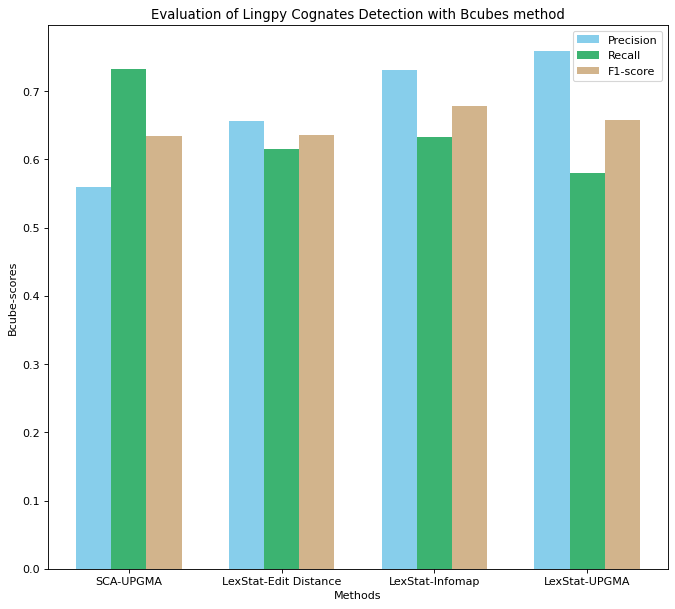

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 9), dpi=80)
  
N = 4
ind = np.arange(N) 
width = 0.23
  

xvals = [0.5591,0.6564,0.7305, 0.7586]
bar1 = plt.bar(ind, xvals, width, color = 'skyblue')
  

yvals = [0.7330, 0.6157, 0.6331, 0.5803]
bar2 = plt.bar(ind+width, yvals, width, color='mediumseagreen')
  

zvals = [0.6343,0.6354, 0.6783,0.6576]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'tan')
  
plt.xlabel("Methods")
plt.ylabel('Bcube-scores')
plt.title("Evaluation of Lingpy Cognates Detection with Bcubes method")
  
plt.xticks(ind+width,['SCA-UPGMA', 'LexStat-Edit Distance', 'LexStat-Infomap', 'LexStat-UPGMA'])
plt.legend( (bar1, bar2, bar3), ('Precision', 'Recall', 'F1-score') )
plt.show()

In [278]:
import pandas as pd
  
# initialize data of lists.
data = {'Threshold': [0.75,0.6564,0.7305
    'Precision': [0.5591,0.6564,0.7305,
        'Recall': [0.7330, 0.6157, 0.6331],
       'F1-Score':[0.6343,0.6354, 0.6783]}
  
# Create DataFrame
df = pd.DataFrame(data, index=['threshold','SCA',
                               'LexStat-Edit Distance',
                              'LexStat-Infomap',])

In [279]:
df

,Precision,Recall,F1-Score
SCA,0.5591,0.7330,0.6343
LexStat-Edit Distance,0.6564,0.6157,0.6354
LexStat-Infomap,0.7305,0.6331,0.6783
LexStat-UPGMA,0.7586,0.5803,0.6576


# Calculation of distance matrix of words in all the labguages, for SCA, LexStat-Edit Distance and LexStat-Infomap

Here, we will calculate the distance between all the languages by using distance matrix.The distance matrix file is all text, with one language and its distances on each line, separated by spaces, and the number of languages in the first row.

In [181]:
wl.get_distances('edit-dist')
wl.output('dst', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_EditDist_Matrix')

2022-08-31 17:28:43,255 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_EditDist_Matrix.dst>.


In [192]:
LexStat_Edit_distance = pd.read_csv(r'C:\Users\SHALAKA\Desktop\input\Info-editDist.csv')
LexStat_Edit_distance

,Languages,Assamese,Bengali,Bhojpuri,Dhivehi,Gujarati,Hindi,Kashmiri,Konkani,Marathi,Nepali,Oriya,Pali,Punjabi,Romani,Sanskrit,Sindhi,Sinhalese,Urdu
0,Assamese,0.0000,0.3247,1.0000,0.4675,0.4868,0.4805,1.0000,0.5195,0.5455,0.4416,0.3766,1.0000,0.4416,0.5325,1.0000,0.4737,0.5325,0.4805
1,Bengali,0.3247,0.0000,1.0000,0.5325,0.4211,0.4156,1.0000,0.4675,0.4675,0.4805,0.2987,1.0000,0.3896,0.5455,1.0000,0.4342,0.5714,0.4156
2,Bhojpuri,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000,1.0000,0.8831,1.0000,1.0000,0.7403,1.0000,1.0000,1.0000
3,Dhivehi,0.4675,0.5325,1.0000,0.0000,0.5263,0.5714,1.0000,0.5844,0.5714,0.5584,0.5325,1.0000,0.5325,0.5844,1.0000,0.5395,0.3766,0.5714
4,Gujarati,0.4868,0.4211,1.0000,0.5263,0.0000,0.2895,1.0000,0.4079,0.2895,0.3947,0.3816,1.0000,0.2368,0.5395,1.0000,0.2533,0.5000,0.3026
5,Hindi,0.4805,0.4156,1.0000,0.5714,0.2895,0.0000,1.0000,0.4935,0.4026,0.3117,0.4026,1.0000,0.1299,0.4675,1.0000,0.2632,0.5325,0.0260
6,Kashmiri,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.9481,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000
7,Konkani,0.5195,0.4675,1.0000,0.5844,0.4079,0.4935,1.0000,0.0000,0.3896,0.5065,0.5325,1.0000,0.4416,0.6234,1.0000,0.4342,0.5584,0.4935
8,Marathi,0.5455,0.4675,1.0000,0.5714,0.2895,0.4026,1.0000,0.3896,0.0000,0.4805,0.5065,1.0000,0.3766,0.5714,1.0000,0.3816,0.5455,0.4156
9,Nepali,0.4416,0.4805,1.0000,0.5584,0.3947,0.3117,1.0000,0.5065,0.4805,0.0000,0.4935,1.0000,0.3117,0.4805,1.0000,0.4079,0.5455,0.3117


The below code converts the output of Lexstat Edit distance to a nexus file format, which will be then used to generate phylogenetic tree. The nexus file contains matrix of words and the cognate judgements. If the word in the langauge of row is cognate with the word in the language of coloumn, then in the matrix it is written as 1 or else 0

In [209]:
from lingpy.convert.strings import matrix2dst, write_nexus
nexLexstat_Edit = write_nexus(wl, mode="MrBayes", filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexstatEdit.nex', ref='editid')

2022-08-31 18:05:42,980 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexstatEdit.nex>.


Calculating Distnace for LexStat Infomap

In [205]:
inf.get_distances('edit-dist')
inf.output('dst', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_Infomap_Matrix')

2022-08-31 17:56:56,181 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStat_Infomap_Matrix.dst>.


In [206]:
LexStat_Infomap = pd.read_csv(r'C:\Users\SHALAKA\Desktop\input\LexStat Infomap Matrix.csv')
LexStat_Infomap

,Languages,Assamese,Bengali,Bhojpuri,Dhivehi,Gujarati,Hindi,Kashmiri,Konkani,Marathi,Nepali,Oriya,Pali,Punjabi,Romani,Sanskrit,Sindhi,Sinhalese,Urdu
0,Assamese,0.0000,0.3247,1.0000,0.4675,0.4868,0.4805,1.0000,0.5195,0.5455,0.4416,0.3766,1.0000,0.4416,0.5325,1.0000,0.4737,0.5325,0.4805
1,Bengali,0.3247,0.0000,1.0000,0.5325,0.4211,0.4156,1.0000,0.4675,0.4675,0.4805,0.2987,1.0000,0.3896,0.5455,1.0000,0.4342,0.5714,0.4156
2,Bhojpuri,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000,1.0000,0.8831,1.0000,1.0000,0.7403,1.0000,1.0000,1.0000
3,Dhivehi,0.4675,0.5325,1.0000,0.0000,0.5263,0.5714,1.0000,0.5844,0.5714,0.5584,0.5325,1.0000,0.5325,0.5844,1.0000,0.5395,0.3766,0.5714
4,Gujarati,0.4868,0.4211,1.0000,0.5263,0.0000,0.2895,1.0000,0.4079,0.2895,0.3947,0.3816,1.0000,0.2368,0.5395,1.0000,0.2533,0.5000,0.3026
5,Hindi,0.4805,0.4156,1.0000,0.5714,0.2895,0.0000,1.0000,0.4935,0.4026,0.3117,0.4026,1.0000,0.1299,0.4675,1.0000,0.2632,0.5325,0.0260
6,Kashmiri,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.9481,1.0000,1.0000,0.8182,1.0000,1.0000,1.0000
7,Konkani,0.5195,0.4675,1.0000,0.5844,0.4079,0.4935,1.0000,0.0000,0.3896,0.5065,0.5325,1.0000,0.4416,0.6234,1.0000,0.4342,0.5584,0.4935
8,Marathi,0.5455,0.4675,1.0000,0.5714,0.2895,0.4026,1.0000,0.3896,0.0000,0.4805,0.5065,1.0000,0.3766,0.5714,1.0000,0.3816,0.5455,0.4156
9,Nepali,0.4416,0.4805,1.0000,0.5584,0.3947,0.3117,1.0000,0.5065,0.4805,0.0000,0.4935,1.0000,0.3117,0.4805,1.0000,0.4079,0.5455,0.3117


The below code converts the output of Lexstat Edit distance to a nexus file format, which will be then used to generate phylogenetic tree. The nexus file contains matrix of words and the cognate judgements. If the word in the langauge of row is cognate with the word in the language of coloumn, then in the matrix it is written as 1 or else 0

In [208]:
from lingpy.convert.strings import matrix2dst, write_nexus
nexLexstat_Infomap = write_nexus(inf, mode="MrBayes", filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStatInfomap.nex', ref='infomapid')

2022-08-31 18:05:27,642 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\LexStatInfomap.nex>.


Our Analysis of Cognate detection with lingpy library ends here. Now we will use PMI, a Natural language processing algorithm for cognate detection. For this algorithm, spepartes ipynbp files are created for clustering method. The names of the ipynb files are distances and DistanceMeasures. To import these files in this notebook, we will install jupytern otebook's import library

# Automatic Cognate Detection with PMI algorithm 

In [216]:
pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [217]:
import import_ipynb

In [222]:
from collections import defaultdict
import itertools as it
import sys, distances, igraph,utils
import numpy as np
import random, codecs
import DistanceMeasures as DM
from sklearn import metrics
from lingpy import *
random.seed(1234)

importing Jupyter notebook from utils.ipynb


The PMI is used  with the below procedure 
1. obtain a list of word pairs from Swadesh list which are most likely cognates. In this study, we 
consider all word pairs with a length normalized Levenshtein distance (LDN) of less than 0.5 
to be plausible cognates. The wordlist is first cleaned and converted intoo ASJP format.

2. Use the Needleman-Wunsch technique to align the list of possible cognates. All the cognate detected are then paased as an input to infomap algorithm

3. We take advantage of this trait to create a partial graph and feed the subsequent network into 
the InfoMap method. 

4. Using the Needleman-Wunsch algorithm and result obtained from step 2,we create a new set of 
alignments. 

5. Steps 2 and 3 are repeated until the average similarity between repetitions remains 
constant. 

After completing the above steps, a PMI based score will be generated for each word pair. To get the 
PMI score in the range of [0, 1], we transformed the similarity score into distance score using the 
formula, 
1.0 − (1 + exp(−𝑥))^-1

The matrix will be then given as an input to the Infomap clustering algorithm . 

The output of the clustering is then converted into a nexus file format for generating phylogenetic tree

In [280]:
# Code to cretae a Machine Learning based eastimator for cognate detection.
# First we define the informap algorithm threshhold, batch size
MAX_ITER = 15
tolerance = 0.001
infomap_threshold = 0.57
min_batch = 256
margin = 0.0
# The output file will be generated in nexus format
OutputFile = "outputnexfile"

char_list = []
# In the first step, we will celan the wordlist and convert the wordlist to ASJP format
def clean_word(w):
    w = w.replace("-","")
    w = w.replace(" ", "")
    w = w.replace("%","")
    w = w.replace("~","")
    w = w.replace("*","")
    w = w.replace("$","")
    w = w.replace("\"","")
    w = w.replace("K","k")
    w = w.replace("|","")
    w = w.replace(".","")
    w = w.replace("+","")
    w = w.replace("·","")
    w = w.replace("?","")
    w = w.replace("’","")
    w = w.replace("]","")
    w = w.replace("[","")
    w = w.replace("=","")
    w = w.replace("_","")
    w = w.replace("<","")
    w = w.replace(">","")
    w = w.replace("/","")
    w = w.replace("‐","")
   
    return w
# Here all the IPA's are combined in the wordlist
def ipa2sca(w):
    return "".join(tokens2class(ipa2tokens(w), 'asjp')).replace("0","")

#The function below will create individual lists of the columns with data, cognate ID, words, doculect
# Iterate through all the words in wordlist and append each charatecter in char_list, words in dict_of_words, cogid in dict_of_cogids
# and language in doculect
def read_ielex_data(fname):
    line_id = 0
    dict_of_data = defaultdict(lambda : defaultdict())
    dict_of_cogid = defaultdict(lambda : defaultdict())
    dict_of_words = defaultdict(lambda : defaultdict(list))
    doculect = []
   
    for i in range(5,len(fname)):
        line = fname.iloc[i]
        arr = line
        lang = arr[4]
        concept = arr[1]
        cogid = arr[5]
        cogid = cogid.replace("-","")
        cogid = cogid.replace("?","")
        asjp_word = clean_word(arr[3].split(",")[0])

        for ch in asjp_word:
            if ch not in char_list:
                char_list.append(ch)

        if len(asjp_word) < 1:
            continue

        dict_of_data[concept][line_id,lang] = asjp_word
        dict_of_cogid[concept][line_id,lang] = cogid
        dict_of_words[concept][lang].append(asjp_word)
        if lang not in doculect:
            doculect.append(lang)
        line_id += 1
    
    print(list(dict_of_data.keys()))
    return (dict_of_data, dict_of_cogid, dict_of_words, doculect)

# The below function is crated for clustering by suing igraph. 
def igraph_clustering(matrix, threshold, method='labelprop'):
    """
    Method computes Infomap clusters from pairwise distance data.
    """
    random.seed(1234)
    G = igraph.Graph()
    vertex_weights = []
    for i in range(len(matrix)):
        G.add_vertex(i)
        vertex_weights += [0]
    
# The weights of the edge will be stored in variable 'weights' if the weights are not present
#it indicates that the network is seperated by variable
    weights = None
    for i,row in enumerate(matrix):
        for j,cell in enumerate(row):
            if i < j:
                if cell <= threshold:
                    G.add_edge(i, j, weight=1-cell, distance=cell)
                    weights = 'weight'

    if method == 'infomap':
        comps = G.community_infomap(edge_weights=weights,
                vertex_weights=None)
        
    elif method == 'labelprop':
        comps = G.community_label_propagation(weights=weights,
                initial=None, fixed=None)

    elif method == 'ebet':
        dg = G.community_edge_betweenness(weights=weights)
        oc = dg.optimal_count
        comps = False
        while oc <= len(G.vs):
            try:
                comps = dg.as_clustering(dg.optimal_count)
                break
            except:
                oc += 1
        if not comps:
            print('Failed...')
            comps = list(range(len(G.sv)))
            input()
    elif method == 'multilevel':
        comps = G.community_multilevel(return_levels=False)
    elif method == 'spinglass':
        comps = G.community_spinglass()

# Tree with the vertices is stores in 'D'
    D = {}
    for i,comp in enumerate(comps.subgraphs()):
        vertices = [v['name'] for v in comp.vs]
        for vertex in vertices:
            D[vertex] = i+1

    return D

# Function to calculate the precison, recall , accuracy for infomap clustering and store the cognate judgements in Binary matrix
# Edit distance is calculated for all the words in the languages and stored in a distance matrix
def evalue_infomap_scores(d, lodict, gop, gep):
    average_fscore = []
    f_scores = []
    binary_matrix, n_clusters = [], 0
    for concept in d:
        ldn_dist_dict = defaultdict(lambda: defaultdict(float))
        langs = list(d[concept].keys())
        if len(langs) == 1:
            print(concept)
            continue
        scores, cognates = [], []
        for l1, l2 in it.combinations(langs, r=2):
            if d[concept][l1].startswith("-") or d[concept][l2].startswith("-"): continue
            w1, w2 = d[concept][l1], d[concept][l2]
            score = distances.nw(w1, w2, lodict=lodict, gp1=gop, gp2=gep)[0]
            score = 1.0 - (1.0/(1.0+np.exp(-score)))
            ldn_dist_dict[l1][l2] = score
            ldn_dist_dict[l2][l1] = ldn_dist_dict[l1][l2]
        distMat = np.array([[ldn_dist_dict[ka][kb] for kb in langs] for ka in langs])
        clust = igraph_clustering(distMat, infomap_threshold, method='infomap')
        
        
        predicted_labels = defaultdict()
        predicted_labels_words = defaultdict()
        for k, v in clust.items():
            predicted_labels[langs[k]] = v
            predicted_labels_words[langs[k],d[concept][langs[k]]] = v
        
        predl, truel = [], []
        for l in langs:
            truel.append(dict_of_cogid[concept][l])
            predl.append(predicted_labels[l])
        scores = DM.b_cubed(truel, predl)
        
        print(concept, len(langs), scores, len(set(clust.values())), len(set(truel)))
        f_scores.append(list(scores))
        n_clusters += len(set(clust.values()))
        t = utils.dict2binarynexus(predicted_labels, lang_list)
        binary_matrix += t

    f_scores = np.mean(np.array(f_scores), axis=0)
    print(f_scores[0], f_scores[1], 2.0*f_scores[0]*f_scores[1]/(f_scores[0]+f_scores[1]))
    return binary_matrix

# After calculating a prior tree with infomap, we will feed this tree to the PMI algorithm
def calc_pmi(alignment_dict, char_list, scores, initialize=False):
    sound_dict = defaultdict(float)
    alignment_frequency = 0.0
    sound_frequency = 0.0
    store_count = defaultdict(float)
    
    if initialize == True:
        for c1, c2 in it.product(char_list, repeat=2):
            if c1 == "-" or c2 == "-":
                continue
            store_count[c1,c2] += 0.001
            store_count[c2,c1] += 0.001
            sound_dict[c1] += 0.001
            sound_dict[c2] += 0.001
            alignment_frequency += 0.001
            sound_frequency += 0.002

    for alignment, score in zip(alignment_dict, scores):
        #score = 1.0
        for a1, a2 in alignment:
            if a1 == "-" or a2 == "-":
                continue
            store_count[a1,a2] += 1.0*score
            store_count[a2,a1] += 1.0*score
            sound_dict[a1] += 2.0*score
            sound_dict[a2] += 2.0*score
            #alignment_frequency += 2.0
            #sound_frequency += 2.0

    alignment_frequency = sum(list(store_count.values()))
    sound_frequency = sum(list(sound_dict.values()))
    
    for a in store_count.keys():
        m = store_count[a]
        if m <=0: print(a, m)
        assert m>0

        num = np.log(m)-np.log(alignment_frequency)
        denom = np.log(sound_dict[a[0]])+np.log(sound_dict[a[1]])-(2.0*np.log(sound_frequency))
        val = num - denom
        store_count[a] = val
    
    return store_count
newf = pd.read_csv(r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_pmi_eval.csv')
dict_of_data, dict_of_cogid, dict_of_words, lang_list = read_ielex_data(newf)
print("Character list \n\n", char_list)
print("Length of character list ", len(char_list))

word_list = []

for concept in dict_of_data:
    print(concept)
    words = []
    for idx in dict_of_data[concept]:
        words.append(dict_of_data[concept][idx])
    for x, y in it.combinations(words, r=2):
        if distances.ldn(x, y) <=0.5:
            word_list += [[x,y]]

pmidict = None
n_examples, n_updates, alpha = len(word_list), 0, 0.75
len_wordlist = len(word_list)
print("Size of initial list ", len_wordlist)


pmidict = defaultdict(float)

for n_iter in range(MAX_ITER):
    random.shuffle(word_list)
    pruned_wl = []
    n_zero = 0.0
    print("Iteration ", n_iter)
    for idx in range(0, len_wordlist, min_batch):
        wl = word_list[idx:idx+min_batch]
        eta = np.power(n_updates+2, -alpha)
        algn_list, scores = [], []
        for w1, w2 in wl:
            
            if not pmidict:
                s, alg = distances.nw(w1, w2, lodict=None, gp1=-2.5, gp2=-1.75)
            else:
                s, alg = distances.nw(w1, w2, lodict=pmidict, gp1=-2.5, gp2=-1.75)
            if s <= margin:
                n_zero += 1.0
                continue
            
            algn_list.append(alg)
            scores.append(s)
           
            pruned_wl.append([w1, w2])	  
        mb_pmi_dict = calc_pmi(algn_list, char_list, scores, initialize=True)
        for k, v in mb_pmi_dict.items():
            pmidict_val = pmidict[k]
            pmidict[k] = (eta*v) + ((1.0-eta)*pmidict_val)
        n_updates += 1
    print("Non zero examples ", len_wordlist, len_wordlist-n_zero, " number of updates ", n_updates)
    word_list = pruned_wl[:]
    len_wordlist = len(word_list)

binary_matrix = evalue_infomap_scores(dict_of_data, pmidict, -2.5, -1.75)
nchar, nlangs = np.array(binary_matrix).shape

fw = open(OutputFile+".nex","w")
fw.write("begin data;"+"\n")
fw.write("   dimensions ntax="+str(nlangs)+" nchar="+str(nchar)+";\nformat datatype=restriction interleave=no missing= ? gap=-;\nmatrix\n")

for row, lang in zip(np.array(binary_matrix).T, lang_list):
    #print(row,len(row), "\n")
    rowx = "".join([str(x) for x in row])
    
    fw.write(lang+"\t"+rowx.replace("2","?")+"\n")
fw.write(";\nend;")

fil = OutputFile+".nex"



['ahám', 'tvám', 'vayám,', 'idám', 'tát', 'ká', 'kím', 'ná', 'sárva', 'bahú', 'éka', 'dví', 'mahát', 'dīrghá', 'álpa', 'strī́', 'púruṣa,', 'mátsya', 'ví,', 'śván', 'yūkā', 'vṛkṣá,', 'bī́ja', 'páttra', 'mū́la', 'tvác', 'cárman,', 'māṃsá', 'rakta,', 'ásthi', 'pī́vas,', 'aṇḍá', 'śṛṅgá', 'púccha', 'parṇá', 'kéśa', 'śíras', 'kárṇa', 'ákṣi', 'nā́sā', 'dánta', 'jihvā́', 'padá', 'jā́nu', 'hásta,', 'udára', 'gala,', 'stána', 'hṛ́daya', 'yákṛt', 'sū́rya,', 'mā́sa,', 'nákṣatra,', 'jalá,', 'varṣá', 'áśman', 'pāṃsú,', 'kṣám,', 'nábhas,', 'dhūmá', 'agní', 'ā́sa', 'patha,', 'girí,', 'harit,', 'pīta,', 'śvetá', 'kṛṣṇá', 'rā́tri,', 'taptá', 'śītá', 'pūrṇá', 'náva,', 'vásu,', 'vṛttá,', 'śúṣka', 'nā́man']
Character list 

 ['ˌ', 'ɑ', 'ˈ', 'h', 'ṃ', 'm', 'ɛ', 'ː', 'ə', 'ũ', 'N', 'o', 'n', 'e', 'i', 'ɦ', 'ʋ', 'ɔ', 'ɪ', 'a', 'b', 'ɨ', 'ɾ', 't', 'ɐ', 'u', 'ʌ', 'j', 's', 'k', 'æ', 'l', ':', 'z', 'ī', '̃', 'ʱ', 'r', 'ʲ', 'p', 'd', 'y', 'v', 'w', 'x', 'ʊ', 'ޭ', 'ʰ', 'ɳ', 'ɜ', 'ṇ', 'í', 'c', 'ś', 'ẽ', '̊', 'ĩ', 

In [291]:
import pandas as pd
  
# initialize data of lists.
data = {'Threshold':[0.5, 0.75, 0.55, 0.5],
    'Precision': [0.5591,0.6564,0.7305,0.68847 ],
        'Recall': [0.7330, 0.6157, 0.6331, 0.66925],
       'F1-Score':[0.6343,0.6354, 0.6783, 0.67873]}
  
# Create DataFrame
df = pd.DataFrame(data, index=['SCA',
                               'LexStat-Edit Distance',
                              'LexStat-Infomap','PMI' ])

In [292]:
df

,Threshold,Precision,Recall,F1-Score
SCA,0.50,0.55910,0.73300,0.63430
LexStat-Edit Distance,0.75,0.65640,0.61570,0.63540
LexStat-Infomap,0.55,0.73050,0.63310,0.67830
PMI,0.50,0.68847,0.66925,0.67873


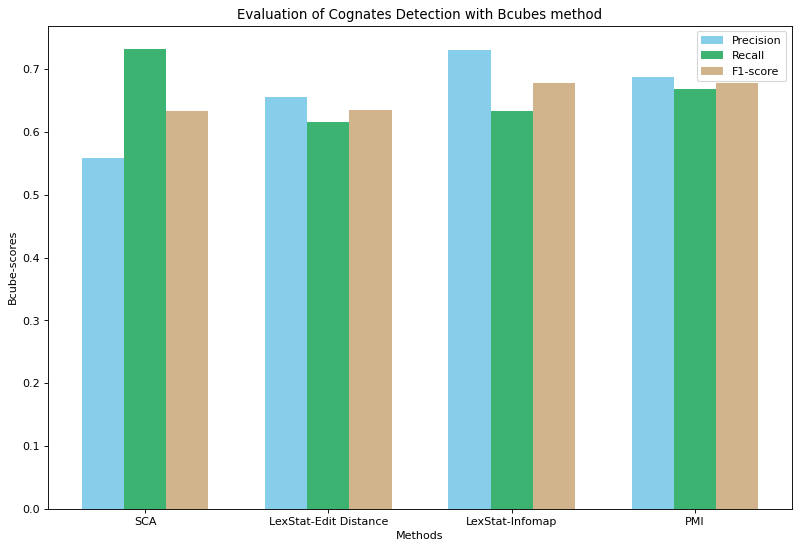

In [301]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
  
N = 4
ind = np.arange(N) 
width = 0.23
  

xvals = [0.5591,0.6564,0.7305, 0.68847]
bar1 = plt.bar(ind, xvals, width, color = 'skyblue')
  

yvals = [0.7330, 0.6157, 0.6331, 0.66925]
bar2 = plt.bar(ind+width, yvals, width, color='mediumseagreen')
  

zvals = [0.6343,0.6354, 0.6783, 0.67873]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'tan')
  
plt.xlabel("Methods")
plt.ylabel('Bcube-scores')
plt.title("Evaluation of Cognates Detection with Bcubes method")
  
plt.xticks(ind+width,['SCA', 'LexStat-Edit Distance', 'LexStat-Infomap', 'PMI'])
plt.legend( (bar1, bar2, bar3), ('Precision', 'Recall', 'F1-score') )
plt.show()

In [284]:
wl2 = r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\Swadesh_Eval_list.tsv'
alm = Alignments(wl2, ref="cogid")
alm.output('html', filename=r'C:\Users\SHALAKA\Desktop\input\Final Dissertation material\alignmentsn')

2022-09-01 00:09:27,147 [INFO] Data has been written to file <C:\Users\SHALAKA\AppData\Local\Temp\tmp22mh6kt1.alm>.
2022-09-01 00:09:27,289 [INFO] Data has been written to file <C:\Users\SHALAKA\Desktop\input\Final Dissertation material\alignmentsn.html>.
